In [1]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from gym.envs.toy_text.frozen_lake import generate_random_map
import tqdm

In [2]:
random_map = generate_random_map(size=4, p=0.3)
lake = gym.make("FrozenLake-v1", desc=random_map, is_slippery=False)
lake.reset()
lake.render()


SFHF
HFHH
FFHH
FFFG


In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

obs_shape = 1
n_actions = lake.action_space.n
model = keras.models.Sequential([
                                 keras.layers.Dense(32, activation='relu', input_shape=[obs_shape]),
                                 keras.layers.Dense(64, activation='relu'),
                                 keras.layers.Dense(64, activation='relu'),
                                 keras.layers.Dense(n_actions)
])

# remove output of model.predict
def epsilon_greedy(state, epsilon=0.1):
    # print(state)
    if np.random.rand() < epsilon:
        print("random action")
        return np.random.randint(n_actions)
    else:
        print("greedy action")
        Q_values = model.predict([state])
        return np.argmax(Q_values[0])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6,596
Trainable params: 6,596
Non-trainable params: 0
_________________________________________________________________


In [26]:
# def epsilon_greedy(state, epsilon):
#     if np.random.binomial(1, epsilon):
#         return np.random.randint(n_actions)
#     else:
#         return np.argmax(model.predict([state]))

In [8]:
n_episodes = 100
replay_buffer = []
batch_size = 32
gamma = 0.98
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.mean_squared_error

goal_reached = []

for episode in tqdm.tqdm(range(n_episodes)):
    done = False
    state = lake.reset()
    print("Current state: ", state)
    while not done:
        #I CHOOSE A LINEAR DECAY OF EPSILON
        epsilon = (-0.09/(n_episodes-1))*episode + 1
        #PLAY THE GAME USING EPSILON-GREEDY WITH CURRENT POLICY UNTIL IT'S DONE
        action = epsilon_greedy(state, epsilon)
        print("Action: ", action)
        next_state, reward, done, info = lake.step(action)
        print("Next state: {} Reward: {} Done: {} Info: {}".format(next_state, reward, done, info))
        lake.render()
        #WE RECORD IF THE EPISODED ENDED ON THE GOAL CASE OR NOT
        if done:
            if next_state==15:
                goal_reached.append(1)
            else:
                goal_reached.append(0)
        #WE STORE THAT DATA INTO A BUFFER TO REPLAY FROM LATER AND TRAIN OUR MODEL
        #IN THE BUFFER WE STORE THE TRAJECTORIES
        replay_buffer.append((state, action, reward, (next_state-7.5)/4.61, done))
        #THE NEXT_STATE BECOMES THE STATE FROM WHICH WE MOVE
        state = (next_state-7.5)/4.61
    print()
  
    #AFTER PLAYING FOR A WHILE WE HAVE ENOUGH TRAJECTORIES WE CAN START TRAINING
    if episode>32:
        #WE SAMPLE batch_size TRAJECTORIES
        indices = np.random.randint(len(replay_buffer), size=batch_size)
        batch = [replay_buffer[index] for index in indices] 
        states, actions, rewards, next_states, dones = [np.array([trajectory[i] for trajectory in batch]) for i in range(5)]
        #WE HAVE TO COMPUTE THE TARGET VALUES TO WHICH WE TRY TO APPROACH
        target_Q_values = rewards + (1-dones)*gamma*np.max(model.predict(next_states), axis=1)
        #TIME TO COMPUTE THE GRADIENTS
        mask = tf.one_hot(actions, n_actions)
        with tf.GradientTape() as tape:
            #WE COMPUTE THE ACTUAL Q_VALUES
            Q_values = model(states[:,np.newaxis])
            Q_values = tf.reduce_sum(Q_values * mask, axis=1, keepdims=True)
            #WE COMPUTE THE LOSS BETWEEN OUR ACTUAL Q_VALUES AND THE TARGET VALUES
            loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
        #WE COMPUTE THE GRADIENTS OF THE LOSS WITH RESPECT TO THE MODEL'S VARIABLES
        grads = tape.gradient(loss, model.trainable_variables)
        #WE APPLY THE GRADIENTS TO THE MODEL'S VARIABLES USING THE OPTIMIZER
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

# actions: left - 0, down - 1, right - 2, up - 3

  0%|          | 0/100 [00:00<?, ?it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.

 10%|█         | 10/100 [00:01<00:14,  6.12it/s]

Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 9 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFH

 31%|███       | 31/100 [00:01<00:03, 22.01it/s]

Action:  1
Next state: 9 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG

Current state:  0
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 30ms/step
Current state:  0
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG


 41%|████      | 41/100 [00:02<00:04, 14.15it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 38ms/step
Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 39ms/step
Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 20ms/step
Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 25ms/step
Current state:  0
random action
Action:  1
Next

 47%|████▋     | 47/100 [00:03<00:04, 12.79it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
greedy action
1/1 [==============================] - 0s 52ms/step
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Re

 51%|█████     | 51/100 [00:04<00:04, 11.70it/s]

Current state:  0
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 30ms/step
Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:

 54%|█████▍    | 54/100 [00:04<00:04, 11.30it/s]

Current state:  0
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 25ms/step
Current state:  0
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 28ms/step
Current state:  0
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: Fals

 57%|█████▋    | 57/100 [00:04<00:03, 11.15it/s]

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 23ms/step
Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 59/100 [00:04<00:03, 11.04it/s]

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 38ms/step
Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
greedy action
1/1 [==============================] - 0s 59ms/step
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1

 61%|██████    | 61/100 [00:05<00:04,  9.47it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 6 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 27ms/step
Current state:  0
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 63/100 [00:05<00:03,  9.74it/s]

Current state:  0
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 27ms/step
Current state:  0
greedy action
1/1 [==============================] - 0s 53ms/step
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 65/100 [00:05<00:04,  8.74it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 26ms/step
Current state:  0
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
greedy action
1/1 [==============================] - 0s 53ms/step
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 

 67%|██████▋   | 67/100 [00:06<00:04,  7.93it/s]

Current state:  0
greedy action
1/1 [==============================] - 0s 76ms/step
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 68/100 [00:06<00:04,  6.86it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
greedy action
1/1 [==============================] - 0s 58ms/step
Action:  1
Next state: 9 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 13 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 9 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 9 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 5

 69%|██████▉   | 69/100 [00:06<00:04,  6.37it/s]

Current state:  0
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 70/100 [00:06<00:04,  6.76it/s]

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 71/100 [00:06<00:04,  6.95it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 72/100 [00:06<00:03,  7.38it/s]

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 73/100 [00:06<00:03,  7.75it/s]

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 29ms/step
Current state:  0
greedy action
1/1 [==============================] - 0s 66ms/step
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
greedy action
1/1 [==============================] - 0s 52ms/step
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 75/100 [00:07<00:04,  6.02it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF


 76%|███████▌  | 76/100 [00:07<00:04,  5.58it/s]

Current state:  0
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 77/100 [00:07<00:03,  6.02it/s]

Current state:  0
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 6 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 78/100 [00:07<00:03,  6.54it/s]

Current state:  0
greedy action
1/1 [==============================] - 0s 67ms/step
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 79/100 [00:08<00:03,  5.47it/s]

Current state:  0
greedy action
1/1 [==============================] - 0s 52ms/step
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:08<00:03,  5.31it/s]

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 81/100 [00:08<00:03,  6.07it/s]

Current state:  0
greedy action
1/1 [==============================] - 0s 63ms/step
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 82/100 [00:08<00:03,  5.40it/s]

Current state:  0
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SF

 84%|████████▍ | 84/100 [00:08<00:02,  6.86it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 85/100 [00:08<00:02,  7.33it/s]

Current state:  0
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
greedy action
1/1 [==============================] - 0s 57ms/step
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 86/100 [00:09<00:02,  6.01it/s]

Current state:  0
greedy action
1/1 [==============================] - 0s 56ms/step
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
greedy action
1/1 [==============================] - 0s 64ms/step
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 87/100 [00:09<00:02,  4.78it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 88/100 [00:09<00:02,  5.49it/s]

Current state:  0
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 89/100 [00:09<00:01,  6.18it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 90/100 [00:09<00:01,  6.70it/s]

Current state:  0
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
greedy action
1/1 [==============================] - 0s 70ms/step
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 91/100 [00:10<00:01,  5.60it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 92/100 [00:10<00:01,  6.02it/s]

Current state:  0
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 9 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 8 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 8 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 8 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 8 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Lef

 93%|█████████▎| 93/100 [00:10<00:01,  6.67it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 5 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 94/100 [00:10<00:00,  7.10it/s]

Current state:  0
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 95/100 [00:10<00:00,  7.48it/s]

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 96/100 [00:10<00:00,  7.89it/s]

Current state:  0
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
greedy action
1/1 [==============================] - 0s 55ms/step
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 97/100 [00:10<00:00,  6.47it/s]

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 98/100 [00:11<00:00,  7.09it/s]

Current state:  0
random action
Action:  0
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Left)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  3
Next state: 0 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Up)
SFHF
HFHH
FFHH
FFFG
random action
Action:  2
Next state: 1 Reward: 0.0 Done: False Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG
greedy action
1/1 [==============================] - 0s 64ms/step
Action:  2
Next state: 2 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Right)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 99/100 [00:11<00:00,  5.89it/s]

Current state:  0
random action
Action:  1
Next state: 4 Reward: 0.0 Done: True Info: {'prob': 1.0}
  (Down)
SFHF
HFHH
FFHH
FFFG

1/1 [==============================] - 0s 38ms/step


100%|██████████| 100/100 [00:11<00:00,  8.77it/s]


In [6]:
lake.render()

  (Down)
SFHF
HFHH
FFHH
FFFG


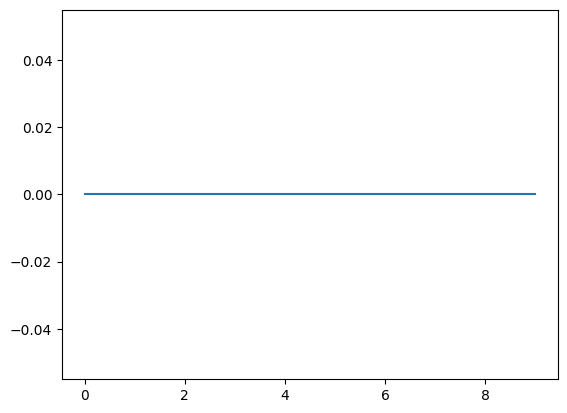

In [7]:
import matplotlib.pyplot as plt

plt.plot(np.arange(n_episodes), goal_reached)

In [10]:
qtable = Q_values
qtable

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.01690227],
       [0.01553862],
       [0.01394337],
       [0.01214761],
       [0.02150575],
       [0.01091105],
       [0.01184779],
       [0.01380605],
       [0.01245094],
       [0.01480176],
       [0.01832543],
       [0.01480176],
       [0.01091105],
       [0.00729991],
       [0.01030497],
       [0.01214761],
       [0.01553862],
       [0.01553862],
       [0.01553862],
       [0.01113466],
       [0.01480176],
       [0.01091105],
       [0.01480176],
       [0.01091105],
       [0.01245094],
       [0.01030497],
       [0.01091105],
       [0.01030497],
       [0.01091105],
       [0.01091105],
       [0.01480176],
       [0.01184433]], dtype=float32)>

In [11]:
# actions: left - 0, down - 1, right - 2, up - 3
state = lake.reset()
lake.render()
np.argmax(model.predict([state]))


SFHF
HFHH
FFHH
FFFG
1/1 [==============================] - 0s 39ms/step


0

In [12]:
from IPython.display import clear_output
import time 

state = lake.reset()
done = False
sequence = []


while not done:
    print("--------- State "+str(state)+" ---------")
    action = np.argmax(model.predict([(state-7.5)/4.61]))
    next_state, reward, done, info = lake.step(action)
    lake.render()
    state = next_state


while not done:
    # Choose the action with the highest value in the current state
    if np.max(qtable[state]) > 0:
      action = np.argmax(qtable[state])

    # If there's no best action (only zeros), take a random one
    else:
      action = lake.action_space.sample()
    
    # Add the action to the sequence
    sequence.append(action)

    # Implement this action and move the agent in the desired direction
    new_state, reward, done, info = lake.step(action)

    # Update our current state
    state = new_state

    # Update the render
    clear_output(wait=True)
    lake.render()
    time.sleep(1)

print(f"Sequence = {sequence}")

--------- State 0 ---------
1/1 [==============================] - 0s 40ms/step
  (Right)
SFHF
HFHH
FFHH
FFFG
--------- State 1 ---------
1/1 [==============================] - 0s 43ms/step
  (Right)
SFHF
HFHH
FFHH
FFFG
Sequence = []


In [13]:
model = keras.models.Sequential([
                                 keras.layers.Dense(64, activation='relu', input_shape=[obs_shape]),
                                 keras.layers.Dense(64, activation='relu'),
                                 keras.layers.Dense(n_actions)
])

In [14]:
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [15]:
n_episodes = 10000
replay_buffer = []
batch_size = 32
gamma = 0.98
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

goal_reached = []

for episode in tqdm.tqdm(range(n_episodes)):
    lake.reset()
    done = False
    state = (0-7.5)/4.61
    while not done:
        #I CHOOSE A LINEAR DECAY OF EPSILON
        epsilon = (-0.09/(n_episodes-1))*episode + 1
        #PLAY THE GAME USING EPSILON-GREEDY WITH CURRENT POLICY UNTIL IT'S DONE
        action = epsilon_greedy(state, epsilon)
        next_state, reward, done, info = lake.step(action)
        #WE RECORD IF THE EPISODED ENDED ON THE GOAL CASE OR NOT
        if done:
            if next_state==15:
                goal_reached.append(1)
            else:
                goal_reached.append(0)
        #WE STORE THAT DATA INTO A BUFFER TO REPLAY FROM LATER AND TRAIN OUR MODEL
        #IN THE BUFFER WE STORE THE TRAJECTORIES
        replay_buffer.append((state, action, reward, (next_state-7.5)/4.61, done))
        #THE NEXT_STATE BECOMES THE STATE FROM WHICH WE MOVE
        state = (next_state-7.5)/4.61
  
    #AFTER PLAYING FOR A WHILE WE HAVE ENOUGH TRAJECTORIES WE CAN START TRAINING
    if episode>32:
        #WE SAMPLE batch_size TRAJECTORIES
        indices = np.random.randint(len(replay_buffer), size=batch_size)
        batch = [replay_buffer[index] for index in indices] 
        states, actions, rewards, next_states, dones = [np.array([trajectory[i] for trajectory in batch]) for i in range(5)]
        #WE HAVE TO COMPUTE THE TARGET VALUES TO WHICH WE TRY TO APPROACH
        target_Q_values = rewards + (1-dones)*gamma*np.max(target.predict(next_states), axis=1)
        #TIME TO COMPUTE THE GRADIENTS
        mask = tf.one_hot(actions, n_actions)
        with tf.GradientTape() as tape:
            #WE COMPUTE THE ACTUAL Q_VALUES
            Q_values = model(states[:,np.newaxis])
            Q_values = tf.reduce_sum(Q_values * mask, axis=1, keepdims=True)
            #WE COMPUTE THE LOSS BETWEEN OUR ACTUAL Q_VALUES AND THE TARGET VALUES
            loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
        #WE COMPUTE THE GRADIENTS OF THE LOSS WITH RESPECT TO THE MODEL'S VARIABLES
        grads = tape.gradient(loss, model.trainable_variables)
        #WE APPLY THE GRADIENTS TO THE MODEL'S VARIABLES USING THE OPTIMIZER
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if episode % 64 == 0:
        target.set_weights(model.get_weights())

  0%|          | 0/10000 [00:00<?, ?it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random

  0%|          | 34/10000 [00:00<00:38, 257.19it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 29ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action


  1%|          | 60/10000 [00:02<07:05, 23.39it/s] 

random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
1/1 [==============================] - 0s 

  1%|          | 72/10000 [00:03<08:51, 18.67it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


  1%|          | 79/10000 [00:03<09:54, 16.69it/s]

random action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 18ms/step


  1%|          | 84/10000 [00:04<10:51, 15.21it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  1%|          | 88/10000 [00:04<11:26, 14.45it/s]

random action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


  1%|          | 91/10000 [00:04<11:51, 13.93it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  1%|          | 94/10000 [00:05<12:18, 13.41it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  1%|          | 96/10000 [00:05<12:34, 13.12it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


  1%|          | 98/10000 [00:05<12:49, 12.87it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


  1%|          | 100/10000 [00:05<12:59, 12.70it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
1/1 [==============================] - 0s 36ms/step


  1%|          | 102/10000 [00:05<13:24, 12.31it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


  1%|          | 104/10000 [00:06<13:34, 12.15it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  1%|          | 106/10000 [00:06<13:39, 12.08it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


  1%|          | 108/10000 [00:06<13:15, 12.44it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  1%|          | 110/10000 [00:06<12:59, 12.69it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 22ms/step


  1%|          | 112/10000 [00:06<12:50, 12.83it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


  1%|          | 114/10000 [00:06<12:48, 12.86it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


  1%|          | 116/10000 [00:07<13:23, 12.31it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 19ms/step


  1%|          | 118/10000 [00:07<13:31, 12.17it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  1%|          | 120/10000 [00:07<13:14, 12.43it/s]

random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


  1%|          | 122/10000 [00:07<13:13, 12.45it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 20ms/step


  1%|          | 124/10000 [00:07<13:04, 12.59it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 21ms/step


  1%|▏         | 126/10000 [00:07<13:22, 12.31it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 24ms/step


  1%|▏         | 128/10000 [00:07<13:36, 12.10it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 130/10000 [00:08<14:01, 11.72it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 19ms/step


  1%|▏         | 132/10000 [00:08<13:20, 12.32it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  1%|▏         | 134/10000 [00:08<13:13, 12.43it/s]

random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  1%|▏         | 136/10000 [00:08<13:30, 12.16it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  1%|▏         | 138/10000 [00:08<13:40, 12.02it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  1%|▏         | 140/10000 [00:08<13:48, 11.90it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  1%|▏         | 142/10000 [00:09<14:27, 11.37it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 18ms/step


  1%|▏         | 144/10000 [00:09<13:48, 11.90it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  1%|▏         | 146/10000 [00:09<13:37, 12.05it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  1%|▏         | 148/10000 [00:09<13:29, 12.17it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 150/10000 [00:09<13:25, 12.22it/s]

random action
random action
random action
1/1 [==============================] - 0s 40ms/step
random action
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 152/10000 [00:10<14:38, 11.21it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 154/10000 [00:10<14:23, 11.40it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 156/10000 [00:10<14:18, 11.47it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 158/10000 [00:10<14:12, 11.54it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 160/10000 [00:10<14:16, 11.49it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 162/10000 [00:10<13:56, 11.76it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 164/10000 [00:11<13:59, 11.71it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 166/10000 [00:11<14:07, 11.60it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 168/10000 [00:11<13:43, 11.94it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 170/10000 [00:11<13:42, 11.96it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 172/10000 [00:11<13:53, 11.79it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 174/10000 [00:11<13:43, 11.93it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 176/10000 [00:12<13:58, 11.71it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 178/10000 [00:12<13:29, 12.14it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 180/10000 [00:12<13:01, 12.57it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 182/10000 [00:12<12:52, 12.71it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 184/10000 [00:12<12:44, 12.84it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 186/10000 [00:12<12:39, 12.92it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 78ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 188/10000 [00:13<15:50, 10.32it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 190/10000 [00:13<14:28, 11.30it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 192/10000 [00:13<13:35, 12.03it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 194/10000 [00:13<13:35, 12.03it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 196/10000 [00:13<13:15, 12.33it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 198/10000 [00:13<13:13, 12.36it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 200/10000 [00:14<13:19, 12.26it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 202/10000 [00:14<13:33, 12.04it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 204/10000 [00:14<13:49, 11.82it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 206/10000 [00:14<15:28, 10.55it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  2%|▏         | 208/10000 [00:14<14:28, 11.27it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 210/10000 [00:14<13:41, 11.91it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 212/10000 [00:15<13:45, 11.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 214/10000 [00:15<13:29, 12.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 216/10000 [00:15<13:23, 12.18it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 218/10000 [00:15<12:56, 12.60it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 220/10000 [00:15<13:05, 12.46it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 222/10000 [00:15<13:30, 12.06it/s]

random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
1/1 [==============================] - 0s 31ms/step


  2%|▏         | 224/10000 [00:16<13:43, 11.87it/s]

random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  2%|▏         | 226/10000 [00:16<13:33, 12.01it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 25ms/step


  2%|▏         | 228/10000 [00:16<13:07, 12.41it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 230/10000 [00:16<12:59, 12.53it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 26ms/step


  2%|▏         | 232/10000 [00:16<13:09, 12.38it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 23ms/step


  2%|▏         | 234/10000 [00:16<13:10, 12.36it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 236/10000 [00:17<13:20, 12.19it/s]

random action
random action
random action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 238/10000 [00:17<13:35, 11.98it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  2%|▏         | 240/10000 [00:17<13:07, 12.39it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 31ms/step


  2%|▏         | 242/10000 [00:17<13:36, 11.94it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 244/10000 [00:17<13:11, 12.32it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


  2%|▏         | 246/10000 [00:17<13:33, 11.98it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 28ms/step


  2%|▏         | 248/10000 [00:18<13:54, 11.68it/s]

random action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  2%|▎         | 250/10000 [00:18<14:09, 11.48it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 39ms/step
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 252/10000 [00:18<14:45, 11.01it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 254/10000 [00:18<13:42, 11.86it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 256/10000 [00:18<13:10, 12.33it/s]

random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 258/10000 [00:18<13:17, 12.22it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 260/10000 [00:19<13:23, 12.12it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 262/10000 [00:19<13:35, 11.94it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 48ms/step
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 264/10000 [00:19<15:45, 10.29it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 266/10000 [00:19<15:21, 10.56it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 268/10000 [00:19<14:38, 11.07it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 270/10000 [00:19<14:37, 11.09it/s]

random action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 272/10000 [00:20<14:57, 10.84it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 274/10000 [00:20<14:23, 11.26it/s]

random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 276/10000 [00:20<16:04, 10.08it/s]

random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


  3%|▎         | 278/10000 [00:20<15:20, 10.56it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 280/10000 [00:20<15:10, 10.67it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 29ms/step


  3%|▎         | 282/10000 [00:21<14:47, 10.95it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  3%|▎         | 284/10000 [00:21<14:18, 11.32it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 286/10000 [00:21<13:56, 11.61it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 288/10000 [00:21<13:30, 11.99it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 290/10000 [00:21<13:30, 11.98it/s]

random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 292/10000 [00:21<13:29, 11.99it/s]

random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 294/10000 [00:22<13:39, 11.84it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 24ms/step


  3%|▎         | 296/10000 [00:22<13:41, 11.81it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 298/10000 [00:22<13:30, 11.97it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 300/10000 [00:22<13:30, 11.97it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
1/1 [==============================] - 0s 34ms/step


  3%|▎         | 302/10000 [00:22<13:46, 11.74it/s]

random action
random action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 304/10000 [00:22<13:38, 11.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 36ms/step


  3%|▎         | 306/10000 [00:23<14:17, 11.30it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  3%|▎         | 308/10000 [00:23<13:38, 11.85it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 310/10000 [00:23<13:19, 12.13it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 312/10000 [00:23<13:01, 12.40it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 314/10000 [00:23<13:07, 12.29it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 316/10000 [00:23<13:05, 12.33it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 33ms/step


  3%|▎         | 318/10000 [00:24<13:22, 12.07it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 320/10000 [00:24<13:34, 11.88it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 322/10000 [00:24<13:27, 11.99it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 324/10000 [00:24<13:17, 12.13it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 23ms/step


  3%|▎         | 326/10000 [00:24<13:18, 12.12it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 328/10000 [00:24<13:16, 12.14it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 28ms/step


  3%|▎         | 330/10000 [00:25<13:50, 11.64it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


  3%|▎         | 332/10000 [00:25<13:33, 11.88it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 334/10000 [00:25<12:58, 12.42it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  3%|▎         | 336/10000 [00:25<12:34, 12.80it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 338/10000 [00:25<12:18, 13.08it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  3%|▎         | 340/10000 [00:25<12:04, 13.33it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  3%|▎         | 342/10000 [00:25<11:59, 13.43it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


  3%|▎         | 344/10000 [00:26<12:46, 12.61it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 346/10000 [00:26<12:33, 12.81it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  3%|▎         | 348/10000 [00:26<12:31, 12.85it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 350/10000 [00:26<12:38, 12.72it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 22ms/step


  4%|▎         | 352/10000 [00:26<12:30, 12.85it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
1/1 [==============================] - 0s 22ms/step


  4%|▎         | 354/10000 [00:26<12:36, 12.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 27ms/step


  4%|▎         | 356/10000 [00:27<13:04, 12.29it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  4%|▎         | 358/10000 [00:27<12:59, 12.38it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  4%|▎         | 360/10000 [00:27<12:50, 12.51it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  4%|▎         | 362/10000 [00:27<12:58, 12.38it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  4%|▎         | 364/10000 [00:27<12:48, 12.54it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  4%|▎         | 366/10000 [00:27<12:49, 12.52it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  4%|▎         | 368/10000 [00:28<12:45, 12.59it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  4%|▎         | 370/10000 [00:28<13:41, 11.72it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  4%|▎         | 372/10000 [00:28<12:58, 12.36it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  4%|▎         | 374/10000 [00:28<13:27, 11.93it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 376/10000 [00:28<12:49, 12.50it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 378/10000 [00:28<12:30, 12.82it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 380/10000 [00:29<12:34, 12.76it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 382/10000 [00:29<13:09, 12.18it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 384/10000 [00:29<12:48, 12.52it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 386/10000 [00:29<12:49, 12.49it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 388/10000 [00:29<12:46, 12.54it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 390/10000 [00:29<13:05, 12.23it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 392/10000 [00:30<12:48, 12.50it/s]

random action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


  4%|▍         | 394/10000 [00:30<13:35, 11.77it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 396/10000 [00:30<13:12, 12.12it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 398/10000 [00:30<12:54, 12.40it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 400/10000 [00:30<13:19, 12.01it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 402/10000 [00:30<13:07, 12.18it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 404/10000 [00:31<12:58, 12.33it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 406/10000 [00:31<13:41, 11.68it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 408/10000 [00:31<13:26, 11.90it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 29ms/step


  4%|▍         | 410/10000 [00:31<13:35, 11.76it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  4%|▍         | 412/10000 [00:31<13:05, 12.20it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 414/10000 [00:31<12:56, 12.35it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  4%|▍         | 416/10000 [00:32<12:49, 12.45it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 418/10000 [00:32<13:13, 12.08it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  4%|▍         | 420/10000 [00:32<13:18, 12.00it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


  4%|▍         | 422/10000 [00:32<13:09, 12.13it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 424/10000 [00:32<13:14, 12.05it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  4%|▍         | 426/10000 [00:32<13:10, 12.11it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 428/10000 [00:33<13:01, 12.26it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


  4%|▍         | 430/10000 [00:33<13:36, 11.72it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 432/10000 [00:33<13:21, 11.93it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 434/10000 [00:33<13:06, 12.16it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 436/10000 [00:33<13:17, 11.99it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 438/10000 [00:33<13:12, 12.07it/s]

random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 440/10000 [00:34<13:17, 11.99it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 442/10000 [00:34<13:45, 11.59it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


  4%|▍         | 444/10000 [00:34<13:21, 11.92it/s]

random action
random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 446/10000 [00:34<13:07, 12.14it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  4%|▍         | 448/10000 [00:34<12:52, 12.37it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 22ms/step


  4%|▍         | 450/10000 [00:34<13:17, 11.98it/s]

random action
random action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 452/10000 [00:35<13:08, 12.11it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


  5%|▍         | 454/10000 [00:35<13:33, 11.74it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 456/10000 [00:35<13:27, 11.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 22ms/step


  5%|▍         | 458/10000 [00:35<13:12, 12.03it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 22ms/step


  5%|▍         | 460/10000 [00:35<13:28, 11.79it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 462/10000 [00:35<13:12, 12.04it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  5%|▍         | 464/10000 [00:36<13:03, 12.17it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 31ms/step


  5%|▍         | 466/10000 [00:36<13:22, 11.88it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 468/10000 [00:36<13:10, 12.05it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


  5%|▍         | 470/10000 [00:36<12:46, 12.43it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 472/10000 [00:36<12:31, 12.67it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 474/10000 [00:36<12:32, 12.66it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 476/10000 [00:36<12:43, 12.47it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 21ms/step


  5%|▍         | 478/10000 [00:37<12:22, 12.82it/s]

random action
1/1 [==============================] - 0s 28ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  5%|▍         | 480/10000 [00:37<12:56, 12.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 24ms/step


  5%|▍         | 482/10000 [00:37<12:52, 12.32it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 24ms/step


  5%|▍         | 484/10000 [00:37<13:10, 12.04it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  5%|▍         | 486/10000 [00:37<13:25, 11.82it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 488/10000 [00:37<13:27, 11.79it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  5%|▍         | 490/10000 [00:38<13:25, 11.81it/s]

random action
random action
random action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  5%|▍         | 492/10000 [00:38<14:03, 11.27it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  5%|▍         | 494/10000 [00:38<13:32, 11.70it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


  5%|▍         | 496/10000 [00:38<13:23, 11.82it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


  5%|▍         | 498/10000 [00:38<12:31, 12.65it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 500/10000 [00:38<12:35, 12.58it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 502/10000 [00:39<12:36, 12.55it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 68ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 504/10000 [00:39<15:34, 10.16it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 506/10000 [00:39<14:29, 10.92it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 508/10000 [00:39<13:55, 11.36it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  5%|▌         | 510/10000 [00:39<13:47, 11.47it/s]

random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 512/10000 [00:40<13:08, 12.04it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  5%|▌         | 514/10000 [00:40<13:09, 12.01it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 516/10000 [00:40<13:10, 12.00it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  5%|▌         | 518/10000 [00:40<13:03, 12.11it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 520/10000 [00:40<13:23, 11.80it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 25ms/step


  5%|▌         | 522/10000 [00:40<13:16, 11.90it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 524/10000 [00:41<12:59, 12.15it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


  5%|▌         | 526/10000 [00:41<12:59, 12.16it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 528/10000 [00:41<13:29, 11.71it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  5%|▌         | 530/10000 [00:41<13:23, 11.78it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 532/10000 [00:41<13:00, 12.14it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  5%|▌         | 534/10000 [00:41<12:39, 12.46it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 22ms/step


  5%|▌         | 536/10000 [00:42<12:42, 12.41it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 17ms/step


  5%|▌         | 538/10000 [00:42<12:19, 12.80it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  5%|▌         | 540/10000 [00:42<12:26, 12.67it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 542/10000 [00:42<12:38, 12.48it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 544/10000 [00:42<12:46, 12.34it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 546/10000 [00:42<12:39, 12.45it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 24ms/step


  5%|▌         | 548/10000 [00:42<12:37, 12.48it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 550/10000 [00:43<12:43, 12.38it/s]

random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 552/10000 [00:43<13:12, 11.92it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 554/10000 [00:43<12:53, 12.21it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 556/10000 [00:43<12:59, 12.12it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


  6%|▌         | 558/10000 [00:43<12:56, 12.16it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 560/10000 [00:43<13:24, 11.74it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 562/10000 [00:44<12:59, 12.10it/s]

random action
random action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 564/10000 [00:44<13:29, 11.66it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  6%|▌         | 566/10000 [00:44<13:11, 11.92it/s]

random action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 23ms/step


  6%|▌         | 568/10000 [00:44<13:22, 11.76it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 570/10000 [00:44<13:17, 11.83it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  6%|▌         | 572/10000 [00:44<13:04, 12.01it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
greedy action
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 574/10000 [00:45<15:18, 10.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 576/10000 [00:45<14:21, 10.94it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 578/10000 [00:45<13:54, 11.29it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 17ms/step


  6%|▌         | 580/10000 [00:45<13:19, 11.78it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  6%|▌         | 582/10000 [00:45<12:08, 12.93it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 584/10000 [00:45<11:17, 13.90it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


  6%|▌         | 586/10000 [00:46<10:42, 14.66it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 588/10000 [00:46<10:21, 15.14it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 590/10000 [00:46<10:34, 14.84it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  6%|▌         | 592/10000 [00:46<10:05, 15.54it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 594/10000 [00:46<10:02, 15.60it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 44ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 596/10000 [00:46<12:17, 12.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


  6%|▌         | 598/10000 [00:46<11:42, 13.39it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 27ms/step


  6%|▌         | 600/10000 [00:47<11:24, 13.74it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 20ms/step


  6%|▌         | 602/10000 [00:47<11:24, 13.73it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  6%|▌         | 604/10000 [00:47<11:11, 14.00it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 606/10000 [00:47<10:59, 14.25it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  6%|▌         | 608/10000 [00:47<10:38, 14.71it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 610/10000 [00:47<10:13, 15.31it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 612/10000 [00:47<10:20, 15.12it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  6%|▌         | 614/10000 [00:47<09:56, 15.73it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  6%|▌         | 616/10000 [00:48<09:48, 15.95it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


  6%|▌         | 618/10000 [00:48<09:39, 16.18it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  6%|▌         | 620/10000 [00:48<09:53, 15.80it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  6%|▌         | 622/10000 [00:48<10:00, 15.62it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


  6%|▌         | 624/10000 [00:48<09:40, 16.15it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 626/10000 [00:48<09:55, 15.74it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


  6%|▋         | 628/10000 [00:48<09:45, 16.01it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  6%|▋         | 630/10000 [00:48<09:47, 15.95it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 632/10000 [00:49<09:53, 15.78it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  6%|▋         | 634/10000 [00:49<09:36, 16.24it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  6%|▋         | 636/10000 [00:49<10:02, 15.54it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  6%|▋         | 638/10000 [00:49<10:02, 15.55it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  6%|▋         | 640/10000 [00:49<09:49, 15.89it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  6%|▋         | 642/10000 [00:49<10:00, 15.57it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


  6%|▋         | 644/10000 [00:49<09:35, 16.25it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


  6%|▋         | 646/10000 [00:50<10:34, 14.73it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


  6%|▋         | 648/10000 [00:50<11:54, 13.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 18ms/step


  6%|▋         | 650/10000 [00:50<11:46, 13.23it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 652/10000 [00:50<10:52, 14.32it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 654/10000 [00:50<11:48, 13.20it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 656/10000 [00:50<12:48, 12.16it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 658/10000 [00:50<11:52, 13.12it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 660/10000 [00:51<11:06, 14.01it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 662/10000 [00:51<11:06, 14.01it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 664/10000 [00:51<10:36, 14.67it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


  7%|▋         | 666/10000 [00:51<15:44,  9.89it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 28ms/step


  7%|▋         | 668/10000 [00:51<14:53, 10.44it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 670/10000 [00:52<13:46, 11.29it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 672/10000 [00:52<13:11, 11.79it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 674/10000 [00:52<12:32, 12.40it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


  7%|▋         | 676/10000 [00:52<11:35, 13.41it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 15ms/step


  7%|▋         | 678/10000 [00:52<10:48, 14.38it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 680/10000 [00:52<10:18, 15.08it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 682/10000 [00:52<10:19, 15.04it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 684/10000 [00:52<09:59, 15.53it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 686/10000 [00:53<09:36, 16.17it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 688/10000 [00:53<09:20, 16.62it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 690/10000 [00:53<09:11, 16.89it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


  7%|▋         | 692/10000 [00:53<09:14, 16.77it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 694/10000 [00:53<09:39, 16.06it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 696/10000 [00:53<09:17, 16.70it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 698/10000 [00:53<10:50, 14.30it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 700/10000 [00:53<10:21, 14.96it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 702/10000 [00:54<11:39, 13.30it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 704/10000 [00:54<11:08, 13.90it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 706/10000 [00:54<11:07, 13.93it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 708/10000 [00:54<10:44, 14.43it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


  7%|▋         | 710/10000 [00:54<10:16, 15.06it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


  7%|▋         | 712/10000 [00:54<09:49, 15.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 714/10000 [00:54<09:36, 16.12it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 716/10000 [00:55<10:03, 15.39it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 718/10000 [00:55<10:06, 15.30it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 720/10000 [00:55<10:36, 14.58it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 722/10000 [00:55<10:50, 14.27it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 724/10000 [00:55<10:28, 14.76it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  7%|▋         | 726/10000 [00:55<10:38, 14.52it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


  7%|▋         | 728/10000 [00:55<10:34, 14.62it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 730/10000 [00:56<10:28, 14.75it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


  7%|▋         | 732/10000 [00:56<09:53, 15.62it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


  7%|▋         | 734/10000 [00:56<09:24, 16.40it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 736/10000 [00:56<09:41, 15.93it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 738/10000 [00:56<10:32, 14.65it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 25ms/step


  7%|▋         | 740/10000 [00:56<11:14, 13.73it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 742/10000 [00:56<11:30, 13.41it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  7%|▋         | 744/10000 [00:56<10:47, 14.30it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 746/10000 [00:57<10:55, 14.12it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


  7%|▋         | 748/10000 [00:57<10:25, 14.78it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 28ms/step


  8%|▊         | 750/10000 [00:57<11:25, 13.50it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 752/10000 [00:57<13:13, 11.65it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 22ms/step


  8%|▊         | 754/10000 [00:57<12:52, 11.96it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 756/10000 [00:57<12:16, 12.56it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 758/10000 [00:58<12:11, 12.63it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 760/10000 [00:58<12:04, 12.75it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 762/10000 [00:58<11:11, 13.75it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 764/10000 [00:58<10:54, 14.11it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 766/10000 [00:58<10:42, 14.38it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  8%|▊         | 768/10000 [00:58<10:01, 15.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 770/10000 [00:58<09:58, 15.43it/s]

random action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 772/10000 [00:59<10:37, 14.48it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 774/10000 [00:59<10:08, 15.17it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 776/10000 [00:59<09:53, 15.55it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 778/10000 [00:59<09:57, 15.43it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  8%|▊         | 780/10000 [00:59<09:44, 15.77it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 782/10000 [00:59<09:57, 15.43it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 784/10000 [00:59<09:31, 16.12it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 786/10000 [00:59<09:32, 16.09it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  8%|▊         | 788/10000 [01:00<09:26, 16.25it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 790/10000 [01:00<09:33, 16.07it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 792/10000 [01:00<09:32, 16.07it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 794/10000 [01:00<09:16, 16.54it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 796/10000 [01:00<09:28, 16.19it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 798/10000 [01:00<09:36, 15.97it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 800/10000 [01:00<09:28, 16.18it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 802/10000 [01:00<09:34, 16.02it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 804/10000 [01:00<09:21, 16.37it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 806/10000 [01:01<09:30, 16.13it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 808/10000 [01:01<09:18, 16.46it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 810/10000 [01:01<09:40, 15.82it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 812/10000 [01:01<09:48, 15.62it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 814/10000 [01:01<09:48, 15.61it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 816/10000 [01:01<09:45, 15.70it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 818/10000 [01:01<09:34, 15.99it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  8%|▊         | 820/10000 [01:02<09:42, 15.76it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 822/10000 [01:02<09:26, 16.21it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


  8%|▊         | 824/10000 [01:02<09:06, 16.78it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 826/10000 [01:02<10:38, 14.36it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 828/10000 [01:02<10:42, 14.28it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 830/10000 [01:02<10:16, 14.87it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  8%|▊         | 832/10000 [01:02<09:57, 15.36it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 21ms/step


  8%|▊         | 834/10000 [01:02<10:12, 14.97it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 836/10000 [01:03<09:42, 15.73it/s]

random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 838/10000 [01:03<10:30, 14.54it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


  8%|▊         | 840/10000 [01:03<10:19, 14.79it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


  8%|▊         | 842/10000 [01:03<10:18, 14.80it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  8%|▊         | 844/10000 [01:03<10:10, 15.00it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 846/10000 [01:03<09:51, 15.47it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 848/10000 [01:03<09:56, 15.34it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 850/10000 [01:03<09:35, 15.91it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 852/10000 [01:04<10:02, 15.17it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 20ms/step


  9%|▊         | 854/10000 [01:04<10:34, 14.41it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 17ms/step


  9%|▊         | 856/10000 [01:04<10:25, 14.62it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


  9%|▊         | 858/10000 [01:04<10:13, 14.89it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  9%|▊         | 860/10000 [01:04<10:01, 15.19it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  9%|▊         | 862/10000 [01:04<09:28, 16.08it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


  9%|▊         | 864/10000 [01:04<09:31, 15.99it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


  9%|▊         | 866/10000 [01:05<09:39, 15.77it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  9%|▊         | 868/10000 [01:05<09:25, 16.15it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 870/10000 [01:05<09:39, 15.75it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  9%|▊         | 872/10000 [01:05<09:33, 15.91it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


  9%|▊         | 874/10000 [01:05<09:59, 15.21it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  9%|▉         | 876/10000 [01:05<09:43, 15.63it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  9%|▉         | 878/10000 [01:05<09:38, 15.77it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  9%|▉         | 880/10000 [01:05<09:38, 15.77it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


  9%|▉         | 882/10000 [01:06<09:25, 16.12it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 884/10000 [01:06<09:47, 15.51it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 886/10000 [01:06<09:45, 15.57it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 888/10000 [01:06<10:22, 14.64it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  9%|▉         | 890/10000 [01:06<09:54, 15.32it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


  9%|▉         | 892/10000 [01:06<09:28, 16.01it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 894/10000 [01:06<09:44, 15.57it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 15ms/step


  9%|▉         | 896/10000 [01:06<09:36, 15.79it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  9%|▉         | 898/10000 [01:07<09:26, 16.07it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


  9%|▉         | 900/10000 [01:07<09:27, 16.02it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  9%|▉         | 902/10000 [01:07<09:18, 16.29it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  9%|▉         | 904/10000 [01:07<10:30, 14.44it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


  9%|▉         | 906/10000 [01:07<11:35, 13.08it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 908/10000 [01:07<11:14, 13.48it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  9%|▉         | 910/10000 [01:07<10:30, 14.41it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


  9%|▉         | 912/10000 [01:08<10:14, 14.78it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  9%|▉         | 914/10000 [01:08<09:48, 15.43it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


  9%|▉         | 916/10000 [01:08<09:52, 15.33it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 918/10000 [01:08<09:39, 15.66it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  9%|▉         | 920/10000 [01:08<09:56, 15.22it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 922/10000 [01:08<09:35, 15.77it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


  9%|▉         | 924/10000 [01:08<10:48, 13.99it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 926/10000 [01:08<10:29, 14.42it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


  9%|▉         | 928/10000 [01:09<09:59, 15.13it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


  9%|▉         | 930/10000 [01:09<12:00, 12.60it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


  9%|▉         | 932/10000 [01:09<11:08, 13.55it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  9%|▉         | 934/10000 [01:09<10:26, 14.46it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


  9%|▉         | 936/10000 [01:09<09:47, 15.44it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


  9%|▉         | 938/10000 [01:09<09:46, 15.44it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


  9%|▉         | 940/10000 [01:09<09:55, 15.21it/s]

random action
greedy action
1/1 [==============================] - 0s 41ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 942/10000 [01:10<11:51, 12.74it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 944/10000 [01:10<11:35, 13.03it/s]

random action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 36ms/step


  9%|▉         | 946/10000 [01:10<12:29, 12.07it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


  9%|▉         | 948/10000 [01:10<11:40, 12.93it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 10%|▉         | 950/10000 [01:10<10:41, 14.11it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 10%|▉         | 952/10000 [01:10<09:52, 15.28it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 10%|▉         | 954/10000 [01:10<09:28, 15.91it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 10%|▉         | 956/10000 [01:11<09:04, 16.62it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 10%|▉         | 958/10000 [01:11<08:48, 17.11it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 10%|▉         | 960/10000 [01:11<08:36, 17.49it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 10%|▉         | 962/10000 [01:11<08:32, 17.64it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 10%|▉         | 964/10000 [01:11<08:44, 17.23it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 10%|▉         | 966/10000 [01:11<08:32, 17.64it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 10%|▉         | 968/10000 [01:11<08:30, 17.69it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 10%|▉         | 970/10000 [01:11<08:43, 17.26it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 10%|▉         | 972/10000 [01:11<08:47, 17.13it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 10%|▉         | 974/10000 [01:12<08:37, 17.43it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 10%|▉         | 976/10000 [01:12<08:27, 17.77it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 10%|▉         | 978/10000 [01:12<08:23, 17.92it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 10%|▉         | 980/10000 [01:12<08:17, 18.14it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 10%|▉         | 982/10000 [01:12<10:51, 13.83it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 10%|▉         | 984/10000 [01:12<10:23, 14.47it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 10%|▉         | 986/10000 [01:12<09:43, 15.45it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 10%|▉         | 988/10000 [01:12<09:24, 15.98it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 10%|▉         | 990/10000 [01:13<09:37, 15.59it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 10%|▉         | 992/10000 [01:13<09:23, 15.99it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 10%|▉         | 994/10000 [01:13<09:02, 16.60it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 10%|▉         | 996/10000 [01:13<08:51, 16.94it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 13ms/step


 10%|▉         | 998/10000 [01:13<08:54, 16.83it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 10%|█         | 1000/10000 [01:13<08:48, 17.02it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 10%|█         | 1002/10000 [01:13<08:44, 17.15it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 10%|█         | 1004/10000 [01:13<08:51, 16.93it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


 10%|█         | 1006/10000 [01:14<09:09, 16.36it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 21ms/step


 10%|█         | 1008/10000 [01:14<09:18, 16.09it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 10%|█         | 1010/10000 [01:14<08:56, 16.76it/s]

greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 10%|█         | 1012/10000 [01:14<10:38, 14.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 19ms/step


 10%|█         | 1014/10000 [01:14<10:42, 13.99it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 10%|█         | 1016/10000 [01:14<10:09, 14.73it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 10%|█         | 1018/10000 [01:14<09:34, 15.65it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 10%|█         | 1020/10000 [01:14<09:38, 15.51it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 10%|█         | 1022/10000 [01:15<09:44, 15.35it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 10%|█         | 1024/10000 [01:15<09:41, 15.43it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 10%|█         | 1026/10000 [01:15<09:36, 15.55it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 10%|█         | 1028/10000 [01:15<09:48, 15.25it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 10%|█         | 1030/10000 [01:15<09:33, 15.65it/s]

greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 10%|█         | 1032/10000 [01:15<10:36, 14.08it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 10%|█         | 1034/10000 [01:15<10:06, 14.79it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 10%|█         | 1036/10000 [01:16<10:15, 14.55it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 10%|█         | 1038/10000 [01:16<10:05, 14.80it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 30ms/step


 10%|█         | 1040/10000 [01:16<11:37, 12.84it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


 10%|█         | 1042/10000 [01:16<12:37, 11.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 17ms/step


 10%|█         | 1044/10000 [01:16<12:15, 12.18it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 10%|█         | 1046/10000 [01:16<11:16, 13.24it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 10%|█         | 1048/10000 [01:16<10:23, 14.36it/s]

random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 10%|█         | 1050/10000 [01:17<11:16, 13.23it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1052/10000 [01:17<10:20, 14.41it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1054/10000 [01:17<09:40, 15.41it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 11%|█         | 1056/10000 [01:17<09:15, 16.09it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 11%|█         | 1058/10000 [01:17<09:08, 16.31it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 11%|█         | 1060/10000 [01:17<09:01, 16.52it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1062/10000 [01:17<08:42, 17.09it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 11%|█         | 1064/10000 [01:17<09:11, 16.20it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1066/10000 [01:18<08:53, 16.75it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1068/10000 [01:18<08:43, 17.05it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1070/10000 [01:18<08:38, 17.23it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1072/10000 [01:18<08:33, 17.37it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 11%|█         | 1074/10000 [01:18<08:39, 17.18it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 11%|█         | 1076/10000 [01:18<08:41, 17.12it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1078/10000 [01:18<08:34, 17.33it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1080/10000 [01:18<08:32, 17.41it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1082/10000 [01:19<08:30, 17.47it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 11%|█         | 1084/10000 [01:19<08:23, 17.71it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 11%|█         | 1086/10000 [01:19<08:52, 16.73it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1088/10000 [01:19<08:40, 17.12it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 11%|█         | 1090/10000 [01:19<08:41, 17.08it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1092/10000 [01:19<08:47, 16.88it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1094/10000 [01:19<08:43, 17.01it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1096/10000 [01:19<08:36, 17.25it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1098/10000 [01:19<08:30, 17.45it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1100/10000 [01:20<08:32, 17.38it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1102/10000 [01:20<08:29, 17.48it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1104/10000 [01:20<08:23, 17.65it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 11%|█         | 1106/10000 [01:20<08:17, 17.88it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 26ms/step


 11%|█         | 1108/10000 [01:20<08:39, 17.12it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1110/10000 [01:20<08:55, 16.60it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1112/10000 [01:20<08:39, 17.09it/s]

greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1114/10000 [01:20<09:49, 15.08it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1116/10000 [01:21<09:17, 15.93it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1118/10000 [01:21<09:00, 16.42it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█         | 1120/10000 [01:21<08:44, 16.92it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 11%|█         | 1122/10000 [01:21<08:34, 17.25it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█         | 1124/10000 [01:21<08:26, 17.52it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 1126/10000 [01:21<08:31, 17.34it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 1128/10000 [01:21<08:33, 17.27it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 1130/10000 [01:21<08:25, 17.54it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 1132/10000 [01:21<08:18, 17.80it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 1134/10000 [01:22<08:14, 17.94it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 1136/10000 [01:22<08:12, 18.00it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 1138/10000 [01:22<08:16, 17.84it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 1140/10000 [01:22<09:34, 15.41it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 1142/10000 [01:22<09:11, 16.05it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 1144/10000 [01:22<09:07, 16.18it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 1146/10000 [01:22<08:47, 16.77it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 1148/10000 [01:22<08:36, 17.14it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1150/10000 [01:23<08:31, 17.31it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1152/10000 [01:23<08:25, 17.50it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1154/10000 [01:23<08:25, 17.51it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1156/10000 [01:23<08:18, 17.73it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1158/10000 [01:23<08:19, 17.72it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1160/10000 [01:23<08:23, 17.57it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1162/10000 [01:23<09:04, 16.24it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1164/10000 [01:23<08:47, 16.75it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1166/10000 [01:23<08:35, 17.14it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1168/10000 [01:24<08:31, 17.27it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1170/10000 [01:24<08:27, 17.41it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1172/10000 [01:24<08:22, 17.58it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 1174/10000 [01:24<11:17, 13.04it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1176/10000 [01:24<10:38, 13.81it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1178/10000 [01:24<09:52, 14.89it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1180/10000 [01:24<09:19, 15.77it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1182/10000 [01:24<08:57, 16.40it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1184/10000 [01:25<08:39, 16.98it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1186/10000 [01:25<09:51, 14.91it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 1188/10000 [01:25<09:14, 15.89it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 1190/10000 [01:25<08:50, 16.62it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1192/10000 [01:25<08:41, 16.90it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1194/10000 [01:25<09:20, 15.70it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1196/10000 [01:25<08:53, 16.49it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1198/10000 [01:25<08:39, 16.93it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1200/10000 [01:26<08:27, 17.35it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1202/10000 [01:26<08:19, 17.62it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 1204/10000 [01:26<08:17, 17.69it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1206/10000 [01:26<08:37, 17.00it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1208/10000 [01:26<08:47, 16.66it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1210/10000 [01:26<09:00, 16.26it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1212/10000 [01:26<09:40, 15.13it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1214/10000 [01:26<09:12, 15.90it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1216/10000 [01:27<09:22, 15.62it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 1218/10000 [01:27<09:16, 15.79it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1220/10000 [01:27<08:58, 16.30it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1222/10000 [01:27<09:18, 15.72it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1224/10000 [01:27<10:27, 13.99it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1226/10000 [01:27<09:56, 14.71it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1228/10000 [01:27<09:31, 15.34it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1230/10000 [01:27<09:01, 16.18it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1232/10000 [01:28<08:51, 16.50it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 1234/10000 [01:28<08:45, 16.67it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1236/10000 [01:28<09:10, 15.92it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1238/10000 [01:28<09:30, 15.35it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 1240/10000 [01:28<09:42, 15.04it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 1242/10000 [01:28<09:47, 14.90it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1244/10000 [01:28<09:21, 15.61it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 1246/10000 [01:28<08:54, 16.36it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 1248/10000 [01:29<08:42, 16.74it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 1250/10000 [01:29<09:08, 15.96it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1252/10000 [01:29<08:47, 16.58it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 1254/10000 [01:29<08:38, 16.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1256/10000 [01:29<08:26, 17.25it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1258/10000 [01:29<08:38, 16.88it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1260/10000 [01:29<09:20, 15.60it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1262/10000 [01:29<09:36, 15.15it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1264/10000 [01:30<10:00, 14.55it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1266/10000 [01:30<09:32, 15.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1268/10000 [01:30<09:37, 15.13it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1270/10000 [01:30<09:23, 15.50it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1272/10000 [01:30<09:03, 16.06it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1274/10000 [01:30<09:27, 15.37it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1276/10000 [01:30<10:03, 14.46it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1278/10000 [01:31<10:46, 13.49it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1280/10000 [01:31<10:56, 13.27it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 1282/10000 [01:31<11:27, 12.68it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 70ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1284/10000 [01:31<15:22,  9.45it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1286/10000 [01:31<14:05, 10.30it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1288/10000 [01:32<13:25, 10.82it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1290/10000 [01:32<13:09, 11.03it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1292/10000 [01:32<13:03, 11.12it/s]

greedy action
1/1 [==============================] - 0s 49ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1294/10000 [01:32<15:57,  9.09it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1296/10000 [01:32<15:26,  9.39it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1298/10000 [01:33<13:42, 10.58it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1300/10000 [01:33<12:00, 12.08it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1302/10000 [01:33<10:47, 13.44it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1304/10000 [01:33<09:58, 14.53it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1306/10000 [01:33<09:29, 15.27it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1308/10000 [01:33<09:13, 15.70it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1310/10000 [01:33<09:15, 15.63it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 1312/10000 [01:33<10:08, 14.27it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1314/10000 [01:34<10:43, 13.50it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 36ms/step
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1316/10000 [01:34<13:13, 10.94it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1318/10000 [01:34<12:22, 11.70it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1320/10000 [01:34<11:41, 12.37it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1322/10000 [01:34<11:37, 12.45it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1324/10000 [01:34<11:03, 13.08it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1326/10000 [01:35<10:17, 14.06it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1328/10000 [01:35<09:59, 14.48it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1330/10000 [01:35<09:36, 15.03it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1332/10000 [01:35<09:18, 15.52it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 1334/10000 [01:35<09:27, 15.26it/s]

greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1336/10000 [01:35<11:22, 12.69it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1338/10000 [01:35<10:29, 13.77it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1340/10000 [01:36<09:51, 14.65it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1342/10000 [01:36<09:19, 15.48it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 1344/10000 [01:36<08:53, 16.22it/s]

random action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1346/10000 [01:36<09:12, 15.67it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 1348/10000 [01:36<10:11, 14.15it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 1350/10000 [01:36<09:28, 15.21it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 1352/10000 [01:36<09:08, 15.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 1354/10000 [01:36<08:50, 16.29it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 1356/10000 [01:36<08:34, 16.81it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 1358/10000 [01:37<08:40, 16.59it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 1360/10000 [01:37<08:32, 16.85it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 1362/10000 [01:37<08:32, 16.86it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1364/10000 [01:37<08:39, 16.61it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 1366/10000 [01:37<08:44, 16.47it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 1368/10000 [01:37<08:56, 16.10it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 1370/10000 [01:37<08:44, 16.44it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 1372/10000 [01:37<08:26, 17.05it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 1374/10000 [01:38<08:16, 17.36it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1376/10000 [01:38<08:06, 17.72it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1378/10000 [01:38<08:37, 16.65it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1380/10000 [01:38<08:31, 16.86it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1382/10000 [01:38<08:47, 16.33it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1384/10000 [01:38<09:06, 15.76it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1386/10000 [01:38<09:39, 14.86it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1388/10000 [01:39<10:53, 13.18it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1390/10000 [01:39<10:34, 13.57it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1392/10000 [01:39<10:10, 14.11it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1394/10000 [01:39<10:10, 14.10it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1396/10000 [01:39<10:30, 13.65it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1398/10000 [01:39<10:11, 14.07it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1400/10000 [01:39<10:03, 14.25it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 1402/10000 [01:39<09:31, 15.04it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1404/10000 [01:40<09:51, 14.53it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1406/10000 [01:40<09:59, 14.33it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 1408/10000 [01:40<09:28, 15.12it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1410/10000 [01:40<09:39, 14.83it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1412/10000 [01:40<09:44, 14.69it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1414/10000 [01:40<10:10, 14.06it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1416/10000 [01:40<10:16, 13.93it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1418/10000 [01:41<10:28, 13.66it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1420/10000 [01:41<10:11, 14.04it/s]

random action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1422/10000 [01:41<10:14, 13.97it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1424/10000 [01:41<09:34, 14.93it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1426/10000 [01:41<09:16, 15.40it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1428/10000 [01:41<09:11, 15.53it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1430/10000 [01:41<09:06, 15.68it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1432/10000 [01:42<09:03, 15.78it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1434/10000 [01:42<08:45, 16.29it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1436/10000 [01:42<08:36, 16.59it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1438/10000 [01:42<08:56, 15.95it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1440/10000 [01:42<08:40, 16.45it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1442/10000 [01:42<08:25, 16.93it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1444/10000 [01:42<08:21, 17.06it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1446/10000 [01:42<09:02, 15.76it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1448/10000 [01:42<08:46, 16.25it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1450/10000 [01:43<08:51, 16.08it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 1452/10000 [01:43<08:53, 16.02it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1454/10000 [01:43<08:50, 16.11it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1456/10000 [01:43<08:45, 16.25it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1458/10000 [01:43<08:50, 16.12it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1460/10000 [01:43<08:33, 16.63it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1462/10000 [01:43<08:31, 16.68it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1464/10000 [01:44<10:12, 13.93it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1466/10000 [01:44<09:34, 14.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1468/10000 [01:44<08:58, 15.85it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1470/10000 [01:44<08:33, 16.61it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1472/10000 [01:44<08:17, 17.15it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 1474/10000 [01:44<08:11, 17.35it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1476/10000 [01:44<08:07, 17.50it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1478/10000 [01:44<08:08, 17.44it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1480/10000 [01:44<08:10, 17.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1482/10000 [01:45<09:40, 14.66it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1484/10000 [01:45<10:01, 14.15it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1486/10000 [01:45<09:56, 14.28it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1488/10000 [01:45<10:03, 14.12it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1490/10000 [01:45<10:09, 13.95it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 1492/10000 [01:45<10:21, 13.69it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 1494/10000 [01:45<10:18, 13.75it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1496/10000 [01:46<10:11, 13.91it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1498/10000 [01:46<09:56, 14.25it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1500/10000 [01:46<09:49, 14.42it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1502/10000 [01:46<09:33, 14.83it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1504/10000 [01:46<09:39, 14.66it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1506/10000 [01:46<09:16, 15.26it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1508/10000 [01:46<09:05, 15.55it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1510/10000 [01:47<08:40, 16.31it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 1512/10000 [01:47<08:56, 15.82it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1514/10000 [01:47<08:46, 16.11it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1516/10000 [01:47<08:45, 16.16it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1518/10000 [01:47<08:28, 16.68it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1520/10000 [01:47<08:19, 16.97it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1522/10000 [01:47<08:10, 17.27it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1524/10000 [01:47<08:16, 17.06it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1526/10000 [01:48<11:18, 12.49it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1528/10000 [01:48<10:16, 13.74it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1530/10000 [01:48<09:39, 14.63it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1532/10000 [01:48<09:22, 15.07it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1534/10000 [01:48<09:02, 15.61it/s]

random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 1536/10000 [01:48<10:29, 13.45it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1538/10000 [01:48<10:16, 13.72it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1540/10000 [01:49<09:51, 14.31it/s]

random action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1542/10000 [01:49<09:48, 14.38it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1544/10000 [01:49<09:28, 14.88it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1546/10000 [01:49<10:16, 13.72it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1548/10000 [01:49<09:29, 14.84it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1550/10000 [01:49<09:08, 15.42it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1552/10000 [01:49<09:07, 15.44it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1554/10000 [01:49<08:58, 15.69it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1556/10000 [01:50<08:54, 15.81it/s]

greedy action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1558/10000 [01:50<10:20, 13.62it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1560/10000 [01:50<10:13, 13.75it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1562/10000 [01:50<12:03, 11.66it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1564/10000 [01:50<11:05, 12.68it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1566/10000 [01:50<10:43, 13.11it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1568/10000 [01:51<10:06, 13.91it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1570/10000 [01:51<09:41, 14.50it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1572/10000 [01:51<09:27, 14.85it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1574/10000 [01:51<09:05, 15.45it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1576/10000 [01:51<08:44, 16.07it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1578/10000 [01:51<08:53, 15.78it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1580/10000 [01:51<08:56, 15.70it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1582/10000 [01:51<08:50, 15.88it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1584/10000 [01:52<08:51, 15.84it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1586/10000 [01:52<08:41, 16.14it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1588/10000 [01:52<08:31, 16.44it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1590/10000 [01:52<08:26, 16.60it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1592/10000 [01:52<08:58, 15.60it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1594/10000 [01:52<08:44, 16.02it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1596/10000 [01:52<10:30, 13.32it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1598/10000 [01:52<09:50, 14.23it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1600/10000 [01:53<09:18, 15.03it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1602/10000 [01:53<09:18, 15.04it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1604/10000 [01:53<08:53, 15.73it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1606/10000 [01:53<08:39, 16.14it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1608/10000 [01:53<08:45, 15.98it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1610/10000 [01:53<08:29, 16.45it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1612/10000 [01:53<09:53, 14.13it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1614/10000 [01:53<09:41, 14.43it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1616/10000 [01:54<09:12, 15.17it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1618/10000 [01:54<08:59, 15.54it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1620/10000 [01:54<08:47, 15.88it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1622/10000 [01:54<08:29, 16.44it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1624/10000 [01:54<08:29, 16.45it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1626/10000 [01:54<08:37, 16.19it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1628/10000 [01:54<08:27, 16.51it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1630/10000 [01:54<09:00, 15.49it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 1632/10000 [01:55<09:20, 14.93it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1634/10000 [01:55<09:03, 15.39it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1636/10000 [01:55<08:56, 15.59it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1638/10000 [01:55<08:43, 15.98it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1640/10000 [01:55<08:26, 16.50it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1642/10000 [01:55<08:23, 16.59it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1644/10000 [01:55<08:31, 16.33it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1646/10000 [01:55<08:35, 16.19it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 1648/10000 [01:56<08:30, 16.35it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1650/10000 [01:56<08:24, 16.56it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1652/10000 [01:56<08:14, 16.89it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1654/10000 [01:56<08:07, 17.12it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1656/10000 [01:56<08:21, 16.65it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1658/10000 [01:56<08:10, 17.01it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1660/10000 [01:56<08:10, 17.00it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1662/10000 [01:56<08:22, 16.60it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1664/10000 [01:57<08:22, 16.58it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1666/10000 [01:57<08:29, 16.35it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1668/10000 [01:57<08:36, 16.14it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
greedy action
1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 1670/10000 [01:57<09:41, 14.31it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1672/10000 [01:57<09:06, 15.25it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1674/10000 [01:57<09:01, 15.39it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1676/10000 [01:57<08:39, 16.02it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1678/10000 [01:57<08:30, 16.31it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1680/10000 [01:58<08:41, 15.95it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1682/10000 [01:58<08:29, 16.33it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1684/10000 [01:58<08:24, 16.47it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1686/10000 [01:58<08:19, 16.64it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1688/10000 [01:58<08:20, 16.60it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1690/10000 [01:58<08:13, 16.84it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1692/10000 [01:58<08:23, 16.51it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1694/10000 [01:58<08:37, 16.06it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1696/10000 [01:59<08:33, 16.17it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1698/10000 [01:59<08:24, 16.46it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1700/10000 [01:59<08:24, 16.45it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1702/10000 [01:59<08:18, 16.64it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1704/10000 [01:59<08:16, 16.72it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1706/10000 [01:59<08:49, 15.65it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1708/10000 [01:59<08:42, 15.87it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1710/10000 [01:59<08:40, 15.93it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1712/10000 [02:00<08:58, 15.38it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 1714/10000 [02:00<08:45, 15.77it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1716/10000 [02:00<08:28, 16.30it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1718/10000 [02:00<08:31, 16.20it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 1720/10000 [02:00<08:20, 16.55it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1722/10000 [02:00<08:13, 16.76it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1724/10000 [02:00<08:17, 16.62it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1726/10000 [02:00<08:19, 16.58it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1728/10000 [02:01<08:30, 16.20it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1730/10000 [02:01<08:29, 16.24it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1732/10000 [02:01<09:47, 14.08it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1734/10000 [02:01<09:12, 14.97it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1736/10000 [02:01<10:16, 13.40it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1738/10000 [02:01<09:31, 14.44it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1740/10000 [02:01<09:05, 15.13it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1742/10000 [02:01<09:22, 14.68it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1744/10000 [02:02<09:01, 15.25it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1746/10000 [02:02<08:40, 15.86it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1748/10000 [02:02<08:43, 15.78it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1750/10000 [02:02<08:32, 16.11it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1752/10000 [02:02<10:00, 13.73it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1754/10000 [02:02<09:44, 14.12it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1756/10000 [02:02<09:11, 14.96it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1758/10000 [02:03<09:03, 15.16it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1760/10000 [02:03<09:05, 15.09it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1762/10000 [02:03<08:53, 15.45it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1764/10000 [02:03<08:35, 15.99it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1766/10000 [02:03<08:39, 15.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1768/10000 [02:03<08:25, 16.28it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1770/10000 [02:03<08:29, 16.14it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1772/10000 [02:03<08:36, 15.92it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1774/10000 [02:04<08:37, 15.89it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1776/10000 [02:04<08:28, 16.17it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1778/10000 [02:04<08:30, 16.11it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1780/10000 [02:04<08:25, 16.25it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 1782/10000 [02:04<08:14, 16.63it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1784/10000 [02:04<08:24, 16.29it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1786/10000 [02:04<08:19, 16.43it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1788/10000 [02:04<08:10, 16.75it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 47ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1790/10000 [02:05<10:30, 13.03it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 1792/10000 [02:05<09:39, 14.16it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1794/10000 [02:05<09:15, 14.77it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1796/10000 [02:05<09:07, 14.99it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 1798/10000 [02:05<08:57, 15.27it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1800/10000 [02:05<08:44, 15.62it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1802/10000 [02:05<08:40, 15.76it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1804/10000 [02:05<08:44, 15.62it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1806/10000 [02:06<08:36, 15.85it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1808/10000 [02:06<08:24, 16.22it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1810/10000 [02:06<08:37, 15.82it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1812/10000 [02:06<08:18, 16.42it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1814/10000 [02:06<08:08, 16.74it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1816/10000 [02:06<08:18, 16.40it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 1818/10000 [02:06<08:11, 16.63it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1820/10000 [02:06<08:09, 16.72it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1822/10000 [02:07<08:31, 15.98it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1824/10000 [02:07<08:21, 16.30it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1826/10000 [02:07<08:13, 16.57it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1828/10000 [02:07<08:06, 16.81it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 1830/10000 [02:07<08:15, 16.48it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1832/10000 [02:07<08:04, 16.87it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1834/10000 [02:07<08:09, 16.67it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1836/10000 [02:07<08:20, 16.32it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1838/10000 [02:08<08:14, 16.50it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1840/10000 [02:08<08:33, 15.89it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1842/10000 [02:08<08:31, 15.96it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1844/10000 [02:08<09:40, 14.04it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1846/10000 [02:08<09:05, 14.95it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1848/10000 [02:08<09:03, 15.00it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1850/10000 [02:08<08:41, 15.63it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 1852/10000 [02:08<08:23, 16.19it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 1854/10000 [02:09<08:36, 15.77it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 1856/10000 [02:09<08:29, 16.00it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 1858/10000 [02:09<08:32, 15.90it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 1860/10000 [02:09<08:24, 16.14it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 1862/10000 [02:09<08:31, 15.91it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 1864/10000 [02:09<08:21, 16.21it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 1866/10000 [02:09<08:17, 16.34it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 1868/10000 [02:09<08:33, 15.83it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 1870/10000 [02:10<08:30, 15.93it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1872/10000 [02:10<08:23, 16.16it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 1874/10000 [02:10<08:31, 15.87it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 1876/10000 [02:10<08:14, 16.42it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 1878/10000 [02:10<08:05, 16.74it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1880/10000 [02:10<08:09, 16.58it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1882/10000 [02:10<08:12, 16.47it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1884/10000 [02:10<08:18, 16.30it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1886/10000 [02:11<08:20, 16.22it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1888/10000 [02:11<08:35, 15.74it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 1890/10000 [02:11<08:19, 16.25it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1892/10000 [02:11<08:08, 16.61it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1894/10000 [02:11<08:30, 15.87it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1896/10000 [02:11<08:34, 15.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1898/10000 [02:11<08:31, 15.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1900/10000 [02:11<08:23, 16.09it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1902/10000 [02:12<08:24, 16.04it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 1904/10000 [02:12<08:20, 16.18it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1906/10000 [02:12<08:11, 16.47it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1908/10000 [02:12<08:12, 16.43it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1910/10000 [02:12<08:04, 16.70it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1912/10000 [02:12<07:55, 16.99it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1914/10000 [02:12<09:23, 14.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1916/10000 [02:13<11:25, 11.80it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1918/10000 [02:13<10:36, 12.70it/s]

random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1920/10000 [02:13<11:08, 12.08it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1922/10000 [02:13<10:08, 13.27it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1924/10000 [02:13<09:55, 13.57it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1926/10000 [02:13<09:27, 14.22it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1928/10000 [02:13<08:52, 15.16it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1930/10000 [02:13<08:36, 15.64it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1932/10000 [02:14<08:44, 15.40it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1934/10000 [02:14<08:31, 15.75it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1936/10000 [02:14<08:23, 16.01it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1938/10000 [02:14<08:17, 16.20it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1940/10000 [02:14<08:02, 16.72it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 1942/10000 [02:14<07:52, 17.04it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1944/10000 [02:14<08:14, 16.31it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1946/10000 [02:14<08:11, 16.40it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1948/10000 [02:15<08:14, 16.27it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1950/10000 [02:15<08:16, 16.23it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1952/10000 [02:15<08:22, 16.02it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 1954/10000 [02:15<09:26, 14.20it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 1956/10000 [02:15<08:57, 14.97it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1958/10000 [02:15<08:49, 15.20it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1960/10000 [02:15<08:23, 15.96it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1962/10000 [02:15<08:08, 16.46it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1964/10000 [02:16<08:44, 15.31it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 1966/10000 [02:16<08:45, 15.28it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1968/10000 [02:16<08:24, 15.91it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1970/10000 [02:16<08:15, 16.22it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 1972/10000 [02:16<08:13, 16.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1974/10000 [02:16<08:34, 15.59it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1976/10000 [02:16<08:22, 15.96it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1978/10000 [02:17<08:21, 16.00it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1980/10000 [02:17<08:10, 16.34it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 1982/10000 [02:17<08:08, 16.41it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1984/10000 [02:17<08:14, 16.20it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 1986/10000 [02:17<08:12, 16.27it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1988/10000 [02:17<07:58, 16.74it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1990/10000 [02:17<07:52, 16.96it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 1992/10000 [02:17<08:07, 16.41it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 1994/10000 [02:18<09:16, 14.38it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 45ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1996/10000 [02:18<10:46, 12.38it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1998/10000 [02:18<09:56, 13.42it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 20%|██        | 2000/10000 [02:18<09:11, 14.50it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 20%|██        | 2002/10000 [02:18<09:00, 14.79it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 20%|██        | 2004/10000 [02:18<08:50, 15.06it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 20%|██        | 2006/10000 [02:18<08:32, 15.60it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 20%|██        | 2008/10000 [02:18<08:14, 16.16it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 20%|██        | 2010/10000 [02:19<08:21, 15.93it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 20%|██        | 2012/10000 [02:19<08:20, 15.97it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 20%|██        | 2014/10000 [02:19<09:30, 14.00it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 20%|██        | 2016/10000 [02:19<09:10, 14.50it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 20%|██        | 2018/10000 [02:19<08:36, 15.46it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 20%|██        | 2020/10000 [02:19<08:34, 15.51it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 20%|██        | 2022/10000 [02:19<08:28, 15.68it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 14ms/step


 20%|██        | 2024/10000 [02:20<08:21, 15.89it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 20%|██        | 2026/10000 [02:20<08:07, 16.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 20%|██        | 2028/10000 [02:20<08:08, 16.31it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 20%|██        | 2030/10000 [02:20<08:16, 16.05it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 20%|██        | 2032/10000 [02:20<07:59, 16.60it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 20%|██        | 2034/10000 [02:20<07:50, 16.94it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 20%|██        | 2036/10000 [02:20<07:59, 16.61it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 20%|██        | 2038/10000 [02:20<07:58, 16.63it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 20%|██        | 2040/10000 [02:20<07:49, 16.94it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 20%|██        | 2042/10000 [02:21<07:53, 16.80it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 20%|██        | 2044/10000 [02:21<08:16, 16.03it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 20%|██        | 2046/10000 [02:21<08:14, 16.07it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 20%|██        | 2048/10000 [02:21<08:08, 16.28it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 20%|██        | 2050/10000 [02:21<08:24, 15.77it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2052/10000 [02:21<08:31, 15.55it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2054/10000 [02:21<08:25, 15.72it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 21%|██        | 2056/10000 [02:21<08:22, 15.82it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 21%|██        | 2058/10000 [02:22<08:30, 15.56it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 21%|██        | 2060/10000 [02:22<09:45, 13.55it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 21%|██        | 2062/10000 [02:22<09:11, 14.40it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 21%|██        | 2064/10000 [02:22<08:50, 14.96it/s]

random action
greedy action
1/1 [==============================] - 0s 30ms/step
greedy action
1/1 [==============================] - 0s 36ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2066/10000 [02:22<10:57, 12.06it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 21%|██        | 2068/10000 [02:22<10:16, 12.87it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 21%|██        | 2070/10000 [02:23<09:27, 13.97it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 21%|██        | 2072/10000 [02:23<08:58, 14.73it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 21%|██        | 2074/10000 [02:23<10:08, 13.02it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 21%|██        | 2076/10000 [02:23<09:28, 13.93it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2078/10000 [02:23<08:48, 14.98it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2080/10000 [02:23<08:30, 15.52it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 21%|██        | 2082/10000 [02:23<08:40, 15.22it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2084/10000 [02:23<08:13, 16.03it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 21%|██        | 2086/10000 [02:24<08:00, 16.49it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 21%|██        | 2088/10000 [02:24<08:04, 16.33it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 21%|██        | 2090/10000 [02:24<08:08, 16.20it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2092/10000 [02:24<07:56, 16.60it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2094/10000 [02:24<07:52, 16.75it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 18ms/step


 21%|██        | 2096/10000 [02:24<10:06, 13.04it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 21%|██        | 2098/10000 [02:24<09:17, 14.17it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 21%|██        | 2100/10000 [02:25<09:55, 13.28it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


 21%|██        | 2102/10000 [02:25<09:40, 13.62it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 21%|██        | 2104/10000 [02:25<09:13, 14.26it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2106/10000 [02:25<08:46, 15.00it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 21%|██        | 2108/10000 [02:25<08:30, 15.47it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 21%|██        | 2110/10000 [02:25<08:24, 15.65it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2112/10000 [02:25<08:05, 16.25it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 21%|██        | 2114/10000 [02:25<08:01, 16.37it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 21%|██        | 2116/10000 [02:26<09:28, 13.86it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 14ms/step


 21%|██        | 2118/10000 [02:26<12:02, 10.90it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 21%|██        | 2120/10000 [02:26<11:01, 11.91it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 21%|██        | 2122/10000 [02:26<10:16, 12.78it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██        | 2124/10000 [02:26<09:22, 13.99it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 2126/10000 [02:26<08:46, 14.95it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 2128/10000 [02:26<08:33, 15.34it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 2130/10000 [02:27<08:26, 15.54it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 2132/10000 [02:27<08:21, 15.70it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 2134/10000 [02:27<08:20, 15.70it/s]

random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 2136/10000 [02:27<09:36, 13.64it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 2138/10000 [02:27<09:01, 14.53it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 2140/10000 [02:27<08:38, 15.16it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 2142/10000 [02:27<08:47, 14.89it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 2144/10000 [02:28<09:58, 13.12it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 2146/10000 [02:28<10:51, 12.05it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 2148/10000 [02:28<11:15, 11.62it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2150/10000 [02:28<10:16, 12.74it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2152/10000 [02:28<09:26, 13.84it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 2154/10000 [02:28<09:42, 13.46it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2156/10000 [02:29<10:17, 12.70it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2158/10000 [02:29<09:34, 13.66it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2160/10000 [02:29<09:40, 13.51it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2162/10000 [02:29<08:55, 14.64it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2164/10000 [02:29<08:34, 15.23it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 2166/10000 [02:29<09:46, 13.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2168/10000 [02:29<09:05, 14.37it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2170/10000 [02:30<08:33, 15.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2172/10000 [02:30<08:18, 15.69it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 2174/10000 [02:30<08:23, 15.54it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2176/10000 [02:30<08:09, 15.99it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2178/10000 [02:30<08:02, 16.20it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2180/10000 [02:30<07:55, 16.46it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2182/10000 [02:30<08:01, 16.22it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2184/10000 [02:30<07:53, 16.50it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2186/10000 [02:30<07:43, 16.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2188/10000 [02:31<07:47, 16.72it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2190/10000 [02:31<09:18, 13.99it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2192/10000 [02:31<08:44, 14.90it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2194/10000 [02:31<08:30, 15.30it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2196/10000 [02:31<08:21, 15.55it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 2198/10000 [02:31<08:25, 15.42it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2200/10000 [02:31<08:18, 15.65it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2202/10000 [02:32<08:04, 16.08it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2204/10000 [02:32<09:44, 13.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2206/10000 [02:32<09:17, 13.98it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2208/10000 [02:32<08:44, 14.86it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2210/10000 [02:32<08:35, 15.11it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2212/10000 [02:32<08:20, 15.55it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2214/10000 [02:32<07:58, 16.26it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2216/10000 [02:32<07:52, 16.46it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2218/10000 [02:33<07:58, 16.26it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2220/10000 [02:33<07:51, 16.50it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 2222/10000 [02:33<09:15, 13.99it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 2224/10000 [02:33<09:01, 14.35it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2226/10000 [02:33<09:40, 13.38it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 2228/10000 [02:33<08:55, 14.50it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 2230/10000 [02:33<08:52, 14.59it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2232/10000 [02:34<08:26, 15.34it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2234/10000 [02:34<08:08, 15.90it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 2236/10000 [02:34<08:06, 15.97it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 2238/10000 [02:34<08:05, 15.99it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 2240/10000 [02:34<07:55, 16.33it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 2242/10000 [02:34<08:05, 16.00it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2244/10000 [02:34<07:56, 16.27it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 2246/10000 [02:34<07:52, 16.40it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 2248/10000 [02:35<08:27, 15.27it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 22%|██▎       | 2250/10000 [02:35<08:12, 15.74it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2252/10000 [02:35<08:08, 15.86it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 2254/10000 [02:35<08:10, 15.78it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2256/10000 [02:35<07:57, 16.23it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2258/10000 [02:35<07:41, 16.76it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2260/10000 [02:35<07:37, 16.93it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 2262/10000 [02:35<08:22, 15.38it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2264/10000 [02:36<08:06, 15.89it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2266/10000 [02:36<07:56, 16.22it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2268/10000 [02:36<08:00, 16.10it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2270/10000 [02:36<08:01, 16.06it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2272/10000 [02:36<07:48, 16.49it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2274/10000 [02:36<07:37, 16.87it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2276/10000 [02:36<07:42, 16.70it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2278/10000 [02:36<07:38, 16.83it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 2280/10000 [02:36<07:44, 16.62it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2282/10000 [02:37<07:34, 16.97it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 2284/10000 [02:37<07:46, 16.56it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2286/10000 [02:37<07:51, 16.36it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2288/10000 [02:37<07:51, 16.35it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2290/10000 [02:37<07:43, 16.65it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2292/10000 [02:37<07:36, 16.87it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2294/10000 [02:37<07:39, 16.76it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2296/10000 [02:37<07:44, 16.59it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2298/10000 [02:38<07:33, 16.98it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2300/10000 [02:38<07:40, 16.73it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 2302/10000 [02:38<08:12, 15.63it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2304/10000 [02:38<08:24, 15.25it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2306/10000 [02:38<08:07, 15.78it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2308/10000 [02:38<08:19, 15.41it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2310/10000 [02:38<09:31, 13.45it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2312/10000 [02:39<08:52, 14.44it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2314/10000 [02:39<08:29, 15.08it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2316/10000 [02:39<08:15, 15.50it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2318/10000 [02:39<08:20, 15.33it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2320/10000 [02:39<08:06, 15.79it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2322/10000 [02:39<07:52, 16.26it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2324/10000 [02:39<08:59, 14.23it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 2326/10000 [02:39<08:53, 14.37it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 2328/10000 [02:40<08:22, 15.26it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2330/10000 [02:40<08:05, 15.81it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2332/10000 [02:40<07:58, 16.01it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 2334/10000 [02:40<08:28, 15.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2336/10000 [02:40<08:05, 15.79it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 2338/10000 [02:40<07:58, 16.01it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2340/10000 [02:40<07:51, 16.23it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 2342/10000 [02:40<07:52, 16.20it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 2344/10000 [02:41<07:41, 16.57it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 2346/10000 [02:41<07:31, 16.95it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2348/10000 [02:41<07:39, 16.64it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 2350/10000 [02:41<07:48, 16.33it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 24%|██▎       | 2352/10000 [02:41<07:33, 16.85it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 2354/10000 [02:41<07:28, 17.03it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 2356/10000 [02:41<08:58, 14.20it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 24%|██▎       | 2358/10000 [02:41<08:44, 14.57it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 24%|██▎       | 2360/10000 [02:42<08:13, 15.48it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 2362/10000 [02:42<07:55, 16.08it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 2364/10000 [02:42<07:52, 16.15it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 15ms/step


 24%|██▎       | 2366/10000 [02:42<08:03, 15.80it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 2368/10000 [02:42<10:44, 11.85it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 2370/10000 [02:42<09:54, 12.84it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 2372/10000 [02:42<09:06, 13.95it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 2374/10000 [02:43<08:37, 14.73it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2376/10000 [02:43<08:19, 15.27it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 2378/10000 [02:43<08:11, 15.51it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2380/10000 [02:43<08:46, 14.48it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2382/10000 [02:43<08:14, 15.41it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2384/10000 [02:43<07:58, 15.92it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2386/10000 [02:43<08:03, 15.73it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2388/10000 [02:43<07:45, 16.34it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2390/10000 [02:44<07:31, 16.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 2392/10000 [02:44<07:30, 16.88it/s]

greedy action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2394/10000 [02:44<09:28, 13.37it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2396/10000 [02:44<08:43, 14.52it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2398/10000 [02:44<09:30, 13.33it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2400/10000 [02:44<09:03, 13.98it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 2402/10000 [02:44<08:28, 14.93it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2404/10000 [02:45<08:05, 15.66it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2406/10000 [02:45<07:55, 15.97it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2408/10000 [02:45<07:56, 15.93it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2410/10000 [02:45<08:01, 15.77it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2412/10000 [02:45<07:45, 16.29it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2414/10000 [02:45<07:38, 16.55it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2416/10000 [02:45<07:34, 16.70it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2418/10000 [02:45<07:39, 16.51it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2420/10000 [02:45<07:30, 16.82it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2422/10000 [02:46<07:30, 16.82it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2424/10000 [02:46<07:32, 16.75it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2426/10000 [02:46<07:44, 16.29it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2428/10000 [02:46<07:36, 16.59it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2430/10000 [02:46<07:29, 16.83it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2432/10000 [02:46<07:36, 16.59it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2434/10000 [02:46<09:10, 13.74it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2436/10000 [02:47<08:31, 14.80it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 2438/10000 [02:47<08:04, 15.61it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2440/10000 [02:47<07:54, 15.95it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 2442/10000 [02:47<08:05, 15.58it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2444/10000 [02:47<07:46, 16.20it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2446/10000 [02:47<07:33, 16.66it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 2448/10000 [02:47<07:54, 15.93it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 2450/10000 [02:47<08:04, 15.59it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2452/10000 [02:48<07:48, 16.11it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 2454/10000 [02:48<07:37, 16.48it/s]

greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2456/10000 [02:48<08:56, 14.05it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2458/10000 [02:48<08:47, 14.29it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2460/10000 [02:48<08:19, 15.10it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2462/10000 [02:48<08:05, 15.54it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2464/10000 [02:48<07:51, 15.98it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2466/10000 [02:48<07:45, 16.18it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2468/10000 [02:49<07:37, 16.46it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2470/10000 [02:49<07:35, 16.52it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 2472/10000 [02:49<07:50, 15.99it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2474/10000 [02:49<08:09, 15.39it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 2476/10000 [02:49<09:03, 13.84it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2478/10000 [02:49<09:58, 12.57it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2480/10000 [02:49<09:17, 13.50it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2482/10000 [02:50<09:47, 12.81it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 2484/10000 [02:50<09:09, 13.67it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 2486/10000 [02:50<08:53, 14.07it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2488/10000 [02:50<08:27, 14.82it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2490/10000 [02:50<08:07, 15.41it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 2492/10000 [02:50<07:54, 15.82it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 2494/10000 [02:50<07:57, 15.72it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 2496/10000 [02:51<09:00, 13.88it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 2498/10000 [02:51<08:32, 14.63it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 2500/10000 [02:51<08:18, 15.05it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 2502/10000 [02:51<08:15, 15.13it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 2504/10000 [02:51<07:58, 15.67it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 2506/10000 [02:51<07:42, 16.21it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 2508/10000 [02:51<09:35, 13.02it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 2510/10000 [02:51<09:00, 13.85it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2512/10000 [02:52<09:37, 12.97it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2514/10000 [02:52<09:01, 13.82it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2516/10000 [02:52<08:50, 14.11it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 2518/10000 [02:52<09:39, 12.91it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 2520/10000 [02:52<09:02, 13.79it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 2522/10000 [02:52<09:21, 13.32it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 2524/10000 [02:52<08:35, 14.51it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 2526/10000 [02:53<08:13, 15.14it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 2528/10000 [02:53<09:19, 13.36it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 2530/10000 [02:53<08:52, 14.03it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 2532/10000 [02:53<09:35, 12.98it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 2534/10000 [02:53<08:55, 13.93it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2536/10000 [02:53<08:35, 14.47it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 2538/10000 [02:53<08:05, 15.36it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 2540/10000 [02:54<07:56, 15.67it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 2542/10000 [02:54<08:09, 15.24it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 2544/10000 [02:54<08:07, 15.28it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 2546/10000 [02:54<07:58, 15.59it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 2548/10000 [02:54<07:46, 15.99it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2550/10000 [02:54<08:10, 15.18it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2552/10000 [02:54<09:51, 12.59it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2554/10000 [02:55<09:22, 13.24it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2556/10000 [02:55<09:12, 13.48it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2558/10000 [02:55<09:43, 12.75it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2560/10000 [02:55<10:05, 12.29it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 2562/10000 [02:55<09:45, 12.69it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 2564/10000 [02:55<09:20, 13.28it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2566/10000 [02:56<09:07, 13.57it/s]

greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 2568/10000 [02:56<09:51, 12.56it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2570/10000 [02:56<09:07, 13.58it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2572/10000 [02:56<08:45, 14.13it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 2574/10000 [02:56<08:59, 13.77it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 2576/10000 [02:56<08:24, 14.73it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 2578/10000 [02:56<08:16, 14.94it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 2580/10000 [02:56<08:09, 15.15it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 2582/10000 [02:57<07:52, 15.69it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 2584/10000 [02:57<07:35, 16.28it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2586/10000 [02:57<07:26, 16.60it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2588/10000 [02:57<07:38, 16.18it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 2590/10000 [02:57<07:39, 16.14it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 2592/10000 [02:57<08:33, 14.42it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2594/10000 [02:57<08:11, 15.07it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2596/10000 [02:57<08:07, 15.18it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 2598/10000 [02:58<07:49, 15.76it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 2600/10000 [02:58<07:38, 16.15it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2602/10000 [02:58<07:33, 16.32it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 2604/10000 [02:58<07:42, 15.98it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 2606/10000 [02:58<07:37, 16.15it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 2608/10000 [02:58<07:29, 16.43it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 2610/10000 [02:58<07:52, 15.65it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 2612/10000 [02:58<07:52, 15.65it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 2614/10000 [02:59<07:38, 16.13it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 2616/10000 [02:59<07:29, 16.44it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 2618/10000 [02:59<08:44, 14.08it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 2620/10000 [02:59<08:26, 14.57it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 2622/10000 [02:59<08:04, 15.24it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 2624/10000 [02:59<07:43, 15.91it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 2626/10000 [02:59<09:17, 13.24it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 2628/10000 [03:00<08:46, 14.01it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 2630/10000 [03:00<08:13, 14.93it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 2632/10000 [03:00<07:49, 15.68it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 2634/10000 [03:00<07:45, 15.84it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 2636/10000 [03:00<07:45, 15.81it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 2638/10000 [03:00<07:28, 16.43it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 2640/10000 [03:00<07:24, 16.57it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 2642/10000 [03:00<07:22, 16.63it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 2644/10000 [03:01<07:24, 16.54it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 2646/10000 [03:01<08:27, 14.48it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 2648/10000 [03:01<08:04, 15.17it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 2650/10000 [03:01<07:59, 15.34it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2652/10000 [03:01<07:56, 15.43it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2654/10000 [03:01<08:09, 15.01it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2656/10000 [03:01<07:50, 15.62it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2658/10000 [03:01<07:34, 16.15it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2660/10000 [03:02<07:58, 15.35it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2662/10000 [03:02<08:12, 14.91it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 2664/10000 [03:02<08:06, 15.08it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2666/10000 [03:02<07:53, 15.49it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2668/10000 [03:02<07:40, 15.92it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2670/10000 [03:02<07:31, 16.24it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2672/10000 [03:02<07:29, 16.29it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2674/10000 [03:02<07:19, 16.68it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2676/10000 [03:03<07:09, 17.07it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2678/10000 [03:03<07:07, 17.14it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2680/10000 [03:03<07:08, 17.07it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2682/10000 [03:03<07:20, 16.60it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2684/10000 [03:03<08:36, 14.18it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2686/10000 [03:03<08:24, 14.50it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2688/10000 [03:03<08:12, 14.84it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2690/10000 [03:04<07:54, 15.40it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 2692/10000 [03:04<07:33, 16.12it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2694/10000 [03:04<07:50, 15.53it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2696/10000 [03:04<09:13, 13.18it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 2698/10000 [03:04<08:33, 14.21it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 2700/10000 [03:04<09:25, 12.91it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2702/10000 [03:04<08:46, 13.85it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 2704/10000 [03:05<08:14, 14.75it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2706/10000 [03:05<07:51, 15.45it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2708/10000 [03:05<07:36, 15.99it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2710/10000 [03:05<07:33, 16.07it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2712/10000 [03:05<07:47, 15.60it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 2714/10000 [03:05<07:28, 16.25it/s]

random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2716/10000 [03:05<08:55, 13.60it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2718/10000 [03:06<09:46, 12.41it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2720/10000 [03:06<08:55, 13.60it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2722/10000 [03:06<08:24, 14.43it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2724/10000 [03:06<08:02, 15.09it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2726/10000 [03:06<09:13, 13.13it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 2728/10000 [03:06<08:36, 14.08it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2730/10000 [03:06<08:09, 14.87it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2732/10000 [03:06<07:58, 15.20it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 2734/10000 [03:07<07:50, 15.44it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 2736/10000 [03:07<07:30, 16.13it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 2738/10000 [03:07<07:20, 16.47it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2740/10000 [03:07<07:14, 16.71it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 2742/10000 [03:07<07:23, 16.36it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 2744/10000 [03:07<07:27, 16.22it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 2746/10000 [03:07<07:15, 16.68it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 2748/10000 [03:07<07:37, 15.86it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2750/10000 [03:08<07:36, 15.88it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2752/10000 [03:08<07:34, 15.96it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 2754/10000 [03:08<08:34, 14.08it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2756/10000 [03:08<08:14, 14.66it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2758/10000 [03:08<08:02, 15.00it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2760/10000 [03:08<07:52, 15.31it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2762/10000 [03:08<07:34, 15.91it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2764/10000 [03:08<07:24, 16.27it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 2766/10000 [03:09<07:29, 16.10it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2768/10000 [03:09<07:40, 15.72it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2770/10000 [03:09<07:30, 16.04it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2772/10000 [03:09<07:24, 16.27it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2774/10000 [03:09<07:30, 16.03it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 47ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2776/10000 [03:09<09:23, 12.82it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 2778/10000 [03:09<08:42, 13.83it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2780/10000 [03:10<09:16, 12.98it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2782/10000 [03:10<08:38, 13.92it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2784/10000 [03:10<08:20, 14.42it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2786/10000 [03:10<07:59, 15.04it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2788/10000 [03:10<07:50, 15.34it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 2790/10000 [03:10<08:58, 13.40it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2792/10000 [03:10<08:56, 13.44it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 2794/10000 [03:11<08:24, 14.28it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2796/10000 [03:11<07:53, 15.20it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2798/10000 [03:11<07:35, 15.80it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2800/10000 [03:11<07:35, 15.80it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2802/10000 [03:11<07:51, 15.27it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2804/10000 [03:11<07:40, 15.62it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 2806/10000 [03:11<07:30, 15.98it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2808/10000 [03:11<07:34, 15.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2810/10000 [03:12<07:34, 15.82it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2812/10000 [03:12<07:24, 16.19it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2814/10000 [03:12<07:16, 16.45it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2816/10000 [03:12<07:12, 16.60it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 2818/10000 [03:12<07:39, 15.63it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2820/10000 [03:12<07:22, 16.22it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2822/10000 [03:12<10:02, 11.91it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 2824/10000 [03:13<09:11, 13.02it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 2826/10000 [03:13<08:34, 13.94it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 2828/10000 [03:13<09:09, 13.06it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2830/10000 [03:13<08:39, 13.80it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2832/10000 [03:13<08:32, 13.99it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2834/10000 [03:13<08:00, 14.92it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 2836/10000 [03:13<07:36, 15.68it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2838/10000 [03:13<08:04, 14.79it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2840/10000 [03:14<07:47, 15.32it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2842/10000 [03:14<07:35, 15.70it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2844/10000 [03:14<07:16, 16.39it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2846/10000 [03:14<07:19, 16.29it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 2848/10000 [03:14<07:26, 16.01it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2850/10000 [03:14<07:33, 15.75it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 2852/10000 [03:14<07:14, 16.44it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 2854/10000 [03:14<07:30, 15.88it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 2856/10000 [03:15<11:07, 10.70it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 2858/10000 [03:15<09:49, 12.11it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2860/10000 [03:15<09:02, 13.16it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 2862/10000 [03:15<08:29, 14.01it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 2864/10000 [03:15<08:08, 14.62it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 2866/10000 [03:15<08:01, 14.82it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 2868/10000 [03:15<07:35, 15.65it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 2870/10000 [03:16<09:54, 12.00it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2872/10000 [03:16<09:07, 13.03it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 2874/10000 [03:16<08:39, 13.72it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2876/10000 [03:16<08:05, 14.69it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2878/10000 [03:16<07:39, 15.49it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2880/10000 [03:16<07:30, 15.81it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2882/10000 [03:16<07:50, 15.14it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 2884/10000 [03:17<07:31, 15.75it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2886/10000 [03:17<07:20, 16.17it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2888/10000 [03:17<07:08, 16.59it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2890/10000 [03:17<07:06, 16.69it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2892/10000 [03:17<07:27, 15.89it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 2894/10000 [03:17<08:31, 13.88it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2896/10000 [03:17<07:58, 14.84it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2898/10000 [03:18<07:43, 15.33it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2900/10000 [03:18<07:37, 15.51it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 41ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 2902/10000 [03:18<08:50, 13.37it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2904/10000 [03:18<08:11, 14.44it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2906/10000 [03:18<08:06, 14.59it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2908/10000 [03:18<07:50, 15.08it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2910/10000 [03:18<07:40, 15.40it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2912/10000 [03:18<07:24, 15.95it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2914/10000 [03:19<08:19, 14.18it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2916/10000 [03:19<08:06, 14.57it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2918/10000 [03:19<07:55, 14.90it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2920/10000 [03:19<07:39, 15.42it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2922/10000 [03:19<07:30, 15.72it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2924/10000 [03:19<07:26, 15.84it/s]

random action
1/1 [==============================] - 0s 29ms/step
random action
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2926/10000 [03:19<07:45, 15.19it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2928/10000 [03:20<07:37, 15.46it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2930/10000 [03:20<08:31, 13.81it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2932/10000 [03:20<08:06, 14.53it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2934/10000 [03:20<07:56, 14.82it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step
random action
1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 2936/10000 [03:20<08:36, 13.69it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 45ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 2938/10000 [03:20<09:46, 12.05it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 2940/10000 [03:20<08:52, 13.25it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2942/10000 [03:21<08:17, 14.18it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2944/10000 [03:21<08:01, 14.66it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2946/10000 [03:21<07:38, 15.37it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2948/10000 [03:21<07:25, 15.82it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2950/10000 [03:21<07:33, 15.55it/s]

greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 2952/10000 [03:21<08:50, 13.29it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 2954/10000 [03:21<08:11, 14.34it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 2956/10000 [03:21<07:45, 15.13it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 2958/10000 [03:22<07:30, 15.65it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 2960/10000 [03:22<07:22, 15.92it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 2962/10000 [03:22<07:21, 15.93it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 2964/10000 [03:22<07:06, 16.48it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2966/10000 [03:22<07:08, 16.42it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 2968/10000 [03:22<07:15, 16.13it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 2970/10000 [03:22<09:34, 12.24it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 2972/10000 [03:23<08:39, 13.54it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 2974/10000 [03:23<08:08, 14.38it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 2976/10000 [03:23<07:42, 15.20it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2978/10000 [03:23<07:29, 15.64it/s]

greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 2980/10000 [03:23<08:42, 13.43it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 2982/10000 [03:23<08:03, 14.53it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 2984/10000 [03:23<07:44, 15.10it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2986/10000 [03:23<07:51, 14.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 2988/10000 [03:24<07:48, 14.95it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 2990/10000 [03:24<07:25, 15.72it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 2992/10000 [03:24<07:07, 16.40it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 2994/10000 [03:24<07:06, 16.43it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2996/10000 [03:24<07:18, 15.98it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 2998/10000 [03:24<07:17, 16.02it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 30%|███       | 3000/10000 [03:24<07:15, 16.07it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|███       | 3002/10000 [03:24<07:10, 16.24it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 30%|███       | 3004/10000 [03:25<07:07, 16.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 30%|███       | 3006/10000 [03:25<06:59, 16.69it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 30%|███       | 3008/10000 [03:25<06:56, 16.77it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 30%|███       | 3010/10000 [03:25<07:06, 16.40it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 30%|███       | 3012/10000 [03:25<07:16, 16.01it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|███       | 3014/10000 [03:25<07:14, 16.09it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 17ms/step


 30%|███       | 3016/10000 [03:25<07:14, 16.06it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 30%|███       | 3018/10000 [03:25<07:13, 16.12it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 30%|███       | 3020/10000 [03:26<07:16, 16.00it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 30%|███       | 3022/10000 [03:26<07:19, 15.89it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 30%|███       | 3024/10000 [03:26<07:15, 16.02it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 47ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 30%|███       | 3026/10000 [03:26<08:26, 13.78it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 30%|███       | 3028/10000 [03:26<08:18, 13.99it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 30%|███       | 3030/10000 [03:26<08:13, 14.12it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|███       | 3032/10000 [03:26<07:48, 14.87it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 30%|███       | 3034/10000 [03:27<07:28, 15.54it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 30%|███       | 3036/10000 [03:27<07:21, 15.77it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 30%|███       | 3038/10000 [03:27<07:13, 16.05it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 30%|███       | 3040/10000 [03:27<07:09, 16.21it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 30%|███       | 3042/10000 [03:27<08:14, 14.06it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 17ms/step


 30%|███       | 3044/10000 [03:27<09:20, 12.41it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 30%|███       | 3046/10000 [03:27<08:38, 13.41it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 30%|███       | 3048/10000 [03:28<08:10, 14.16it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 30%|███       | 3050/10000 [03:28<07:42, 15.04it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 31%|███       | 3052/10000 [03:28<07:20, 15.78it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 19ms/step


 31%|███       | 3054/10000 [03:28<08:20, 13.87it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 31%|███       | 3056/10000 [03:28<07:58, 14.52it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 31%|███       | 3058/10000 [03:28<08:50, 13.08it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 31%|███       | 3060/10000 [03:28<08:06, 14.27it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 31%|███       | 3062/10000 [03:29<08:10, 14.13it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 31%|███       | 3064/10000 [03:29<07:42, 14.99it/s]

greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 31%|███       | 3066/10000 [03:29<08:35, 13.45it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 31%|███       | 3068/10000 [03:29<07:57, 14.51it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 31%|███       | 3070/10000 [03:29<07:37, 15.15it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 31%|███       | 3072/10000 [03:29<07:43, 14.94it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 31%|███       | 3074/10000 [03:29<07:37, 15.15it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 31%|███       | 3076/10000 [03:29<07:13, 15.98it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 31%|███       | 3078/10000 [03:30<07:03, 16.36it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 31%|███       | 3080/10000 [03:30<07:06, 16.22it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 31%|███       | 3082/10000 [03:30<07:05, 16.26it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 31%|███       | 3084/10000 [03:30<07:09, 16.09it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 31%|███       | 3086/10000 [03:30<06:53, 16.70it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step


 31%|███       | 3088/10000 [03:30<08:21, 13.79it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 31%|███       | 3090/10000 [03:30<07:51, 14.65it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 31%|███       | 3092/10000 [03:31<08:51, 13.00it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 31%|███       | 3094/10000 [03:31<08:04, 14.25it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 31%|███       | 3096/10000 [03:31<07:41, 14.96it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 31%|███       | 3098/10000 [03:31<07:23, 15.56it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 31%|███       | 3100/10000 [03:31<07:10, 16.01it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 31%|███       | 3102/10000 [03:31<07:19, 15.68it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 15ms/step


 31%|███       | 3104/10000 [03:31<07:14, 15.88it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 31%|███       | 3106/10000 [03:31<07:11, 15.97it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 31%|███       | 3108/10000 [03:31<06:59, 16.44it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 31%|███       | 3110/10000 [03:32<06:57, 16.48it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 31%|███       | 3112/10000 [03:32<06:59, 16.43it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 31%|███       | 3114/10000 [03:32<06:51, 16.73it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 31%|███       | 3116/10000 [03:32<06:46, 16.94it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 31%|███       | 3118/10000 [03:32<06:43, 17.06it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 31%|███       | 3120/10000 [03:32<06:59, 16.40it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 31%|███       | 3122/10000 [03:32<07:02, 16.27it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 31%|███       | 3124/10000 [03:32<07:08, 16.05it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 3126/10000 [03:33<08:03, 14.20it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 3128/10000 [03:33<07:42, 14.87it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 3130/10000 [03:33<07:23, 15.50it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 3132/10000 [03:33<07:16, 15.72it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 3134/10000 [03:33<07:23, 15.49it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 3136/10000 [03:33<07:16, 15.73it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 3138/10000 [03:33<07:07, 16.06it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 3140/10000 [03:33<06:59, 16.36it/s]

greedy action
1/1 [==============================] - 0s 46ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 31%|███▏      | 3142/10000 [03:34<09:43, 11.75it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 3144/10000 [03:34<08:41, 13.14it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 3146/10000 [03:34<08:03, 14.18it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 3148/10000 [03:34<07:44, 14.74it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 41ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 3150/10000 [03:34<10:02, 11.36it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 3152/10000 [03:34<08:54, 12.80it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3154/10000 [03:35<08:19, 13.70it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3156/10000 [03:35<07:50, 14.54it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 3158/10000 [03:35<07:39, 14.88it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 3160/10000 [03:35<07:30, 15.18it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 3162/10000 [03:35<08:35, 13.27it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3164/10000 [03:35<08:03, 14.14it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 3166/10000 [03:35<07:49, 14.56it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 3168/10000 [03:36<07:33, 15.07it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 3170/10000 [03:36<08:22, 13.60it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 3172/10000 [03:36<08:51, 12.84it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 3174/10000 [03:36<08:18, 13.71it/s]

random action
random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3176/10000 [03:36<08:51, 12.85it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 3178/10000 [03:36<08:12, 13.84it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 3180/10000 [03:36<07:46, 14.61it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 3182/10000 [03:37<07:34, 15.02it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3184/10000 [03:37<07:27, 15.24it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 3186/10000 [03:37<08:28, 13.39it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 3188/10000 [03:37<07:51, 14.45it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 3190/10000 [03:37<07:42, 14.74it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 3192/10000 [03:37<07:38, 14.83it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 3194/10000 [03:37<07:47, 14.56it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 3196/10000 [03:38<10:12, 11.11it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3198/10000 [03:38<09:04, 12.48it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 3200/10000 [03:38<08:23, 13.50it/s]

random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 3202/10000 [03:38<09:03, 12.51it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 3204/10000 [03:38<08:29, 13.33it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 3206/10000 [03:38<07:58, 14.21it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 3208/10000 [03:38<07:36, 14.87it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 3210/10000 [03:39<08:35, 13.18it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 3212/10000 [03:39<07:53, 14.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 3214/10000 [03:39<07:30, 15.06it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 3216/10000 [03:39<07:20, 15.41it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 3218/10000 [03:39<07:13, 15.65it/s]

greedy action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 3220/10000 [03:39<08:25, 13.42it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 3222/10000 [03:39<07:49, 14.43it/s]

random action
1/1 [==============================] - 0s 44ms/step
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3224/10000 [03:40<08:16, 13.66it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3226/10000 [03:40<07:49, 14.43it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3228/10000 [03:40<07:33, 14.92it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 32%|███▏      | 3230/10000 [03:40<07:21, 15.34it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 3232/10000 [03:40<08:17, 13.61it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3234/10000 [03:40<07:54, 14.27it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3236/10000 [03:40<07:33, 14.93it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 3238/10000 [03:41<07:28, 15.08it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 3240/10000 [03:41<07:12, 15.63it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3242/10000 [03:41<08:04, 13.94it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 3244/10000 [03:41<07:46, 14.50it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3246/10000 [03:41<07:27, 15.11it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 3248/10000 [03:41<07:31, 14.96it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 32%|███▎      | 3250/10000 [03:41<07:15, 15.50it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3252/10000 [03:41<06:57, 16.17it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3254/10000 [03:42<06:47, 16.56it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3256/10000 [03:42<06:53, 16.29it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3258/10000 [03:42<06:52, 16.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3260/10000 [03:42<06:52, 16.34it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3262/10000 [03:42<06:43, 16.72it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3264/10000 [03:42<06:49, 16.45it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3266/10000 [03:42<07:31, 14.90it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3268/10000 [03:42<07:22, 15.22it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3270/10000 [03:43<07:16, 15.43it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 3272/10000 [03:43<06:59, 16.03it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3274/10000 [03:43<06:49, 16.41it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3276/10000 [03:43<06:49, 16.44it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3278/10000 [03:43<06:48, 16.44it/s]

random action
random action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 3280/10000 [03:43<07:22, 15.19it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3282/10000 [03:43<07:28, 14.97it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3284/10000 [03:43<07:07, 15.73it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3286/10000 [03:44<06:50, 16.35it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 3288/10000 [03:44<06:55, 16.17it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3290/10000 [03:44<06:52, 16.28it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3292/10000 [03:44<06:51, 16.29it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3294/10000 [03:44<07:48, 14.32it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3296/10000 [03:44<08:44, 12.78it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 3298/10000 [03:44<08:07, 13.76it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3300/10000 [03:45<07:41, 14.52it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3302/10000 [03:45<07:29, 14.90it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3304/10000 [03:45<07:05, 15.75it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 3306/10000 [03:45<07:05, 15.74it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3308/10000 [03:45<06:55, 16.10it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 3310/10000 [03:45<08:40, 12.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 3312/10000 [03:45<08:25, 13.23it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3314/10000 [03:46<07:56, 14.04it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3316/10000 [03:46<08:54, 12.51it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3318/10000 [03:46<08:11, 13.58it/s]

greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3320/10000 [03:46<08:54, 12.50it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3322/10000 [03:46<08:09, 13.65it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3324/10000 [03:46<08:01, 13.86it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3326/10000 [03:46<08:38, 12.88it/s]

greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 47ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 3328/10000 [03:47<10:33, 10.54it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3330/10000 [03:47<09:34, 11.60it/s]

greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3332/10000 [03:47<09:43, 11.43it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 3334/10000 [03:47<09:02, 12.30it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3336/10000 [03:47<08:22, 13.27it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 3338/10000 [03:47<08:49, 12.59it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3340/10000 [03:48<08:10, 13.58it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 3342/10000 [03:48<07:48, 14.22it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3344/10000 [03:48<07:28, 14.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 3346/10000 [03:48<07:06, 15.60it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 3348/10000 [03:48<06:52, 16.11it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 3350/10000 [03:48<06:55, 16.01it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 3352/10000 [03:48<08:01, 13.79it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 15ms/step


 34%|███▎      | 3354/10000 [03:49<08:41, 12.74it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 3356/10000 [03:49<09:04, 12.20it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 3358/10000 [03:49<08:23, 13.20it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 3360/10000 [03:49<07:51, 14.08it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 3362/10000 [03:49<07:37, 14.51it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 3364/10000 [03:49<07:50, 14.11it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 3366/10000 [03:49<07:27, 14.82it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 3368/10000 [03:50<07:12, 15.33it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 3370/10000 [03:50<07:00, 15.77it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 3372/10000 [03:50<06:59, 15.79it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 3374/10000 [03:50<07:26, 14.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 3376/10000 [03:50<07:09, 15.42it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 3378/10000 [03:50<06:58, 15.81it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 3380/10000 [03:50<07:23, 14.94it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 3382/10000 [03:50<07:20, 15.02it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 3384/10000 [03:51<07:18, 15.10it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 3386/10000 [03:51<07:04, 15.57it/s]

random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
greedy action
1/1 [==============================] - 0s 46ms/step
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 3388/10000 [03:51<10:11, 10.82it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 3390/10000 [03:51<10:56, 10.07it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step
random action
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 3392/10000 [03:51<10:17, 10.70it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 3394/10000 [03:52<09:38, 11.43it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 3396/10000 [03:52<08:44, 12.60it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 3398/10000 [03:52<09:23, 11.71it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 3400/10000 [03:52<10:02, 10.95it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 3402/10000 [03:52<09:02, 12.17it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 3404/10000 [03:52<08:27, 13.01it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 3406/10000 [03:52<07:53, 13.92it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 3408/10000 [03:53<07:30, 14.62it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 3410/10000 [03:53<07:17, 15.06it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 3412/10000 [03:53<08:01, 13.67it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 3414/10000 [03:53<07:30, 14.62it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 3416/10000 [03:53<07:09, 15.34it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 3418/10000 [03:53<07:14, 15.15it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 3420/10000 [03:53<07:12, 15.22it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 3422/10000 [03:53<07:01, 15.59it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 3424/10000 [03:54<06:44, 16.25it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 3426/10000 [03:54<06:38, 16.50it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 3428/10000 [03:54<06:44, 16.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 3430/10000 [03:54<06:42, 16.32it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 3432/10000 [03:54<06:43, 16.29it/s]

random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 3434/10000 [03:54<08:10, 13.37it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 3436/10000 [03:54<07:47, 14.04it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 3438/10000 [03:55<08:35, 12.72it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 3440/10000 [03:55<08:13, 13.28it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 3442/10000 [03:55<07:48, 13.99it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 3444/10000 [03:55<07:49, 13.97it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 3446/10000 [03:55<08:04, 13.52it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 3448/10000 [03:55<08:00, 13.64it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 3450/10000 [03:55<07:34, 14.40it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 3452/10000 [03:56<09:27, 11.54it/s]

random action
1/1 [==============================] - 0s 27ms/step
random action
greedy action
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 3454/10000 [03:56<10:19, 10.57it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3456/10000 [03:56<09:04, 12.03it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3458/10000 [03:56<08:21, 13.04it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 3460/10000 [03:56<07:55, 13.76it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3462/10000 [03:56<07:41, 14.16it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 3464/10000 [03:57<07:22, 14.76it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 3466/10000 [03:57<07:07, 15.28it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 3468/10000 [03:57<06:49, 15.97it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 3470/10000 [03:57<06:38, 16.38it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3472/10000 [03:57<07:38, 14.22it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 3474/10000 [03:57<08:35, 12.66it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 3476/10000 [03:57<08:17, 13.12it/s]

greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3478/10000 [03:58<08:51, 12.27it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3480/10000 [03:58<08:05, 13.44it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3482/10000 [03:58<07:40, 14.14it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3484/10000 [03:58<07:33, 14.38it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 3486/10000 [03:58<07:14, 15.00it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 3488/10000 [03:58<07:05, 15.31it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 3490/10000 [03:58<07:18, 14.85it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3492/10000 [03:58<07:05, 15.30it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 3494/10000 [03:59<06:59, 15.53it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3496/10000 [03:59<07:01, 15.43it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 3498/10000 [03:59<06:52, 15.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 3500/10000 [03:59<06:49, 15.89it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 3502/10000 [03:59<06:39, 16.27it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 3504/10000 [03:59<06:38, 16.29it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 3506/10000 [03:59<06:53, 15.69it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 3508/10000 [04:00<07:58, 13.57it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 3510/10000 [04:00<07:20, 14.74it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 3512/10000 [04:00<07:02, 15.36it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 3514/10000 [04:00<08:05, 13.35it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 3516/10000 [04:00<07:40, 14.07it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 3518/10000 [04:00<07:27, 14.50it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 3520/10000 [04:00<07:07, 15.17it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 3522/10000 [04:00<07:02, 15.34it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 3524/10000 [04:01<07:52, 13.69it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 3526/10000 [04:01<07:31, 14.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 3528/10000 [04:01<07:12, 14.95it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 3530/10000 [04:01<07:57, 13.55it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 3532/10000 [04:01<08:36, 12.52it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 3534/10000 [04:01<08:16, 13.03it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 3536/10000 [04:02<07:42, 13.97it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 49ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 3538/10000 [04:02<08:54, 12.09it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 3540/10000 [04:02<08:08, 13.21it/s]

greedy action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 3542/10000 [04:02<09:34, 11.25it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 3544/10000 [04:02<10:08, 10.61it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 3546/10000 [04:02<09:11, 11.71it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 3548/10000 [04:03<08:21, 12.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 3550/10000 [04:03<07:41, 13.97it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 3552/10000 [04:03<07:20, 14.65it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 3554/10000 [04:03<07:00, 15.34it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 3556/10000 [04:03<07:59, 13.44it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 3558/10000 [04:03<08:35, 12.50it/s]

random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 3560/10000 [04:03<09:08, 11.75it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 3562/10000 [04:04<08:13, 13.03it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 3564/10000 [04:04<08:11, 13.10it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 3566/10000 [04:04<07:41, 13.94it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 3568/10000 [04:04<07:15, 14.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 3570/10000 [04:04<06:53, 15.53it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 3572/10000 [04:04<06:42, 15.99it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 3574/10000 [04:04<06:32, 16.36it/s]

greedy action
1/1 [==============================] - 0s 44ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 3576/10000 [04:05<08:27, 12.66it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 3578/10000 [04:05<07:58, 13.41it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 3580/10000 [04:05<07:21, 14.53it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 3582/10000 [04:05<07:56, 13.47it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 3584/10000 [04:05<10:59,  9.73it/s]

random action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 3586/10000 [04:06<10:30, 10.18it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 3588/10000 [04:06<10:07, 10.56it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 3590/10000 [04:06<10:06, 10.57it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 3592/10000 [04:06<08:59, 11.88it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 3594/10000 [04:06<08:17, 12.88it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 3596/10000 [04:06<07:37, 14.01it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 3598/10000 [04:06<07:17, 14.64it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 3600/10000 [04:06<07:29, 14.25it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 3602/10000 [04:07<08:21, 12.76it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 3604/10000 [04:07<07:41, 13.85it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 3606/10000 [04:07<07:11, 14.81it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 3608/10000 [04:07<06:53, 15.47it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 3610/10000 [04:07<06:40, 15.95it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 3612/10000 [04:07<06:35, 16.15it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 3614/10000 [04:07<06:38, 16.02it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 3616/10000 [04:08<06:45, 15.73it/s]

greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 3618/10000 [04:08<07:30, 14.16it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 3620/10000 [04:08<08:10, 13.00it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 3622/10000 [04:08<07:50, 13.56it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 3624/10000 [04:08<07:35, 13.99it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 3626/10000 [04:08<07:23, 14.36it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 3628/10000 [04:08<08:19, 12.75it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 3630/10000 [04:09<07:42, 13.77it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 3632/10000 [04:09<07:18, 14.52it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 3634/10000 [04:09<07:09, 14.81it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 3636/10000 [04:09<07:02, 15.08it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 3638/10000 [04:09<06:42, 15.79it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 3640/10000 [04:09<06:31, 16.26it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 3642/10000 [04:09<06:25, 16.51it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 3644/10000 [04:09<06:34, 16.10it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 3646/10000 [04:10<06:34, 16.09it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 3648/10000 [04:10<06:39, 15.91it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 3650/10000 [04:10<07:31, 14.05it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3652/10000 [04:10<07:08, 14.81it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3654/10000 [04:10<06:53, 15.35it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3656/10000 [04:10<06:42, 15.76it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3658/10000 [04:10<06:41, 15.80it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3660/10000 [04:11<06:51, 15.41it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3662/10000 [04:11<07:42, 13.70it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3664/10000 [04:11<07:10, 14.70it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3666/10000 [04:11<06:55, 15.23it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 3668/10000 [04:11<06:41, 15.76it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3670/10000 [04:11<06:39, 15.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3672/10000 [04:11<06:30, 16.20it/s]

random action
greedy action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3674/10000 [04:12<08:43, 12.09it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3676/10000 [04:12<07:59, 13.19it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3678/10000 [04:12<07:28, 14.11it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3680/10000 [04:12<07:18, 14.41it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3682/10000 [04:12<06:54, 15.26it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3684/10000 [04:12<07:49, 13.46it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3686/10000 [04:12<09:27, 11.13it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3688/10000 [04:13<08:41, 12.10it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3690/10000 [04:13<09:12, 11.43it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3692/10000 [04:13<08:13, 12.78it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3694/10000 [04:13<07:34, 13.87it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3696/10000 [04:13<07:07, 14.75it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 3698/10000 [04:13<06:58, 15.07it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3700/10000 [04:13<06:44, 15.57it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3702/10000 [04:14<06:34, 15.98it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3704/10000 [04:14<06:39, 15.76it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3706/10000 [04:14<06:38, 15.80it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3708/10000 [04:14<06:34, 15.95it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3710/10000 [04:14<07:45, 13.52it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3712/10000 [04:14<07:26, 14.09it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3714/10000 [04:14<07:05, 14.77it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3716/10000 [04:14<06:49, 15.36it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3718/10000 [04:15<06:52, 15.21it/s]

greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3720/10000 [04:15<07:46, 13.45it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 3722/10000 [04:15<07:24, 14.11it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 3724/10000 [04:15<07:11, 14.56it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3726/10000 [04:15<06:50, 15.29it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3728/10000 [04:15<06:33, 15.96it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 3730/10000 [04:15<06:28, 16.13it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 47ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 3732/10000 [04:16<07:31, 13.89it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3734/10000 [04:16<07:07, 14.65it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3736/10000 [04:16<06:48, 15.35it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 3738/10000 [04:16<06:48, 15.32it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3740/10000 [04:16<06:33, 15.92it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 3742/10000 [04:16<07:32, 13.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3744/10000 [04:16<07:02, 14.82it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 3746/10000 [04:16<06:49, 15.26it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 3748/10000 [04:17<06:50, 15.23it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3750/10000 [04:17<06:38, 15.67it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 3752/10000 [04:17<06:33, 15.89it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3754/10000 [04:17<06:20, 16.43it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3756/10000 [04:17<06:14, 16.68it/s]

random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3758/10000 [04:17<07:15, 14.34it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3760/10000 [04:17<06:58, 14.90it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 3762/10000 [04:18<07:14, 14.35it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 3764/10000 [04:18<08:11, 12.69it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3766/10000 [04:18<07:34, 13.73it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3768/10000 [04:18<07:05, 14.64it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3770/10000 [04:18<07:19, 14.16it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3772/10000 [04:18<07:59, 13.00it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 3774/10000 [04:18<07:23, 14.04it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3776/10000 [04:19<07:09, 14.50it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3778/10000 [04:19<07:09, 14.50it/s]

greedy action
1/1 [==============================] - 0s 35ms/step
greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3780/10000 [04:19<08:54, 11.65it/s]

random action
random action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3782/10000 [04:19<08:19, 12.44it/s]

random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3784/10000 [04:19<08:43, 11.89it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3786/10000 [04:19<07:57, 13.01it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3788/10000 [04:19<07:20, 14.10it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3790/10000 [04:20<07:43, 13.40it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3792/10000 [04:20<07:24, 13.97it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3794/10000 [04:20<07:22, 14.02it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 3796/10000 [04:20<08:06, 12.74it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3798/10000 [04:20<07:36, 13.58it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3800/10000 [04:20<07:08, 14.46it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3802/10000 [04:20<07:06, 14.52it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3804/10000 [04:21<07:15, 14.23it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 3806/10000 [04:21<07:16, 14.18it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3808/10000 [04:21<07:50, 13.17it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3810/10000 [04:21<07:19, 14.07it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3812/10000 [04:21<07:05, 14.55it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 3814/10000 [04:21<07:13, 14.26it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3816/10000 [04:22<08:10, 12.60it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 3818/10000 [04:22<07:35, 13.58it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 3820/10000 [04:22<07:08, 14.41it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3822/10000 [04:22<08:03, 12.77it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3824/10000 [04:22<07:37, 13.50it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3826/10000 [04:22<07:15, 14.19it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 13ms/step
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3828/10000 [04:22<06:46, 15.19it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3830/10000 [04:22<06:35, 15.62it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3832/10000 [04:23<06:34, 15.62it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3834/10000 [04:23<06:37, 15.50it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3836/10000 [04:23<06:37, 15.49it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 3838/10000 [04:23<07:23, 13.91it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3840/10000 [04:23<07:04, 14.50it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 3842/10000 [04:23<06:48, 15.06it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 3844/10000 [04:23<06:36, 15.52it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3846/10000 [04:24<06:31, 15.74it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 3848/10000 [04:24<07:06, 14.43it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 3850/10000 [04:24<07:52, 13.02it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 3852/10000 [04:24<07:15, 14.12it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 3854/10000 [04:24<06:54, 14.81it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 3856/10000 [04:24<06:45, 15.14it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3858/10000 [04:24<07:45, 13.19it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 3860/10000 [04:25<07:13, 14.15it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 3862/10000 [04:25<07:52, 13.00it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 3864/10000 [04:25<07:52, 12.97it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3866/10000 [04:25<07:25, 13.76it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 3868/10000 [04:25<07:06, 14.39it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 3870/10000 [04:25<06:53, 14.84it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 3872/10000 [04:25<06:33, 15.56it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 3874/10000 [04:26<07:34, 13.46it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 3876/10000 [04:26<07:13, 14.11it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3878/10000 [04:26<06:53, 14.82it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 3880/10000 [04:26<06:39, 15.32it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3882/10000 [04:26<06:28, 15.75it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 3884/10000 [04:26<07:16, 14.02it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3886/10000 [04:26<06:52, 14.82it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 3888/10000 [04:26<06:45, 15.09it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3890/10000 [04:27<06:41, 15.22it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 3892/10000 [04:27<06:40, 15.24it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 3894/10000 [04:27<06:36, 15.41it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3896/10000 [04:27<06:23, 15.92it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 3898/10000 [04:27<07:10, 14.18it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 3900/10000 [04:27<08:46, 11.59it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3902/10000 [04:28<09:00, 11.29it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 3904/10000 [04:28<08:23, 12.12it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 3906/10000 [04:28<07:34, 13.41it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 3908/10000 [04:28<08:37, 11.77it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3910/10000 [04:28<07:49, 12.97it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 3912/10000 [04:28<08:13, 12.34it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 3914/10000 [04:28<07:34, 13.38it/s]

greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 3916/10000 [04:29<08:19, 12.17it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 3918/10000 [04:29<07:36, 13.34it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3920/10000 [04:29<07:07, 14.24it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 3922/10000 [04:29<08:12, 12.35it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 3924/10000 [04:29<08:43, 11.61it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 3926/10000 [04:29<07:47, 13.00it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3928/10000 [04:30<08:19, 12.16it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 3930/10000 [04:30<08:50, 11.44it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3932/10000 [04:30<08:12, 12.33it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 3934/10000 [04:30<08:29, 11.90it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 3936/10000 [04:30<08:37, 11.73it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 3938/10000 [04:30<07:47, 12.97it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 3940/10000 [04:31<07:20, 13.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 3942/10000 [04:31<07:12, 13.99it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 3944/10000 [04:31<07:58, 12.66it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 3946/10000 [04:31<07:17, 13.85it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 3948/10000 [04:31<06:47, 14.84it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 3950/10000 [04:31<06:41, 15.07it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 3952/10000 [04:31<07:38, 13.20it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 3954/10000 [04:32<07:10, 14.03it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 3956/10000 [04:32<07:03, 14.28it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 3958/10000 [04:32<06:58, 14.44it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3960/10000 [04:32<06:38, 15.16it/s]

greedy action
1/1 [==============================] - 0s 35ms/step
random action
greedy action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 3962/10000 [04:32<08:33, 11.75it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3964/10000 [04:32<07:53, 12.75it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 40%|███▉      | 3966/10000 [04:32<07:18, 13.77it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 3968/10000 [04:33<07:48, 12.87it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 3970/10000 [04:33<09:03, 11.09it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 3972/10000 [04:33<08:07, 12.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3974/10000 [04:33<07:32, 13.31it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 3976/10000 [04:33<07:01, 14.30it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3978/10000 [04:33<06:37, 15.14it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3980/10000 [04:33<06:20, 15.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 3982/10000 [04:34<06:18, 15.88it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 3984/10000 [04:34<09:11, 10.91it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 3986/10000 [04:34<08:58, 11.16it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 3988/10000 [04:34<08:02, 12.47it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 3990/10000 [04:34<07:22, 13.57it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 3992/10000 [04:34<07:00, 14.28it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 3994/10000 [04:35<06:41, 14.95it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 3996/10000 [04:35<06:55, 14.44it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 3998/10000 [04:35<06:38, 15.06it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step


 40%|████      | 4000/10000 [04:35<07:20, 13.64it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 33ms/step


 40%|████      | 4002/10000 [04:35<07:24, 13.49it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 40%|████      | 4004/10000 [04:35<08:03, 12.41it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 40%|████      | 4006/10000 [04:35<07:34, 13.19it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 40%|████      | 4008/10000 [04:36<07:11, 13.89it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 40%|████      | 4010/10000 [04:36<06:58, 14.30it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 40%|████      | 4012/10000 [04:36<06:36, 15.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 40%|████      | 4014/10000 [04:36<06:28, 15.40it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 40%|████      | 4016/10000 [04:36<06:18, 15.82it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 40%|████      | 4018/10000 [04:36<06:15, 15.91it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|████      | 4020/10000 [04:36<08:10, 12.19it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 40%|████      | 4022/10000 [04:37<07:29, 13.31it/s]

greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|████      | 4024/10000 [04:37<08:21, 11.93it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 16ms/step


 40%|████      | 4026/10000 [04:37<07:40, 12.98it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|████      | 4028/10000 [04:37<09:07, 10.91it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 40%|████      | 4030/10000 [04:37<08:11, 12.14it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 40%|████      | 4032/10000 [04:37<07:33, 13.15it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 40%|████      | 4034/10000 [04:38<07:18, 13.61it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 40%|████      | 4036/10000 [04:38<06:46, 14.66it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|████      | 4038/10000 [04:38<07:45, 12.80it/s]

greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 40%|████      | 4040/10000 [04:38<08:38, 11.50it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 40%|████      | 4042/10000 [04:38<07:53, 12.59it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 40%|████      | 4044/10000 [04:38<07:19, 13.54it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 40%|████      | 4046/10000 [04:38<06:55, 14.33it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 40%|████      | 4048/10000 [04:39<06:31, 15.22it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 15ms/step


 40%|████      | 4050/10000 [04:39<06:29, 15.29it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 41%|████      | 4052/10000 [04:39<06:28, 15.31it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 41%|████      | 4054/10000 [04:39<06:19, 15.66it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 20ms/step


 41%|████      | 4056/10000 [04:39<08:13, 12.04it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 41%|████      | 4058/10000 [04:39<07:33, 13.10it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 41%|████      | 4060/10000 [04:39<07:00, 14.13it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 41%|████      | 4062/10000 [04:40<06:39, 14.85it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 41%|████      | 4064/10000 [04:40<06:32, 15.11it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 41%|████      | 4066/10000 [04:40<06:38, 14.89it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 41%|████      | 4068/10000 [04:40<07:28, 13.24it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 41%|████      | 4070/10000 [04:40<06:56, 14.22it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 41%|████      | 4072/10000 [04:40<06:32, 15.09it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 41%|████      | 4074/10000 [04:40<06:39, 14.82it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 41%|████      | 4076/10000 [04:40<06:26, 15.32it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 41%|████      | 4078/10000 [04:41<06:23, 15.43it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 41%|████      | 4080/10000 [04:41<07:26, 13.24it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 41%|████      | 4082/10000 [04:41<06:59, 14.11it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 41%|████      | 4084/10000 [04:41<06:32, 15.07it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 41%|████      | 4086/10000 [04:41<06:26, 15.30it/s]

random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 41%|████      | 4088/10000 [04:41<07:08, 13.81it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 41%|████      | 4090/10000 [04:42<07:45, 12.70it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 41%|████      | 4092/10000 [04:42<07:13, 13.63it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 41%|████      | 4094/10000 [04:42<07:14, 13.59it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 41%|████      | 4096/10000 [04:42<06:46, 14.51it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 41%|████      | 4098/10000 [04:42<07:23, 13.30it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 41%|████      | 4100/10000 [04:42<06:56, 14.15it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 21ms/step


 41%|████      | 4102/10000 [04:42<07:07, 13.81it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 41%|████      | 4104/10000 [04:42<06:46, 14.49it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 17ms/step


 41%|████      | 4106/10000 [04:43<07:39, 12.83it/s]

greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 41%|████      | 4108/10000 [04:43<08:04, 12.16it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
1/1 [==============================] - 0s 17ms/step


 41%|████      | 4110/10000 [04:43<08:33, 11.48it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 41%|████      | 4112/10000 [04:43<09:43, 10.10it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 41%|████      | 4114/10000 [04:43<09:26, 10.39it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 41%|████      | 4116/10000 [04:44<08:52, 11.05it/s]

random action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 41%|████      | 4118/10000 [04:44<08:52, 11.04it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 52ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 41%|████      | 4120/10000 [04:44<09:05, 10.79it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 17ms/step


 41%|████      | 4122/10000 [04:44<10:15,  9.55it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 17ms/step


 41%|████      | 4124/10000 [04:44<09:01, 10.85it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 4126/10000 [04:45<08:15, 11.87it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 4128/10000 [04:45<08:12, 11.91it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 4130/10000 [04:45<08:13, 11.90it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 4132/10000 [04:45<09:14, 10.59it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 4134/10000 [04:45<10:25,  9.38it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 4136/10000 [04:46<09:27, 10.33it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 4138/10000 [04:46<09:00, 10.85it/s]

random action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 4140/10000 [04:46<08:47, 11.11it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 4142/10000 [04:46<09:50,  9.92it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 4144/10000 [04:46<09:12, 10.60it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 4146/10000 [04:46<08:12, 11.89it/s]

random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 4148/10000 [04:47<08:01, 12.17it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4150/10000 [04:47<07:43, 12.63it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 4152/10000 [04:47<07:38, 12.76it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
greedy action
1/1 [==============================] - 0s 45ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 4154/10000 [04:47<08:42, 11.18it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4156/10000 [04:47<09:54,  9.83it/s]

random action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4158/10000 [04:48<09:28, 10.27it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4160/10000 [04:48<09:01, 10.79it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 4162/10000 [04:48<08:25, 11.54it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 4164/10000 [04:48<07:54, 12.29it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4166/10000 [04:48<07:42, 12.61it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 4168/10000 [04:48<07:47, 12.46it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4170/10000 [04:48<07:39, 12.68it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 4172/10000 [04:49<07:34, 12.82it/s]

random action
greedy action
1/1 [==============================] - 0s 81ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 4174/10000 [04:49<10:13,  9.49it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
greedy action
1/1 [==============================] - 0s 39ms/step
random action
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 4176/10000 [04:49<10:24,  9.32it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 4178/10000 [04:49<10:21,  9.37it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 4180/10000 [04:49<09:17, 10.44it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 4182/10000 [04:50<10:16,  9.44it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 4184/10000 [04:50<10:04,  9.61it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 51ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 47ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 4186/10000 [04:50<11:59,  8.08it/s]

greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 4187/10000 [04:50<12:25,  7.80it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 4189/10000 [04:51<10:33,  9.17it/s]

random action
greedy action
1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 4190/10000 [04:51<11:27,  8.45it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 4192/10000 [04:51<10:08,  9.55it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 4194/10000 [04:51<09:40,  9.99it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 4196/10000 [04:51<08:59, 10.75it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4198/10000 [04:51<08:53, 10.88it/s]

random action
1/1 [==============================] - 0s 37ms/step
random action
greedy action
1/1 [==============================] - 0s 90ms/step
random action
1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 4200/10000 [04:52<13:35,  7.11it/s]

random action
random action
1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 4201/10000 [04:52<14:51,  6.51it/s]

random action
random action
1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 4202/10000 [04:52<14:46,  6.54it/s]

random action
1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 4203/10000 [04:52<14:35,  6.62it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4204/10000 [04:53<14:08,  6.83it/s]

random action
1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 4205/10000 [04:53<14:42,  6.57it/s]

random action
random action
random action
1/1 [==============================] - 0s 81ms/step


 42%|████▏     | 4206/10000 [04:53<16:39,  5.80it/s]

greedy action
1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 4207/10000 [04:53<19:43,  4.90it/s]

random action
1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4208/10000 [04:53<18:09,  5.32it/s]

random action
greedy action
1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4209/10000 [04:54<20:14,  4.77it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 4211/10000 [04:54<15:00,  6.43it/s]

random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 4213/10000 [04:54<12:27,  7.74it/s]

random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 4215/10000 [04:54<11:12,  8.61it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 4217/10000 [04:54<11:33,  8.34it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 4218/10000 [04:55<12:23,  7.78it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 4219/10000 [04:55<13:12,  7.29it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 126ms/step
random action
1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 4220/10000 [04:55<21:17,  4.53it/s]

random action
random action
1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 4221/10000 [04:55<19:01,  5.06it/s]

random action
1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 4222/10000 [04:56<18:36,  5.17it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 4224/10000 [04:56<14:35,  6.60it/s]

random action
1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 4225/10000 [04:56<13:47,  6.98it/s]

random action
1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 4226/10000 [04:56<14:02,  6.86it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 4228/10000 [04:56<11:47,  8.16it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 4229/10000 [04:56<11:20,  8.48it/s]

random action
1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 4230/10000 [04:56<11:53,  8.09it/s]

random action
1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 4231/10000 [04:57<12:04,  7.96it/s]

random action
1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 4232/10000 [04:57<11:45,  8.17it/s]

random action
random action
random action
1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 4233/10000 [04:57<13:00,  7.39it/s]

random action
random action
1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 4234/10000 [04:57<12:25,  7.74it/s]

greedy action
1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 4235/10000 [04:57<14:26,  6.65it/s]

random action
greedy action
1/1 [==============================] - 0s 60ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 4236/10000 [04:57<17:24,  5.52it/s]

random action
random action
random action
1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 4237/10000 [04:58<16:50,  5.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 4238/10000 [04:58<16:01,  5.99it/s]

random action
1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4239/10000 [04:58<15:11,  6.32it/s]

random action
random action
1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 4240/10000 [04:58<15:40,  6.13it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 56ms/step
random action
random action
random action
1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 4241/10000 [04:58<18:09,  5.29it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 4242/10000 [04:58<15:44,  6.10it/s]

random action
random action
1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 4243/10000 [04:59<14:11,  6.76it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 4245/10000 [04:59<12:18,  7.79it/s]

random action
1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 4246/10000 [04:59<12:14,  7.83it/s]

random action
1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 4247/10000 [04:59<11:34,  8.29it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 4249/10000 [04:59<10:17,  9.32it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 4251/10000 [04:59<10:25,  9.19it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4253/10000 [05:00<09:16, 10.33it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 4255/10000 [05:00<08:58, 10.66it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 40ms/step
random action
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 4257/10000 [05:00<09:34,  9.99it/s]

random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
greedy action
1/1 [==============================] - 0s 57ms/step
random action
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 4259/10000 [05:00<10:37,  9.01it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4261/10000 [05:00<09:37,  9.94it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 4263/10000 [05:01<09:09, 10.43it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 4265/10000 [05:01<08:43, 10.95it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 4267/10000 [05:01<09:41,  9.86it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 45ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 4269/10000 [05:01<09:50,  9.71it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 4271/10000 [05:01<09:21, 10.20it/s]

random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4273/10000 [05:01<09:00, 10.59it/s]

random action
1/1 [==============================] - 0s 29ms/step
greedy action
1/1 [==============================] - 0s 43ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 4275/10000 [05:02<11:34,  8.24it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 4277/10000 [05:02<09:48,  9.72it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 4279/10000 [05:02<08:28, 11.25it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4281/10000 [05:02<07:28, 12.74it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 4283/10000 [05:02<08:50, 10.77it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4285/10000 [05:03<07:46, 12.25it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 4287/10000 [05:03<07:54, 12.04it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 4289/10000 [05:03<08:10, 11.65it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 4291/10000 [05:03<08:10, 11.64it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 4293/10000 [05:03<07:16, 13.08it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4295/10000 [05:03<06:44, 14.09it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 4297/10000 [05:04<07:24, 12.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 4299/10000 [05:04<07:00, 13.54it/s]

random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 4301/10000 [05:04<07:54, 12.01it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4303/10000 [05:04<07:36, 12.48it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 4305/10000 [05:04<07:35, 12.50it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 4307/10000 [05:04<07:20, 12.93it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 4309/10000 [05:04<07:11, 13.20it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 4311/10000 [05:05<06:42, 14.14it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4313/10000 [05:05<06:14, 15.18it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 4315/10000 [05:05<05:57, 15.91it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 4317/10000 [05:05<05:54, 16.01it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 4319/10000 [05:05<06:45, 14.01it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4321/10000 [05:05<08:19, 11.37it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 4323/10000 [05:06<08:19, 11.37it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4325/10000 [05:06<07:29, 12.63it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 4327/10000 [05:06<07:58, 11.86it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4329/10000 [05:06<07:15, 13.03it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4331/10000 [05:06<07:36, 12.43it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 4333/10000 [05:06<07:03, 13.38it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 4335/10000 [05:06<06:45, 13.96it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4337/10000 [05:06<06:24, 14.73it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4339/10000 [05:07<06:17, 14.99it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 4341/10000 [05:07<06:02, 15.60it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 4343/10000 [05:07<06:18, 14.93it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
greedy action
1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 4345/10000 [05:07<07:55, 11.90it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 4347/10000 [05:07<08:46, 10.75it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 4349/10000 [05:07<07:40, 12.27it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 4351/10000 [05:08<09:04, 10.37it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 4353/10000 [05:08<09:02, 10.41it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 4355/10000 [05:08<08:49, 10.66it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 4357/10000 [05:08<07:51, 11.96it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 4359/10000 [05:08<07:11, 13.07it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 4361/10000 [05:08<06:40, 14.09it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 4363/10000 [05:09<07:06, 13.21it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 4365/10000 [05:09<07:12, 13.03it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 4367/10000 [05:09<07:03, 13.31it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 4369/10000 [05:09<07:20, 12.78it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 4371/10000 [05:09<06:42, 14.00it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 4373/10000 [05:09<07:00, 13.37it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 23ms/step
greedy action
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4375/10000 [05:10<09:09, 10.24it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 4377/10000 [05:10<09:01, 10.39it/s]

random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 4379/10000 [05:10<10:02,  9.33it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 4381/10000 [05:10<08:46, 10.67it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 4383/10000 [05:10<07:53, 11.87it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 4385/10000 [05:10<07:09, 13.09it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 4387/10000 [05:11<06:42, 13.94it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 4389/10000 [05:11<06:23, 14.61it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 4391/10000 [05:11<06:14, 14.96it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 4393/10000 [05:11<06:08, 15.21it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 4395/10000 [05:11<06:03, 15.42it/s]

random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 4397/10000 [05:11<06:16, 14.86it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4399/10000 [05:11<06:41, 13.94it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 4401/10000 [05:12<06:37, 14.10it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 4403/10000 [05:12<06:19, 14.76it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 4405/10000 [05:12<06:31, 14.31it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 4407/10000 [05:12<06:24, 14.56it/s]

random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 4409/10000 [05:12<07:54, 11.79it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 4411/10000 [05:12<08:22, 11.13it/s]

greedy action
1/1 [==============================] - 0s 63ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4413/10000 [05:13<10:30,  8.86it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 4415/10000 [05:13<09:36,  9.69it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 4417/10000 [05:13<08:41, 10.70it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 4419/10000 [05:13<08:51, 10.50it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4421/10000 [05:13<08:57, 10.37it/s]

random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 4423/10000 [05:14<08:23, 11.07it/s]

random action
greedy action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 4425/10000 [05:14<09:35,  9.69it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 4427/10000 [05:14<08:54, 10.43it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 44%|████▍     | 4429/10000 [05:14<08:57, 10.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 4431/10000 [05:14<07:53, 11.77it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 4433/10000 [05:14<07:11, 12.91it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
greedy action
1/1 [==============================] - 0s 42ms/step
random action
1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 4435/10000 [05:15<08:37, 10.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 4437/10000 [05:15<08:09, 11.37it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 4439/10000 [05:15<07:37, 12.14it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 4441/10000 [05:15<07:10, 12.90it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 4443/10000 [05:15<06:44, 13.74it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 4445/10000 [05:15<06:28, 14.30it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 4447/10000 [05:16<06:19, 14.61it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 4449/10000 [05:16<06:00, 15.38it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4451/10000 [05:16<06:20, 14.57it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 4453/10000 [05:16<06:40, 13.83it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 4455/10000 [05:16<07:54, 11.67it/s]

greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 4457/10000 [05:16<08:25, 10.97it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
greedy action
1/1 [==============================] - 0s 45ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 4459/10000 [05:17<09:59,  9.24it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 4461/10000 [05:17<09:07, 10.12it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 4463/10000 [05:17<08:37, 10.69it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4465/10000 [05:17<08:03, 11.44it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4467/10000 [05:17<07:50, 11.76it/s]

greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 4469/10000 [05:18<08:47, 10.48it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 4471/10000 [05:18<07:56, 11.61it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 4473/10000 [05:18<07:27, 12.35it/s]

random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 4475/10000 [05:18<07:07, 12.91it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 4477/10000 [05:18<06:46, 13.57it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 4479/10000 [05:18<07:28, 12.32it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 4481/10000 [05:18<06:56, 13.27it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 4483/10000 [05:19<06:26, 14.29it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 4485/10000 [05:19<06:25, 14.29it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 4487/10000 [05:19<06:33, 14.00it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 4489/10000 [05:19<06:28, 14.19it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 4491/10000 [05:19<06:13, 14.73it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 4493/10000 [05:19<06:21, 14.44it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 4495/10000 [05:19<06:22, 14.38it/s]

random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 53ms/step
random action
greedy action
1/1 [==============================] - 0s 51ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 4497/10000 [05:20<09:53,  9.27it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 4499/10000 [05:20<09:43,  9.43it/s]

random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 4501/10000 [05:20<09:48,  9.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 4503/10000 [05:20<08:44, 10.49it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 4505/10000 [05:20<07:57, 11.51it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 4507/10000 [05:21<08:22, 10.93it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 4509/10000 [05:21<08:22, 10.93it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
greedy action
1/1 [==============================] - 0s 54ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 4511/10000 [05:21<09:35,  9.54it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 4513/10000 [05:21<08:39, 10.57it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 4515/10000 [05:21<07:50, 11.66it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 43ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 4517/10000 [05:22<10:31,  8.68it/s]

random action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 4519/10000 [05:22<09:56,  9.19it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 4521/10000 [05:22<09:20,  9.77it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 4523/10000 [05:22<08:50, 10.32it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 4525/10000 [05:22<08:06, 11.26it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 4527/10000 [05:23<07:55, 11.52it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 4529/10000 [05:23<08:03, 11.31it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 4531/10000 [05:23<08:02, 11.32it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 4533/10000 [05:23<07:48, 11.66it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 4535/10000 [05:23<08:39, 10.52it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 4537/10000 [05:24<09:15,  9.83it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 4539/10000 [05:24<08:51, 10.28it/s]

random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 4541/10000 [05:24<08:36, 10.57it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 4543/10000 [05:24<08:43, 10.42it/s]

random action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 4545/10000 [05:24<08:34, 10.60it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 4547/10000 [05:24<08:19, 10.93it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 4549/10000 [05:25<08:23, 10.83it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 4551/10000 [05:25<08:09, 11.13it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 4553/10000 [05:25<08:22, 10.83it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 4555/10000 [05:25<08:32, 10.62it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 4557/10000 [05:25<07:47, 11.65it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 4559/10000 [05:25<07:22, 12.30it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 4561/10000 [05:26<08:06, 11.17it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 4563/10000 [05:26<07:41, 11.79it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 4565/10000 [05:26<08:12, 11.03it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 4567/10000 [05:26<07:57, 11.37it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 4569/10000 [05:26<07:34, 11.94it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 4571/10000 [05:27<07:14, 12.49it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 4573/10000 [05:27<07:21, 12.30it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 4575/10000 [05:27<06:58, 12.95it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 4577/10000 [05:27<07:16, 12.44it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 4579/10000 [05:27<07:26, 12.13it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 4581/10000 [05:27<06:57, 12.99it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 4583/10000 [05:27<07:01, 12.87it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 4585/10000 [05:28<07:39, 11.78it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 4587/10000 [05:28<07:02, 12.81it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 4589/10000 [05:28<06:33, 13.75it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 4591/10000 [05:28<06:35, 13.67it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 4593/10000 [05:28<07:08, 12.63it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 4595/10000 [05:28<06:34, 13.70it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 4597/10000 [05:28<06:18, 14.27it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 4599/10000 [05:29<06:00, 14.97it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 4601/10000 [05:29<05:54, 15.24it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 4603/10000 [05:29<05:47, 15.52it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 4605/10000 [05:29<06:03, 14.83it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 4607/10000 [05:29<06:55, 12.99it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 4609/10000 [05:29<06:39, 13.50it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 4611/10000 [05:29<06:19, 14.21it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 4613/10000 [05:30<07:05, 12.65it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 4615/10000 [05:30<07:37, 11.78it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 4617/10000 [05:30<07:20, 12.21it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 4619/10000 [05:30<06:58, 12.87it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 4621/10000 [05:30<06:40, 13.42it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 4623/10000 [05:30<06:18, 14.19it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 4625/10000 [05:31<07:03, 12.69it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 4627/10000 [05:31<06:45, 13.23it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 4629/10000 [05:31<06:25, 13.93it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 4631/10000 [05:31<06:18, 14.18it/s]

random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 4633/10000 [05:31<07:15, 12.33it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 4635/10000 [05:31<06:48, 13.13it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 4637/10000 [05:31<06:34, 13.60it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 4639/10000 [05:32<06:27, 13.84it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 4641/10000 [05:32<06:13, 14.33it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 4643/10000 [05:32<07:16, 12.28it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 4645/10000 [05:32<06:58, 12.79it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 4647/10000 [05:32<06:34, 13.58it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 4649/10000 [05:32<07:11, 12.40it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4651/10000 [05:33<06:46, 13.15it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4653/10000 [05:33<06:24, 13.89it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4655/10000 [05:33<06:16, 14.21it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 4657/10000 [05:33<07:16, 12.24it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 4659/10000 [05:33<06:49, 13.05it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 4661/10000 [05:33<06:23, 13.94it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 4663/10000 [05:33<06:14, 14.23it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 4665/10000 [05:34<06:07, 14.52it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 4667/10000 [05:34<05:59, 14.84it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 4669/10000 [05:34<06:07, 14.51it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 4671/10000 [05:34<06:18, 14.08it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 4673/10000 [05:34<06:17, 14.11it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 4675/10000 [05:34<06:01, 14.72it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4677/10000 [05:34<06:48, 13.03it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4679/10000 [05:35<07:16, 12.19it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4681/10000 [05:35<06:44, 13.15it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 4683/10000 [05:35<06:17, 14.09it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 4685/10000 [05:35<05:57, 14.88it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4687/10000 [05:35<05:45, 15.38it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4689/10000 [05:35<06:22, 13.89it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4691/10000 [05:35<06:43, 13.15it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 4693/10000 [05:36<06:13, 14.20it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4695/10000 [05:36<05:51, 15.11it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 4697/10000 [05:36<05:44, 15.41it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 4699/10000 [05:36<05:31, 15.99it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 4701/10000 [05:36<05:29, 16.06it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 4703/10000 [05:36<05:26, 16.22it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 4705/10000 [05:36<06:10, 14.29it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 4707/10000 [05:36<06:36, 13.34it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4709/10000 [05:37<06:05, 14.47it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 4711/10000 [05:37<05:54, 14.91it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 4713/10000 [05:37<05:37, 15.67it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4715/10000 [05:37<05:24, 16.29it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 4717/10000 [05:37<05:30, 15.99it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 4719/10000 [05:37<05:20, 16.47it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 4721/10000 [05:37<06:03, 14.54it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4723/10000 [05:37<05:43, 15.35it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4725/10000 [05:38<06:13, 14.14it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4727/10000 [05:38<05:47, 15.15it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4729/10000 [05:38<05:32, 15.83it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 4731/10000 [05:38<05:36, 15.66it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 4733/10000 [05:38<05:37, 15.61it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 4735/10000 [05:38<05:34, 15.76it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4737/10000 [05:38<05:32, 15.85it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 4739/10000 [05:38<05:24, 16.19it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4741/10000 [05:39<05:16, 16.59it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4743/10000 [05:39<05:08, 17.02it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 4745/10000 [05:39<05:05, 17.19it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4747/10000 [05:39<05:56, 14.72it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 4749/10000 [05:39<05:50, 14.98it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4751/10000 [05:39<06:23, 13.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 4753/10000 [05:39<05:55, 14.74it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4755/10000 [05:40<06:29, 13.48it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4757/10000 [05:40<07:56, 11.00it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 4759/10000 [05:40<07:01, 12.45it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 4761/10000 [05:40<07:37, 11.46it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 4763/10000 [05:40<06:51, 12.74it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 4765/10000 [05:40<06:21, 13.74it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 4767/10000 [05:41<06:03, 14.40it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4769/10000 [05:41<05:45, 15.13it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4771/10000 [05:41<05:34, 15.62it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 4773/10000 [05:41<05:25, 16.07it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4775/10000 [05:41<06:10, 14.09it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4777/10000 [05:41<06:38, 13.12it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4779/10000 [05:41<06:02, 14.40it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 4781/10000 [05:42<06:31, 13.33it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4783/10000 [05:42<05:57, 14.58it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4785/10000 [05:42<05:36, 15.51it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4787/10000 [05:42<05:20, 16.26it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4789/10000 [05:42<05:15, 16.53it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 4791/10000 [05:42<05:22, 16.13it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 4793/10000 [05:42<05:17, 16.39it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 4795/10000 [05:42<05:59, 14.48it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 4797/10000 [05:43<05:41, 15.21it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 4799/10000 [05:43<06:56, 12.50it/s]

random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4801/10000 [05:43<08:02, 10.79it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 4803/10000 [05:43<07:15, 11.93it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4805/10000 [05:43<06:32, 13.23it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 4807/10000 [05:43<06:05, 14.21it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 4809/10000 [05:43<05:40, 15.25it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4811/10000 [05:44<05:21, 16.12it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 4813/10000 [05:44<06:05, 14.20it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4815/10000 [05:44<05:39, 15.25it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4817/10000 [05:44<06:14, 13.85it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 4819/10000 [05:44<05:52, 14.68it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4821/10000 [05:44<05:31, 15.61it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4823/10000 [05:44<05:19, 16.23it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4825/10000 [05:44<05:11, 16.59it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4827/10000 [05:45<05:03, 17.07it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4829/10000 [05:45<04:56, 17.42it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4831/10000 [05:45<04:58, 17.31it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 4833/10000 [05:45<04:57, 17.34it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 4835/10000 [05:45<04:57, 17.34it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 4837/10000 [05:45<05:48, 14.83it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4839/10000 [05:45<05:28, 15.71it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 4841/10000 [05:45<05:16, 16.31it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4843/10000 [05:46<05:04, 16.95it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4845/10000 [05:46<04:56, 17.41it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 4847/10000 [05:46<04:51, 17.68it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 4849/10000 [05:46<04:49, 17.77it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 4851/10000 [05:46<05:40, 15.11it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 4853/10000 [05:46<05:36, 15.27it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 49%|████▊     | 4855/10000 [05:46<05:18, 16.15it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 49%|████▊     | 4857/10000 [05:46<05:56, 14.42it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 49%|████▊     | 4859/10000 [05:47<06:42, 12.77it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 4861/10000 [05:47<06:41, 12.81it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 4863/10000 [05:47<06:05, 14.04it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 4865/10000 [05:47<05:50, 14.66it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 4867/10000 [05:47<05:42, 14.98it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 4869/10000 [05:47<06:15, 13.66it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 4871/10000 [05:48<06:50, 12.49it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 4873/10000 [05:48<06:18, 13.55it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 4875/10000 [05:48<06:02, 14.16it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 4877/10000 [05:48<05:48, 14.69it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 4879/10000 [05:48<05:35, 15.25it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 4881/10000 [05:48<05:42, 14.96it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 4883/10000 [05:48<05:47, 14.74it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 60ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 46ms/step
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 4885/10000 [05:49<08:32,  9.99it/s]

random action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 45ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 4887/10000 [05:49<09:21,  9.10it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
greedy action
1/1 [==============================] - 0s 41ms/step
random action
random action
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 4889/10000 [05:49<09:44,  8.74it/s]

greedy action
1/1 [==============================] - 0s 46ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 4890/10000 [05:49<10:09,  8.38it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 4892/10000 [05:49<08:27, 10.07it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 4894/10000 [05:50<07:37, 11.16it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 4896/10000 [05:50<07:05, 12.00it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 4898/10000 [05:50<06:45, 12.57it/s]

random action
greedy action
1/1 [==============================] - 0s 53ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 4900/10000 [05:50<07:52, 10.80it/s]

random action
random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 4902/10000 [05:50<07:15, 11.71it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 4904/10000 [05:50<06:52, 12.35it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 4906/10000 [05:51<07:12, 11.78it/s]

random action
1/1 [==============================] - 0s 28ms/step
random action
1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 4908/10000 [05:51<07:21, 11.54it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 4910/10000 [05:51<07:14, 11.71it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 4912/10000 [05:51<07:17, 11.62it/s]

random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 4914/10000 [05:51<07:08, 11.87it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 48ms/step
random action
random action
random action
1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 4916/10000 [05:52<08:24, 10.08it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 4918/10000 [05:52<08:49,  9.59it/s]

random action
random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 4920/10000 [05:52<08:38,  9.79it/s]

random action
random action
random action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 4922/10000 [05:52<09:12,  9.19it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 4924/10000 [05:52<08:45,  9.66it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 4925/10000 [05:53<09:03,  9.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 4927/10000 [05:53<09:00,  9.38it/s]

random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 4928/10000 [05:53<08:56,  9.46it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 4930/10000 [05:53<08:35,  9.84it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 4931/10000 [05:53<08:53,  9.50it/s]

random action
1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 4932/10000 [05:53<09:24,  8.97it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 4934/10000 [05:53<08:32,  9.88it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 4936/10000 [05:54<08:13, 10.27it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 4938/10000 [05:54<08:10, 10.33it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
greedy action
1/1 [==============================] - 0s 57ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 4940/10000 [05:54<09:32,  8.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 4941/10000 [05:54<10:02,  8.40it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 4943/10000 [05:54<09:31,  8.85it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 4945/10000 [05:55<09:19,  9.04it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 54ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 4946/10000 [05:55<10:44,  7.85it/s]

random action
random action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 4948/10000 [05:55<09:32,  8.82it/s]

random action
greedy action
1/1 [==============================] - 0s 93ms/step
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 4949/10000 [05:55<12:03,  6.98it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 4951/10000 [05:55<10:31,  7.99it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 4953/10000 [05:56<09:40,  8.69it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 4954/10000 [05:56<09:28,  8.87it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 4955/10000 [05:56<09:34,  8.78it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 4956/10000 [05:56<09:28,  8.87it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 4957/10000 [05:56<10:32,  7.97it/s]

random action
random action
1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 4958/10000 [05:56<10:23,  8.09it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
greedy action
1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 4960/10000 [05:57<12:17,  6.83it/s]

random action
1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 4961/10000 [05:57<13:12,  6.36it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 4962/10000 [05:57<12:13,  6.86it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4963/10000 [05:57<13:38,  6.15it/s]

greedy action
1/1 [==============================] - 0s 51ms/step
random action
random action
random action
1/1 [==============================] - 0s 58ms/step


 50%|████▉     | 4964/10000 [05:57<16:25,  5.11it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4966/10000 [05:58<12:09,  6.90it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 4968/10000 [05:58<10:35,  7.92it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 4969/10000 [05:58<10:24,  8.06it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 58ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 4970/10000 [05:58<13:10,  6.36it/s]

random action
1/1 [==============================] - 0s 57ms/step


 50%|████▉     | 4971/10000 [05:58<13:23,  6.26it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 4973/10000 [05:59<10:53,  7.69it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 61ms/step
random action
random action
1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 4974/10000 [05:59<12:54,  6.49it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 4976/10000 [05:59<10:43,  7.81it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 4978/10000 [05:59<09:32,  8.78it/s]

random action
random action
random action
1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 4979/10000 [05:59<09:37,  8.69it/s]

random action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 4981/10000 [05:59<09:04,  9.23it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 4983/10000 [06:00<08:31,  9.82it/s]

random action
1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 4984/10000 [06:00<08:57,  9.34it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4985/10000 [06:00<11:08,  7.50it/s]

greedy action
1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 4986/10000 [06:00<12:51,  6.50it/s]

random action
greedy action
1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 4987/10000 [06:00<14:04,  5.93it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4989/10000 [06:01<10:37,  7.86it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 4991/10000 [06:01<08:57,  9.31it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 4993/10000 [06:01<08:09, 10.23it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4995/10000 [06:01<07:21, 11.33it/s]

random action
1/1 [==============================] - 0s 19ms/step
greedy action
1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4997/10000 [06:01<08:44,  9.53it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4999/10000 [06:01<09:04,  9.18it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 5001/10000 [06:02<08:01, 10.38it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 5003/10000 [06:02<07:30, 11.08it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 50%|█████     | 5005/10000 [06:02<07:39, 10.87it/s]

random action
random action
random action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 34ms/step


 50%|█████     | 5007/10000 [06:02<08:05, 10.28it/s]

random action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 5009/10000 [06:02<09:09,  9.09it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 5011/10000 [06:03<08:11, 10.14it/s]

random action
greedy action
1/1 [==============================] - 0s 81ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 5013/10000 [06:03<09:51,  8.44it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 5015/10000 [06:03<08:54,  9.33it/s]

random action
random action
random action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 5017/10000 [06:03<08:42,  9.54it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 5019/10000 [06:03<08:11, 10.13it/s]

greedy action
1/1 [==============================] - 0s 48ms/step
greedy action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 5021/10000 [06:04<09:52,  8.40it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 50%|█████     | 5023/10000 [06:04<08:47,  9.43it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 31ms/step


 50%|█████     | 5025/10000 [06:04<08:20,  9.94it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 27ms/step


 50%|█████     | 5027/10000 [06:04<08:27,  9.81it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
1/1 [==============================] - 0s 26ms/step


 50%|█████     | 5029/10000 [06:05<08:46,  9.44it/s]

random action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 35ms/step


 50%|█████     | 5031/10000 [06:05<08:51,  9.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 5033/10000 [06:05<08:21,  9.90it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 47ms/step
random action
random action
1/1 [==============================] - 0s 27ms/step


 50%|█████     | 5035/10000 [06:05<08:57,  9.24it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 5037/10000 [06:05<08:02, 10.29it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 20ms/step


 50%|█████     | 5039/10000 [06:06<07:38, 10.82it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
1/1 [==============================] - 0s 26ms/step


 50%|█████     | 5041/10000 [06:06<08:14, 10.02it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 50%|█████     | 5043/10000 [06:06<07:33, 10.94it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 5045/10000 [06:06<07:01, 11.77it/s]

greedy action
1/1 [==============================] - 0s 44ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 5047/10000 [06:06<09:03,  9.11it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 5049/10000 [06:06<07:58, 10.34it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 5051/10000 [06:07<07:29, 11.01it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 5053/10000 [06:07<06:54, 11.95it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 51%|█████     | 5055/10000 [06:07<06:31, 12.63it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 5057/10000 [06:07<06:33, 12.55it/s]

random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 51%|█████     | 5059/10000 [06:07<07:45, 10.62it/s]

random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 51%|█████     | 5061/10000 [06:08<07:50, 10.49it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 26ms/step


 51%|█████     | 5063/10000 [06:08<08:08, 10.11it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5065/10000 [06:08<07:25, 11.07it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 5067/10000 [06:08<07:02, 11.69it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


 51%|█████     | 5069/10000 [06:08<06:46, 12.12it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 5071/10000 [06:08<06:35, 12.45it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 5073/10000 [06:08<06:21, 12.91it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5075/10000 [06:09<06:20, 12.96it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 5077/10000 [06:09<06:14, 13.14it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 75ms/step
greedy action
1/1 [==============================] - 0s 53ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5079/10000 [06:09<09:09,  8.96it/s]

random action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 51%|█████     | 5081/10000 [06:09<08:54,  9.20it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 5083/10000 [06:10<08:19,  9.85it/s]

random action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 37ms/step


 51%|█████     | 5085/10000 [06:10<08:44,  9.37it/s]

random action
random action
random action
1/1 [==============================] - 0s 46ms/step
random action
random action
1/1 [==============================] - 0s 28ms/step


 51%|█████     | 5087/10000 [06:10<09:00,  9.09it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 33ms/step


 51%|█████     | 5089/10000 [06:10<08:28,  9.67it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 41ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 5091/10000 [06:10<09:24,  8.69it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
1/1 [==============================] - 0s 32ms/step


 51%|█████     | 5093/10000 [06:11<08:55,  9.16it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 5095/10000 [06:11<08:11,  9.98it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5097/10000 [06:11<07:39, 10.67it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 51%|█████     | 5099/10000 [06:11<07:14, 11.28it/s]

random action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


 51%|█████     | 5101/10000 [06:11<07:44, 10.56it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 5103/10000 [06:12<07:22, 11.06it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 5105/10000 [06:12<07:19, 11.14it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 5107/10000 [06:12<07:02, 11.59it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
1/1 [==============================] - 0s 31ms/step


 51%|█████     | 5109/10000 [06:12<08:03, 10.12it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 25ms/step


 51%|█████     | 5111/10000 [06:12<08:06, 10.05it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 51%|█████     | 5113/10000 [06:12<07:44, 10.51it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 49ms/step
random action
1/1 [==============================] - 0s 22ms/step
random action
greedy action
1/1 [==============================] - 0s 47ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 5115/10000 [06:13<09:41,  8.41it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 5116/10000 [06:13<10:23,  7.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
greedy action
1/1 [==============================] - 0s 28ms/step


 51%|█████     | 5118/10000 [06:13<10:21,  7.86it/s]

random action
random action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 5120/10000 [06:13<09:18,  8.74it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 5122/10000 [06:14<08:15,  9.84it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 5124/10000 [06:14<07:47, 10.43it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 5126/10000 [06:14<07:21, 11.05it/s]

random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 5128/10000 [06:14<07:06, 11.43it/s]

random action
1/1 [==============================] - 0s 20ms/step
greedy action
1/1 [==============================] - 0s 51ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 5130/10000 [06:14<08:29,  9.56it/s]

random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 5132/10000 [06:15<07:55, 10.23it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 5134/10000 [06:15<07:29, 10.83it/s]

random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 5136/10000 [06:15<07:08, 11.36it/s]

greedy action
1/1 [==============================] - 0s 51ms/step
random action
greedy action
1/1 [==============================] - 0s 43ms/step
greedy action
1/1 [==============================] - 0s 45ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 5138/10000 [06:15<10:18,  7.86it/s]

random action
1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 5139/10000 [06:15<09:56,  8.15it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 5141/10000 [06:16<08:50,  9.16it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 5143/10000 [06:16<08:06,  9.98it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 5145/10000 [06:16<07:40, 10.54it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 5147/10000 [06:16<07:16, 11.12it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 5149/10000 [06:16<06:58, 11.59it/s]

random action
random action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 5151/10000 [06:16<07:24, 10.92it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 45ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 5153/10000 [06:17<08:02, 10.05it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
greedy action
1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5155/10000 [06:17<08:37,  9.36it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 5157/10000 [06:17<08:17,  9.73it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 5159/10000 [06:17<07:55, 10.19it/s]

random action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 5161/10000 [06:17<08:02, 10.03it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5163/10000 [06:18<07:43, 10.44it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 5165/10000 [06:18<07:21, 10.96it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5167/10000 [06:18<07:04, 11.38it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 5169/10000 [06:18<07:11, 11.21it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 5171/10000 [06:18<07:48, 10.31it/s]

greedy action
1/1 [==============================] - 0s 48ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5173/10000 [06:19<08:23,  9.59it/s]

greedy action
1/1 [==============================] - 0s 40ms/step
random action
1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 5174/10000 [06:19<09:38,  8.34it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5176/10000 [06:19<08:33,  9.39it/s]

random action
random action
random action
1/1 [==============================] - 0s 30ms/step
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 5178/10000 [06:19<09:16,  8.67it/s]

random action
random action
1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 5179/10000 [06:19<09:12,  8.72it/s]

random action
1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 5180/10000 [06:19<09:26,  8.51it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 5182/10000 [06:20<10:13,  7.86it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 5184/10000 [06:20<08:33,  9.37it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5186/10000 [06:20<08:21,  9.60it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 5188/10000 [06:20<07:51, 10.20it/s]

random action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5190/10000 [06:20<07:23, 10.84it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5192/10000 [06:21<07:04, 11.34it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 5194/10000 [06:21<07:42, 10.40it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 5196/10000 [06:21<07:01, 11.40it/s]

random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 5198/10000 [06:21<06:52, 11.64it/s]

random action
random action
1/1 [==============================] - 0s 31ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 74ms/step
random action
random action
1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 5200/10000 [06:21<08:31,  9.38it/s]

random action
greedy action
1/1 [==============================] - 0s 54ms/step
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 5202/10000 [06:22<11:22,  7.03it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5204/10000 [06:22<10:01,  7.97it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 5206/10000 [06:22<09:04,  8.80it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 48ms/step
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 5208/10000 [06:22<09:24,  8.49it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 5210/10000 [06:23<08:06,  9.85it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 5212/10000 [06:23<07:18, 10.91it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 51ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 5214/10000 [06:23<07:44, 10.31it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
greedy action
1/1 [==============================] - 0s 45ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 5216/10000 [06:23<07:55, 10.06it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5218/10000 [06:23<07:09, 11.13it/s]

random action
random action
random action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5220/10000 [06:23<06:54, 11.53it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 5222/10000 [06:24<06:29, 12.28it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 5224/10000 [06:24<06:05, 13.08it/s]

greedy action
1/1 [==============================] - 0s 38ms/step
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 5226/10000 [06:24<07:31, 10.57it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 5228/10000 [06:24<06:48, 11.70it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 5230/10000 [06:24<06:34, 12.08it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 5232/10000 [06:24<06:36, 12.01it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 5234/10000 [06:25<06:41, 11.86it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 5236/10000 [06:25<06:20, 12.52it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 5238/10000 [06:25<06:00, 13.21it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 86ms/step
random action
1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 5240/10000 [06:25<07:18, 10.85it/s]

random action
greedy action
1/1 [==============================] - 0s 53ms/step
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 5242/10000 [06:25<08:18,  9.55it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5244/10000 [06:26<07:37, 10.41it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 42ms/step
random action
1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 5246/10000 [06:26<07:26, 10.64it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 5248/10000 [06:26<07:47, 10.16it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
greedy action
1/1 [==============================] - 0s 40ms/step
greedy action
1/1 [==============================] - 0s 50ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 52%|█████▎    | 5250/10000 [06:26<10:33,  7.50it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5252/10000 [06:26<08:49,  8.97it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 5254/10000 [06:27<07:29, 10.56it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 5256/10000 [06:27<07:23, 10.70it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5258/10000 [06:27<06:28, 12.21it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5260/10000 [06:27<05:50, 13.52it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 5262/10000 [06:27<05:27, 14.47it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5264/10000 [06:27<05:10, 15.28it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 5266/10000 [06:27<05:07, 15.41it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5268/10000 [06:27<04:55, 15.99it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5270/10000 [06:28<04:42, 16.72it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5272/10000 [06:28<04:38, 17.00it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5274/10000 [06:28<05:22, 14.63it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5276/10000 [06:28<05:06, 15.44it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5278/10000 [06:28<04:53, 16.09it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5280/10000 [06:28<05:29, 14.30it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5282/10000 [06:28<05:18, 14.83it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 5284/10000 [06:29<05:08, 15.29it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5286/10000 [06:29<04:53, 16.08it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 5288/10000 [06:29<04:46, 16.42it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 5290/10000 [06:29<04:54, 15.97it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5292/10000 [06:29<04:42, 16.64it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 5294/10000 [06:29<05:24, 14.48it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 5296/10000 [06:29<06:07, 12.79it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 5298/10000 [06:30<06:25, 12.19it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 5300/10000 [06:30<06:32, 11.98it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5302/10000 [06:30<05:52, 13.31it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5304/10000 [06:30<05:24, 14.45it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 5306/10000 [06:30<05:08, 15.22it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5308/10000 [06:30<04:55, 15.86it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 5310/10000 [06:30<04:52, 16.02it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 5312/10000 [06:30<04:48, 16.23it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 13ms/step


 53%|█████▎    | 5314/10000 [06:31<04:41, 16.63it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5316/10000 [06:31<04:34, 17.03it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 5318/10000 [06:31<04:33, 17.10it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5320/10000 [06:31<04:30, 17.31it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 5322/10000 [06:31<05:06, 15.26it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5324/10000 [06:31<06:22, 12.23it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5326/10000 [06:31<06:38, 11.73it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 5328/10000 [06:32<07:16, 10.71it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5330/10000 [06:32<06:21, 12.23it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5332/10000 [06:32<05:46, 13.48it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 5334/10000 [06:32<05:20, 14.55it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 5336/10000 [06:32<05:53, 13.20it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5338/10000 [06:32<06:54, 11.26it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 5340/10000 [06:33<06:50, 11.36it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 5342/10000 [06:33<06:01, 12.87it/s]

random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5344/10000 [06:33<06:11, 12.55it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5346/10000 [06:33<05:33, 13.96it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 5348/10000 [06:33<05:54, 13.13it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 5350/10000 [06:33<05:22, 14.42it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 5352/10000 [06:33<05:17, 14.62it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 5354/10000 [06:34<05:42, 13.58it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 5356/10000 [06:34<05:17, 14.62it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 5358/10000 [06:34<05:01, 15.40it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 5360/10000 [06:34<05:32, 13.95it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 5362/10000 [06:34<05:30, 14.04it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 5364/10000 [06:34<05:10, 14.93it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 5366/10000 [06:34<05:01, 15.36it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 5368/10000 [06:35<05:40, 13.61it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 5370/10000 [06:35<05:16, 14.63it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 5372/10000 [06:35<05:46, 13.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 5374/10000 [06:35<05:47, 13.32it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5376/10000 [06:35<06:58, 11.05it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 5378/10000 [06:35<06:22, 12.07it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5380/10000 [06:35<05:51, 13.14it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 5382/10000 [06:36<05:34, 13.81it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 5384/10000 [06:36<05:23, 14.29it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5386/10000 [06:36<05:03, 15.21it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5388/10000 [06:36<05:33, 13.85it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5390/10000 [06:36<05:53, 13.03it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5392/10000 [06:36<07:25, 10.34it/s]

random action
greedy action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5394/10000 [06:37<07:53,  9.73it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5396/10000 [06:37<06:44, 11.39it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 5398/10000 [06:37<06:01, 12.75it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5400/10000 [06:37<05:28, 13.98it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5402/10000 [06:37<06:56, 11.05it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 5404/10000 [06:37<06:18, 12.13it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5406/10000 [06:38<06:59, 10.96it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5408/10000 [06:38<06:09, 12.44it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 5410/10000 [06:38<05:35, 13.68it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5412/10000 [06:38<05:54, 12.96it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 5414/10000 [06:38<05:25, 14.10it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 5416/10000 [06:38<06:38, 11.51it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 5418/10000 [06:39<05:57, 12.82it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5420/10000 [06:39<05:25, 14.07it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5422/10000 [06:39<05:01, 15.19it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5424/10000 [06:39<05:31, 13.81it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 5426/10000 [06:39<05:10, 14.73it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5428/10000 [06:39<04:56, 15.42it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5430/10000 [06:39<04:45, 16.03it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 5432/10000 [06:39<05:03, 15.06it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 5434/10000 [06:40<04:49, 15.76it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5436/10000 [06:40<04:39, 16.33it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5438/10000 [06:40<04:33, 16.68it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 5440/10000 [06:40<04:40, 16.27it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 5442/10000 [06:40<04:53, 15.53it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 5444/10000 [06:40<04:43, 16.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 5446/10000 [06:40<04:42, 16.13it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 5448/10000 [06:40<04:33, 16.64it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 5450/10000 [06:41<04:39, 16.30it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 5452/10000 [06:41<04:29, 16.89it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 5454/10000 [06:41<04:23, 17.27it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 5456/10000 [06:41<04:23, 17.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 5458/10000 [06:41<05:02, 15.01it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 5460/10000 [06:41<04:44, 15.96it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 5462/10000 [06:41<06:01, 12.57it/s]

random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 13ms/step


 55%|█████▍    | 5464/10000 [06:42<06:25, 11.77it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 5466/10000 [06:42<05:44, 13.16it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 5468/10000 [06:42<05:17, 14.25it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 5470/10000 [06:42<04:55, 15.34it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 5472/10000 [06:42<05:24, 13.94it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 5474/10000 [06:42<05:00, 15.08it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 5476/10000 [06:42<04:43, 15.93it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 5478/10000 [06:42<04:36, 16.37it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 5480/10000 [06:43<04:46, 15.76it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 5482/10000 [06:43<05:58, 12.61it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 5484/10000 [06:43<06:22, 11.82it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 5486/10000 [06:43<06:28, 11.63it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 5488/10000 [06:43<05:44, 13.11it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 5490/10000 [06:43<05:16, 14.25it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 5492/10000 [06:44<05:47, 12.97it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 5494/10000 [06:44<05:20, 14.06it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 5496/10000 [06:44<05:00, 14.99it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 5498/10000 [06:44<04:44, 15.83it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 5500/10000 [06:44<04:34, 16.40it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 5502/10000 [06:44<04:27, 16.84it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 5504/10000 [06:44<04:26, 16.85it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 5506/10000 [06:44<05:02, 14.87it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 5508/10000 [06:45<05:34, 13.44it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 5510/10000 [06:45<05:06, 14.63it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 5512/10000 [06:45<04:50, 15.47it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 5514/10000 [06:45<06:56, 10.78it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 14ms/step


 55%|█████▌    | 5516/10000 [06:45<06:43, 11.11it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 5518/10000 [06:45<05:58, 12.49it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 55%|█████▌    | 5520/10000 [06:46<06:17, 11.87it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 5522/10000 [06:46<06:34, 11.36it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 5524/10000 [06:46<07:12, 10.35it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 45ms/step
greedy action
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 5526/10000 [06:46<07:45,  9.60it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 5528/10000 [06:46<07:01, 10.61it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 5530/10000 [06:47<06:20, 11.75it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 5532/10000 [06:47<05:46, 12.90it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 55%|█████▌    | 5534/10000 [06:47<05:14, 14.18it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 5536/10000 [06:47<05:39, 13.16it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 5538/10000 [06:47<05:12, 14.26it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 5540/10000 [06:47<04:58, 14.96it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 5542/10000 [06:47<04:40, 15.87it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 5544/10000 [06:47<04:30, 16.50it/s]

greedy action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 5546/10000 [06:48<05:17, 14.02it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 5548/10000 [06:48<05:38, 13.14it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5550/10000 [06:48<05:11, 14.28it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 5552/10000 [06:48<05:32, 13.39it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 5554/10000 [06:48<05:50, 12.68it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5556/10000 [06:48<05:19, 13.92it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 5558/10000 [06:48<05:26, 13.61it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5560/10000 [06:49<05:05, 14.53it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 5562/10000 [06:49<06:07, 12.09it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 5564/10000 [06:49<06:13, 11.88it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 5566/10000 [06:49<05:36, 13.17it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 5568/10000 [06:49<05:11, 14.25it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 5570/10000 [06:49<05:00, 14.73it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 5572/10000 [06:49<04:55, 14.97it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 5574/10000 [06:50<04:45, 15.51it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5576/10000 [06:50<04:32, 16.25it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 5578/10000 [06:50<04:23, 16.80it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5580/10000 [06:50<04:18, 17.09it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5582/10000 [06:50<04:13, 17.45it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 5584/10000 [06:50<04:13, 17.42it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 5586/10000 [06:50<04:12, 17.51it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 5588/10000 [06:50<04:56, 14.89it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 5590/10000 [06:51<04:54, 14.96it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 5592/10000 [06:51<04:41, 15.68it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 5594/10000 [06:51<04:30, 16.31it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5596/10000 [06:51<04:22, 16.76it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5598/10000 [06:51<04:19, 16.94it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5600/10000 [06:51<04:15, 17.20it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 5602/10000 [06:51<04:12, 17.42it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 5604/10000 [06:51<04:09, 17.60it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 5606/10000 [06:52<04:27, 16.41it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 5608/10000 [06:52<04:53, 14.94it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5610/10000 [06:52<04:34, 15.96it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5612/10000 [06:52<04:26, 16.49it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 5614/10000 [06:52<04:54, 14.89it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5616/10000 [06:52<06:33, 11.14it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 5618/10000 [06:52<05:49, 12.53it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5620/10000 [06:53<05:20, 13.65it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 5622/10000 [06:53<05:36, 13.02it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 5624/10000 [06:53<05:03, 14.40it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 5626/10000 [06:53<04:44, 15.39it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 56%|█████▋    | 5628/10000 [06:53<05:44, 12.67it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 5630/10000 [06:53<05:52, 12.40it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 5632/10000 [06:53<05:15, 13.85it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 5634/10000 [06:54<05:02, 14.45it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 5636/10000 [06:54<05:19, 13.68it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 5638/10000 [06:54<05:27, 13.30it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 5641/10000 [06:54<04:50, 15.01it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 5643/10000 [06:54<05:52, 12.37it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 5645/10000 [06:54<05:17, 13.71it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 5647/10000 [06:55<05:05, 14.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 5649/10000 [06:55<04:48, 15.08it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5651/10000 [06:55<04:32, 15.94it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5653/10000 [06:55<04:20, 16.71it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5655/10000 [06:55<04:47, 15.09it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 5657/10000 [06:55<04:32, 15.95it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 5659/10000 [06:55<04:25, 16.36it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 5661/10000 [06:55<04:21, 16.59it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 5663/10000 [06:56<04:56, 14.63it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5665/10000 [06:56<04:47, 15.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5667/10000 [06:56<04:52, 14.84it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5669/10000 [06:56<05:16, 13.68it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5671/10000 [06:56<04:51, 14.87it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 5673/10000 [06:56<05:13, 13.82it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5675/10000 [06:56<04:51, 14.83it/s]

random action
greedy action
1/1 [==============================] - 0s 30ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5677/10000 [06:57<06:43, 10.71it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 5679/10000 [06:57<05:57, 12.09it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 5681/10000 [06:57<05:38, 12.78it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5683/10000 [06:57<06:27, 11.15it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 5685/10000 [06:57<07:03, 10.19it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5687/10000 [06:57<06:08, 11.71it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 5689/10000 [06:58<05:35, 12.86it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5691/10000 [06:58<05:44, 12.52it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 5693/10000 [06:58<05:10, 13.85it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5695/10000 [06:58<04:47, 14.95it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5697/10000 [06:58<04:36, 15.57it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 5699/10000 [06:58<05:01, 14.27it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 5701/10000 [06:58<04:43, 15.18it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 5703/10000 [06:59<04:30, 15.88it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5705/10000 [06:59<05:10, 13.84it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 5707/10000 [06:59<04:48, 14.90it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5709/10000 [06:59<04:34, 15.66it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5711/10000 [06:59<04:24, 16.24it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5713/10000 [06:59<04:19, 16.54it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5715/10000 [06:59<04:16, 16.73it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 5717/10000 [06:59<04:08, 17.21it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 5719/10000 [07:00<04:48, 14.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 5721/10000 [07:00<04:41, 15.20it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5723/10000 [07:00<05:09, 13.81it/s]

greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5725/10000 [07:00<06:05, 11.70it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5727/10000 [07:00<05:25, 13.14it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5729/10000 [07:00<05:39, 12.60it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5731/10000 [07:00<05:06, 13.91it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 5733/10000 [07:01<05:13, 13.60it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5735/10000 [07:01<04:52, 14.60it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 13ms/step
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5737/10000 [07:01<04:32, 15.62it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5739/10000 [07:01<04:25, 16.04it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5741/10000 [07:01<04:16, 16.63it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5743/10000 [07:01<04:48, 14.74it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 5745/10000 [07:01<05:15, 13.49it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 5747/10000 [07:02<05:20, 13.26it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
greedy action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 5749/10000 [07:02<06:20, 11.16it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5751/10000 [07:02<05:34, 12.71it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 5753/10000 [07:02<05:04, 13.96it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5755/10000 [07:02<05:23, 13.13it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 5757/10000 [07:02<05:11, 13.61it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5759/10000 [07:02<04:49, 14.63it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 5761/10000 [07:03<04:38, 15.24it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 5763/10000 [07:03<04:43, 14.95it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 5765/10000 [07:03<05:05, 13.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5767/10000 [07:03<04:42, 14.98it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5769/10000 [07:03<05:05, 13.84it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 5771/10000 [07:03<05:20, 13.19it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5773/10000 [07:03<04:53, 14.39it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 28ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 5775/10000 [07:04<05:22, 13.10it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5777/10000 [07:04<05:01, 14.02it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 5779/10000 [07:04<04:44, 14.85it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 5781/10000 [07:04<06:00, 11.71it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5783/10000 [07:04<06:38, 10.57it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 5785/10000 [07:04<05:54, 11.91it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5787/10000 [07:05<05:17, 13.27it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5789/10000 [07:05<05:02, 13.90it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5791/10000 [07:05<05:57, 11.77it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5793/10000 [07:05<05:59, 11.70it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5795/10000 [07:05<06:00, 11.68it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 5797/10000 [07:05<06:01, 11.63it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5799/10000 [07:06<05:26, 12.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 5801/10000 [07:06<05:12, 13.44it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 5803/10000 [07:06<04:59, 14.00it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5805/10000 [07:06<04:47, 14.61it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5807/10000 [07:06<05:53, 11.85it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 5809/10000 [07:06<05:15, 13.29it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5811/10000 [07:06<04:49, 14.48it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5813/10000 [07:07<04:31, 15.41it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 5815/10000 [07:07<04:24, 15.82it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5817/10000 [07:07<04:20, 16.04it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5819/10000 [07:07<04:10, 16.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 5821/10000 [07:07<04:19, 16.12it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5823/10000 [07:07<04:12, 16.57it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 5825/10000 [07:07<04:14, 16.43it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 5827/10000 [07:07<04:10, 16.68it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5829/10000 [07:07<04:04, 17.04it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 5831/10000 [07:08<04:42, 14.76it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5833/10000 [07:08<04:33, 15.21it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 5835/10000 [07:08<05:42, 12.17it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 5837/10000 [07:08<05:07, 13.52it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5839/10000 [07:08<05:21, 12.96it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 5841/10000 [07:08<05:10, 13.39it/s]

random action
random action
random action
1/1 [==============================] - 0s 13ms/step
random action
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 5843/10000 [07:09<04:49, 14.38it/s]

random action
greedy action
1/1 [==============================] - 0s 41ms/step
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 5845/10000 [07:09<05:28, 12.67it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 5847/10000 [07:09<05:35, 12.39it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 5849/10000 [07:09<05:03, 13.68it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 59%|█████▊    | 5851/10000 [07:09<05:21, 12.89it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 5853/10000 [07:09<04:52, 14.19it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 5855/10000 [07:09<04:35, 15.02it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 59%|█████▊    | 5857/10000 [07:10<04:59, 13.82it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 5859/10000 [07:10<04:58, 13.86it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 59%|█████▊    | 5861/10000 [07:10<05:17, 13.03it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 5863/10000 [07:10<04:55, 13.98it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 15ms/step


 59%|█████▊    | 5865/10000 [07:10<05:14, 13.15it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 14ms/step


 59%|█████▊    | 5867/10000 [07:10<05:46, 11.92it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 59%|█████▊    | 5869/10000 [07:11<05:09, 13.35it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 5871/10000 [07:11<04:43, 14.57it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 5873/10000 [07:11<04:37, 14.85it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 5875/10000 [07:11<04:26, 15.48it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 5877/10000 [07:11<04:14, 16.23it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 53ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5879/10000 [07:11<05:00, 13.70it/s]

greedy action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 5881/10000 [07:11<05:31, 12.41it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 5883/10000 [07:12<05:37, 12.18it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 5885/10000 [07:12<05:08, 13.32it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 5887/10000 [07:12<05:13, 13.14it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 5889/10000 [07:12<05:26, 12.59it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5891/10000 [07:12<04:56, 13.88it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 5893/10000 [07:12<04:35, 14.89it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 5895/10000 [07:12<04:31, 15.12it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5897/10000 [07:12<04:21, 15.69it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5899/10000 [07:13<04:09, 16.45it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 5901/10000 [07:13<04:04, 16.75it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 5903/10000 [07:13<04:04, 16.77it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 5905/10000 [07:13<04:34, 14.90it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 13ms/step


 59%|█████▉    | 5907/10000 [07:13<04:56, 13.81it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 5909/10000 [07:13<04:39, 14.64it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 5911/10000 [07:13<04:59, 13.67it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 5913/10000 [07:14<04:36, 14.80it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5915/10000 [07:14<04:18, 15.80it/s]

random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5917/10000 [07:14<04:58, 13.69it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5919/10000 [07:14<04:33, 14.93it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 5921/10000 [07:14<04:54, 13.85it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5923/10000 [07:14<04:35, 14.80it/s]

greedy action
1/1 [==============================] - 0s 30ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 5925/10000 [07:15<06:48,  9.96it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 5927/10000 [07:15<06:00, 11.29it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 5929/10000 [07:15<06:44, 10.06it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5931/10000 [07:15<05:49, 11.63it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 5933/10000 [07:15<05:13, 12.96it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5935/10000 [07:15<04:49, 14.06it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5937/10000 [07:15<04:29, 15.07it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 29ms/step
random action
greedy action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5939/10000 [07:16<05:28, 12.38it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 5941/10000 [07:16<05:01, 13.48it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 5943/10000 [07:16<04:46, 14.15it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 5945/10000 [07:16<04:28, 15.12it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 5947/10000 [07:16<04:16, 15.82it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 5949/10000 [07:16<04:43, 14.27it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 60%|█████▉    | 5951/10000 [07:16<05:03, 13.33it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 5953/10000 [07:17<05:18, 12.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 5955/10000 [07:17<04:49, 13.99it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 5957/10000 [07:17<04:35, 14.66it/s]

greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 5959/10000 [07:17<04:55, 13.69it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 5961/10000 [07:17<05:56, 11.32it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 5963/10000 [07:17<05:16, 12.74it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 5965/10000 [07:18<06:05, 11.05it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 5967/10000 [07:18<05:28, 12.28it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 5969/10000 [07:18<05:19, 12.62it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 5971/10000 [07:18<04:50, 13.86it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 5973/10000 [07:18<04:28, 15.01it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 5975/10000 [07:18<04:15, 15.74it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 5977/10000 [07:18<04:09, 16.14it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 5979/10000 [07:19<05:48, 11.54it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 5981/10000 [07:19<05:55, 11.31it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 5983/10000 [07:19<05:20, 12.54it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 60%|█████▉    | 5985/10000 [07:19<04:52, 13.72it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 5987/10000 [07:19<04:30, 14.81it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 5989/10000 [07:19<04:15, 15.69it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 5991/10000 [07:19<04:04, 16.39it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 5993/10000 [07:19<04:04, 16.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 5995/10000 [07:20<03:57, 16.87it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 5997/10000 [07:20<03:52, 17.24it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 60%|█████▉    | 5999/10000 [07:20<04:36, 14.45it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 6001/10000 [07:20<05:02, 13.21it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 6003/10000 [07:20<04:36, 14.44it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 6005/10000 [07:20<04:19, 15.41it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 6007/10000 [07:20<04:07, 16.14it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 6009/10000 [07:21<04:36, 14.45it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 21ms/step


 60%|██████    | 6011/10000 [07:21<04:24, 15.05it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 41ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 60%|██████    | 6013/10000 [07:21<04:57, 13.38it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 6015/10000 [07:21<05:46, 11.50it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 6017/10000 [07:21<05:51, 11.34it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 6019/10000 [07:22<06:22, 10.41it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 6021/10000 [07:22<05:32, 11.96it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 60%|██████    | 6023/10000 [07:22<05:46, 11.48it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 60%|██████    | 6025/10000 [07:22<05:09, 12.84it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 60%|██████    | 6027/10000 [07:22<04:43, 14.00it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 60%|██████    | 6029/10000 [07:22<04:25, 14.97it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 6031/10000 [07:22<04:12, 15.74it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 6033/10000 [07:22<04:04, 16.21it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 6035/10000 [07:23<04:00, 16.52it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 6037/10000 [07:23<04:29, 14.73it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 6039/10000 [07:23<04:18, 15.32it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 6041/10000 [07:23<04:14, 15.53it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 6043/10000 [07:23<04:07, 15.99it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 6045/10000 [07:23<04:41, 14.07it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 60%|██████    | 6047/10000 [07:23<04:22, 15.06it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 60%|██████    | 6049/10000 [07:23<04:12, 15.65it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6051/10000 [07:24<04:05, 16.12it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 61%|██████    | 6053/10000 [07:24<03:59, 16.50it/s]

greedy action
1/1 [==============================] - 0s 30ms/step
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6055/10000 [07:24<05:44, 11.45it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 61%|██████    | 6057/10000 [07:24<05:09, 12.75it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6059/10000 [07:24<04:42, 13.94it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 6061/10000 [07:24<04:27, 14.71it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6063/10000 [07:24<04:15, 15.42it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 61%|██████    | 6065/10000 [07:25<04:05, 16.02it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 61%|██████    | 6067/10000 [07:25<04:01, 16.30it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 6069/10000 [07:25<03:56, 16.60it/s]

greedy action
1/1 [==============================] - 0s 52ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 61%|██████    | 6071/10000 [07:25<04:52, 13.42it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6073/10000 [07:25<04:30, 14.54it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6075/10000 [07:25<04:54, 13.35it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6077/10000 [07:25<05:06, 12.79it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 6079/10000 [07:26<04:40, 13.97it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6081/10000 [07:26<04:23, 14.88it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 6083/10000 [07:26<04:16, 15.25it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6085/10000 [07:26<04:08, 15.75it/s]

greedy action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6087/10000 [07:26<04:31, 14.43it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6089/10000 [07:26<04:50, 13.46it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6091/10000 [07:26<05:03, 12.88it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 6093/10000 [07:27<04:37, 14.06it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 6095/10000 [07:27<04:22, 14.86it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 26ms/step


 61%|██████    | 6097/10000 [07:27<05:06, 12.74it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6099/10000 [07:27<04:51, 13.38it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 6101/10000 [07:27<04:30, 14.42it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 61%|██████    | 6103/10000 [07:27<04:27, 14.59it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6105/10000 [07:27<04:59, 12.99it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6107/10000 [07:28<04:33, 14.24it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6109/10000 [07:28<04:16, 15.20it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 6111/10000 [07:28<04:03, 15.96it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6113/10000 [07:28<04:03, 15.94it/s]

random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6115/10000 [07:28<04:28, 14.45it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6117/10000 [07:28<04:13, 15.30it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6119/10000 [07:28<04:34, 14.15it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 6121/10000 [07:28<04:13, 15.30it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 6123/10000 [07:29<03:58, 16.26it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 61%|██████▏   | 6125/10000 [07:29<03:49, 16.88it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 6127/10000 [07:29<03:48, 16.98it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 6129/10000 [07:29<03:49, 16.85it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 6131/10000 [07:29<03:43, 17.31it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 6133/10000 [07:29<03:44, 17.23it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████▏   | 6135/10000 [07:29<04:19, 14.91it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 6137/10000 [07:29<04:05, 15.73it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████▏   | 6139/10000 [07:30<03:55, 16.43it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 61%|██████▏   | 6141/10000 [07:30<04:22, 14.72it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 6143/10000 [07:30<05:00, 12.83it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 6145/10000 [07:30<04:35, 13.97it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 6147/10000 [07:30<04:13, 15.18it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 6149/10000 [07:30<04:00, 16.04it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6151/10000 [07:30<04:27, 14.38it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6153/10000 [07:31<04:08, 15.46it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6155/10000 [07:31<03:56, 16.27it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 6157/10000 [07:31<04:24, 14.53it/s]

greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 13ms/step


 62%|██████▏   | 6159/10000 [07:31<04:47, 13.37it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6161/10000 [07:31<04:24, 14.54it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6163/10000 [07:31<06:22, 10.04it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6165/10000 [07:32<05:30, 11.60it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6167/10000 [07:32<04:52, 13.09it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6169/10000 [07:32<04:27, 14.32it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 6171/10000 [07:32<04:17, 14.88it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6173/10000 [07:32<04:38, 13.74it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 6175/10000 [07:32<04:23, 14.53it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6177/10000 [07:32<04:10, 15.29it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6179/10000 [07:32<04:31, 14.06it/s]

greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 6181/10000 [07:33<05:20, 11.91it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 6183/10000 [07:33<05:36, 11.35it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6185/10000 [07:33<04:57, 12.83it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6187/10000 [07:33<04:30, 14.12it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6189/10000 [07:33<04:15, 14.94it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6191/10000 [07:33<04:00, 15.85it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6193/10000 [07:33<03:50, 16.52it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6195/10000 [07:34<04:18, 14.74it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6197/10000 [07:34<04:41, 13.51it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6199/10000 [07:34<04:26, 14.28it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6201/10000 [07:34<04:09, 15.20it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 6203/10000 [07:34<03:57, 15.97it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6205/10000 [07:34<03:48, 16.59it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6207/10000 [07:34<03:43, 16.99it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6209/10000 [07:34<03:40, 17.16it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6211/10000 [07:35<03:38, 17.31it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6213/10000 [07:35<03:34, 17.68it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6215/10000 [07:35<03:31, 17.87it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6217/10000 [07:35<03:39, 17.22it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 14ms/step
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 6219/10000 [07:35<05:16, 11.96it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6221/10000 [07:35<04:43, 13.34it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6223/10000 [07:35<04:59, 12.60it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6225/10000 [07:36<04:31, 13.93it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6227/10000 [07:36<04:09, 15.12it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6229/10000 [07:36<03:55, 16.01it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6231/10000 [07:36<06:20,  9.91it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6233/10000 [07:36<05:27, 11.51it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 6235/10000 [07:36<04:53, 12.84it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6237/10000 [07:37<04:59, 12.56it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6239/10000 [07:37<05:03, 12.37it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
greedy action
1/1 [==============================] - 0s 37ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 6241/10000 [07:37<06:24,  9.77it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 6243/10000 [07:37<05:30, 11.37it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6245/10000 [07:37<04:53, 12.78it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6247/10000 [07:37<04:26, 14.08it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 6249/10000 [07:37<04:06, 15.22it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 6251/10000 [07:38<03:55, 15.91it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 6253/10000 [07:38<03:46, 16.57it/s]

random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6255/10000 [07:38<04:19, 14.45it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 6257/10000 [07:38<04:05, 15.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6259/10000 [07:38<03:52, 16.10it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6261/10000 [07:38<03:44, 16.67it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 6263/10000 [07:38<03:42, 16.76it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 6265/10000 [07:38<03:39, 16.99it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 6267/10000 [07:39<04:08, 15.02it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6269/10000 [07:39<04:28, 13.91it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 6271/10000 [07:39<04:19, 14.37it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6273/10000 [07:39<04:08, 14.99it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6275/10000 [07:39<04:30, 13.79it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 6277/10000 [07:39<04:42, 13.17it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 6279/10000 [07:39<04:27, 13.91it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 46ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6281/10000 [07:40<05:10, 11.99it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 6283/10000 [07:40<05:20, 11.60it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 6285/10000 [07:40<04:48, 12.88it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 6287/10000 [07:40<05:01, 12.33it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 6289/10000 [07:40<05:04, 12.19it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6291/10000 [07:40<04:34, 13.50it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 6293/10000 [07:41<06:32,  9.43it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6295/10000 [07:41<05:43, 10.79it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 6297/10000 [07:41<05:01, 12.28it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 6299/10000 [07:41<04:34, 13.48it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6301/10000 [07:41<04:12, 14.64it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 6303/10000 [07:41<04:04, 15.13it/s]

greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6305/10000 [07:42<04:27, 13.80it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6307/10000 [07:42<04:07, 14.90it/s]

random action
1/1 [==============================] - 0s 13ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 6309/10000 [07:42<03:56, 15.62it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6311/10000 [07:42<04:29, 13.68it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 6313/10000 [07:42<04:44, 12.95it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 6315/10000 [07:42<04:53, 12.58it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6317/10000 [07:43<04:56, 12.40it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6319/10000 [07:43<04:28, 13.72it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 6321/10000 [07:43<04:08, 14.80it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6323/10000 [07:43<04:34, 13.38it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6325/10000 [07:43<04:13, 14.50it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6327/10000 [07:43<04:00, 15.28it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6329/10000 [07:43<03:50, 15.90it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6331/10000 [07:43<03:42, 16.46it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 6333/10000 [07:43<03:37, 16.85it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6335/10000 [07:44<04:06, 14.88it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6337/10000 [07:44<04:36, 13.26it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 6339/10000 [07:44<04:28, 13.63it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6341/10000 [07:44<04:49, 12.65it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6343/10000 [07:44<04:26, 13.74it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 6345/10000 [07:44<04:09, 14.65it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 6347/10000 [07:44<03:56, 15.48it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 6349/10000 [07:45<04:28, 13.62it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 6351/10000 [07:45<04:08, 14.69it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 6353/10000 [07:45<04:01, 15.10it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 6355/10000 [07:45<03:55, 15.49it/s]

greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 64%|██████▎   | 6357/10000 [07:45<04:22, 13.87it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 6359/10000 [07:45<04:41, 12.92it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 6361/10000 [07:46<04:24, 13.77it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 6363/10000 [07:46<04:43, 12.83it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 6365/10000 [07:46<04:58, 12.19it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 6367/10000 [07:46<04:35, 13.20it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 6369/10000 [07:46<04:58, 12.17it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 6371/10000 [07:46<04:29, 13.45it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 6373/10000 [07:46<04:13, 14.29it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6375/10000 [07:47<03:59, 15.16it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6377/10000 [07:47<03:53, 15.54it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 6379/10000 [07:47<05:03, 11.93it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 6381/10000 [07:47<04:37, 13.05it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 6383/10000 [07:47<04:51, 12.40it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6385/10000 [07:47<04:26, 13.55it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 6387/10000 [07:47<04:10, 14.42it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 6389/10000 [07:48<04:00, 14.99it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6391/10000 [07:48<03:51, 15.57it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 6393/10000 [07:48<04:23, 13.67it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6395/10000 [07:48<04:14, 14.14it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6397/10000 [07:48<03:59, 15.03it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 64%|██████▍   | 6399/10000 [07:48<04:27, 13.47it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 6401/10000 [07:48<04:43, 12.68it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6403/10000 [07:49<04:18, 13.91it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6405/10000 [07:49<04:03, 14.77it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 6407/10000 [07:49<03:55, 15.28it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 6409/10000 [07:49<04:29, 13.33it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6411/10000 [07:49<04:42, 12.68it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6413/10000 [07:49<04:20, 13.78it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6415/10000 [07:49<04:07, 14.48it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 6417/10000 [07:50<03:53, 15.34it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 6419/10000 [07:50<04:21, 13.67it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 6421/10000 [07:50<04:42, 12.66it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6423/10000 [07:50<05:32, 10.76it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6425/10000 [07:50<04:52, 12.20it/s]

random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 6427/10000 [07:50<04:59, 11.95it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6429/10000 [07:51<04:30, 13.18it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6431/10000 [07:51<04:10, 14.25it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 6433/10000 [07:51<03:54, 15.22it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 6435/10000 [07:51<04:26, 13.36it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6437/10000 [07:51<04:08, 14.31it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 6439/10000 [07:51<04:34, 12.98it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6441/10000 [07:51<04:12, 14.07it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 6443/10000 [07:52<04:30, 13.15it/s]

greedy action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 6445/10000 [07:52<04:47, 12.35it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 6447/10000 [07:52<04:25, 13.37it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 6449/10000 [07:52<04:46, 12.40it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 6451/10000 [07:52<04:20, 13.62it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 6453/10000 [07:52<04:08, 14.28it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 6455/10000 [07:53<05:35, 10.58it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 6457/10000 [07:53<05:27, 10.81it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 6459/10000 [07:53<04:52, 12.11it/s]

greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 6461/10000 [07:53<05:06, 11.54it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 6463/10000 [07:53<04:34, 12.88it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 65%|██████▍   | 6465/10000 [07:53<04:47, 12.29it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 6467/10000 [07:54<04:22, 13.48it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 6469/10000 [07:54<04:03, 14.52it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 6471/10000 [07:54<03:51, 15.23it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 6473/10000 [07:54<03:43, 15.78it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 6475/10000 [07:54<03:45, 15.66it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 6477/10000 [07:54<04:15, 13.78it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 6479/10000 [07:54<04:02, 14.51it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 6481/10000 [07:54<03:49, 15.32it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 6483/10000 [07:55<04:14, 13.79it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 6485/10000 [07:55<04:01, 14.58it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 6487/10000 [07:55<03:47, 15.42it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 6489/10000 [07:55<03:41, 15.88it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 6491/10000 [07:55<03:42, 15.79it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 6493/10000 [07:55<04:15, 13.74it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 6495/10000 [07:55<03:59, 14.62it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 6497/10000 [07:56<04:21, 13.39it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 6499/10000 [07:56<04:36, 12.67it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6501/10000 [07:56<04:13, 13.82it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 6503/10000 [07:56<04:06, 14.20it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6505/10000 [07:56<03:59, 14.59it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6507/10000 [07:56<03:48, 15.29it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 6509/10000 [07:56<04:16, 13.62it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6511/10000 [07:57<03:59, 14.57it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6513/10000 [07:57<04:21, 13.32it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6515/10000 [07:57<04:02, 14.38it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6517/10000 [07:57<03:51, 15.04it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 6519/10000 [07:57<03:51, 15.03it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 6521/10000 [07:57<03:44, 15.52it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 6523/10000 [07:57<04:10, 13.85it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6525/10000 [07:58<04:28, 12.95it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 6527/10000 [07:58<04:06, 14.07it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6529/10000 [07:58<06:28,  8.94it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 6531/10000 [07:58<06:07,  9.43it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6533/10000 [07:58<05:20, 10.82it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 6535/10000 [07:58<04:44, 12.19it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 6537/10000 [07:59<04:19, 13.36it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 6539/10000 [07:59<04:01, 14.31it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6541/10000 [07:59<04:25, 13.01it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 6543/10000 [07:59<04:11, 13.76it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 6545/10000 [07:59<04:30, 12.79it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 6547/10000 [07:59<04:40, 12.31it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 6549/10000 [08:00<04:16, 13.43it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 6551/10000 [08:00<03:58, 14.45it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 6553/10000 [08:00<03:46, 15.22it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 6555/10000 [08:00<03:38, 15.76it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 6557/10000 [08:00<03:32, 16.17it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 6559/10000 [08:00<03:33, 16.08it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6561/10000 [08:00<03:28, 16.52it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6563/10000 [08:00<03:23, 16.87it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 6565/10000 [08:00<03:22, 16.94it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 6567/10000 [08:01<03:21, 17.07it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6569/10000 [08:01<03:21, 17.01it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 6571/10000 [08:01<03:20, 17.12it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6573/10000 [08:01<03:55, 14.57it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 6575/10000 [08:01<04:20, 13.14it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 6577/10000 [08:01<04:02, 14.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6579/10000 [08:01<03:48, 15.00it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 66%|██████▌   | 6581/10000 [08:02<03:37, 15.73it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 6583/10000 [08:02<03:30, 16.21it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6585/10000 [08:02<03:24, 16.70it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 6587/10000 [08:02<03:56, 14.45it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 6589/10000 [08:02<03:48, 14.90it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 6591/10000 [08:02<03:41, 15.41it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6593/10000 [08:02<03:35, 15.84it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6595/10000 [08:02<03:28, 16.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6597/10000 [08:03<04:00, 14.14it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 29ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6599/10000 [08:03<05:57,  9.53it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6601/10000 [08:03<05:44,  9.88it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6603/10000 [08:03<04:58, 11.39it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6605/10000 [08:03<04:25, 12.77it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6607/10000 [08:03<04:07, 13.70it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6609/10000 [08:04<03:58, 14.23it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 6611/10000 [08:04<03:46, 14.96it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6613/10000 [08:04<03:35, 15.72it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6615/10000 [08:04<03:29, 16.19it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 6617/10000 [08:04<04:00, 14.06it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 6619/10000 [08:04<03:46, 14.91it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 6621/10000 [08:04<04:06, 13.72it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 6623/10000 [08:05<03:48, 14.75it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▋   | 6625/10000 [08:05<04:43, 11.90it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 6627/10000 [08:05<04:51, 11.59it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▋   | 6629/10000 [08:05<04:26, 12.64it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▋   | 6631/10000 [08:05<04:06, 13.65it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 66%|██████▋   | 6633/10000 [08:05<04:25, 12.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▋   | 6635/10000 [08:06<04:01, 13.93it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 66%|██████▋   | 6637/10000 [08:06<04:18, 12.99it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 6639/10000 [08:06<05:37,  9.95it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 6641/10000 [08:06<05:28, 10.22it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 6643/10000 [08:06<05:24, 10.34it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 6645/10000 [08:06<04:43, 11.83it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 6647/10000 [08:07<04:17, 13.00it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 6649/10000 [08:07<03:57, 14.12it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 6651/10000 [08:07<03:44, 14.89it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 6653/10000 [08:07<03:35, 15.50it/s]

random action
1/1 [==============================] - 0s 20ms/step
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 6655/10000 [08:07<04:08, 13.46it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6657/10000 [08:07<04:28, 12.47it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6659/10000 [08:08<04:38, 12.00it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 6661/10000 [08:08<04:11, 13.25it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6663/10000 [08:08<03:55, 14.18it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6665/10000 [08:08<03:42, 15.00it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6667/10000 [08:08<03:34, 15.56it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6669/10000 [08:08<04:34, 12.13it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6671/10000 [08:08<04:09, 13.34it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6673/10000 [08:08<03:51, 14.35it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6675/10000 [08:09<04:43, 11.75it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6677/10000 [08:09<04:15, 12.99it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6679/10000 [08:09<03:59, 13.85it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 6681/10000 [08:09<03:52, 14.28it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6683/10000 [08:09<03:45, 14.72it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6685/10000 [08:09<03:35, 15.39it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 6687/10000 [08:09<03:59, 13.83it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6689/10000 [08:10<03:47, 14.56it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6691/10000 [08:10<03:43, 14.83it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6693/10000 [08:10<03:32, 15.57it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 6695/10000 [08:10<03:26, 15.98it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6697/10000 [08:10<03:27, 15.92it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 6699/10000 [08:10<03:27, 15.93it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6701/10000 [08:10<03:20, 16.43it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 6703/10000 [08:11<03:47, 14.50it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6705/10000 [08:11<03:36, 15.18it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6707/10000 [08:11<03:32, 15.52it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 6709/10000 [08:11<03:24, 16.09it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 6711/10000 [08:11<03:53, 14.08it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6713/10000 [08:11<03:46, 14.51it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 6715/10000 [08:11<03:36, 15.18it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 6717/10000 [08:11<03:29, 15.69it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6719/10000 [08:12<04:30, 12.14it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 6721/10000 [08:12<04:07, 13.25it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 6723/10000 [08:12<04:29, 12.15it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6725/10000 [08:12<04:44, 11.50it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6727/10000 [08:12<04:15, 12.81it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6729/10000 [08:12<03:55, 13.90it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6731/10000 [08:13<04:12, 12.94it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 6733/10000 [08:13<04:24, 12.33it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 6735/10000 [08:13<04:35, 11.84it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6737/10000 [08:13<04:48, 11.32it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6739/10000 [08:13<04:19, 12.56it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6741/10000 [08:13<03:56, 13.75it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 6743/10000 [08:13<03:41, 14.73it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 6745/10000 [08:14<04:34, 11.85it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 6747/10000 [08:14<04:38, 11.68it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 6749/10000 [08:14<04:50, 11.21it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 6751/10000 [08:14<05:23, 10.06it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6753/10000 [08:14<04:42, 11.51it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6755/10000 [08:15<04:17, 12.61it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 6757/10000 [08:15<03:54, 13.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6759/10000 [08:15<03:40, 14.71it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6761/10000 [08:15<03:29, 15.43it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6763/10000 [08:15<04:37, 11.68it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6765/10000 [08:15<04:40, 11.54it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 6767/10000 [08:16<04:42, 11.45it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 6769/10000 [08:16<04:11, 12.82it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6771/10000 [08:16<03:50, 14.02it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6773/10000 [08:16<03:36, 14.94it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6775/10000 [08:16<03:27, 15.56it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6777/10000 [08:16<03:59, 13.47it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 6779/10000 [08:16<04:43, 11.37it/s]

random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6781/10000 [08:17<04:42, 11.39it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6783/10000 [08:17<04:14, 12.65it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 6785/10000 [08:17<03:55, 13.66it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 6787/10000 [08:17<03:40, 14.59it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6789/10000 [08:17<03:31, 15.16it/s]

random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 6791/10000 [08:17<04:10, 12.82it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6793/10000 [08:17<03:49, 14.00it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6795/10000 [08:18<03:34, 14.91it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6797/10000 [08:18<03:24, 15.69it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6799/10000 [08:18<03:17, 16.22it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6801/10000 [08:18<03:16, 16.32it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6803/10000 [08:18<03:11, 16.67it/s]

greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6805/10000 [08:18<03:46, 14.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6807/10000 [08:18<03:31, 15.07it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6809/10000 [08:18<03:21, 15.82it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6811/10000 [08:19<03:16, 16.23it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6813/10000 [08:19<04:12, 12.63it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6815/10000 [08:19<03:50, 13.81it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6817/10000 [08:19<03:36, 14.74it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 6819/10000 [08:19<05:05, 10.43it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6821/10000 [08:19<04:59, 10.62it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 6823/10000 [08:20<04:25, 11.95it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6825/10000 [08:20<04:31, 11.71it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6827/10000 [08:20<04:33, 11.59it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 6829/10000 [08:20<04:07, 12.81it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 6831/10000 [08:20<03:59, 13.26it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6833/10000 [08:20<03:40, 14.35it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6835/10000 [08:20<03:26, 15.36it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6837/10000 [08:21<03:16, 16.08it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6839/10000 [08:21<03:39, 14.40it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 6841/10000 [08:21<03:29, 15.09it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6843/10000 [08:21<03:20, 15.74it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 6845/10000 [08:21<03:47, 13.84it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 6847/10000 [08:21<03:36, 14.59it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 6849/10000 [08:21<03:29, 15.03it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 6851/10000 [08:21<03:19, 15.77it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 6853/10000 [08:22<03:43, 14.06it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 6855/10000 [08:22<04:29, 11.69it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 6857/10000 [08:22<04:02, 12.96it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 6859/10000 [08:22<03:44, 14.01it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 6861/10000 [08:22<03:33, 14.68it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 6863/10000 [08:22<03:52, 13.50it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 6865/10000 [08:23<04:06, 12.70it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 6867/10000 [08:23<03:46, 13.82it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 6869/10000 [08:23<03:37, 14.37it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 6871/10000 [08:23<03:59, 13.08it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 6873/10000 [08:23<04:20, 12.02it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 6875/10000 [08:23<03:56, 13.19it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 6877/10000 [08:24<04:07, 12.61it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 6879/10000 [08:24<04:19, 12.01it/s]

greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 6881/10000 [08:24<04:23, 11.82it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 6883/10000 [08:24<04:00, 12.99it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6885/10000 [08:24<03:42, 13.99it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 6887/10000 [08:24<04:05, 12.68it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 6889/10000 [08:24<03:44, 13.88it/s]

random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6891/10000 [08:25<03:59, 12.96it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6893/10000 [08:25<03:40, 14.12it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 6895/10000 [08:25<03:26, 15.01it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6897/10000 [08:25<03:49, 13.50it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 6899/10000 [08:25<04:10, 12.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 6901/10000 [08:25<03:49, 13.51it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 6903/10000 [08:25<03:35, 14.34it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 6905/10000 [08:26<03:58, 13.00it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 6907/10000 [08:26<03:39, 14.10it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 6909/10000 [08:26<03:56, 13.09it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6911/10000 [08:26<03:40, 14.04it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 6913/10000 [08:26<04:09, 12.40it/s]

greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6915/10000 [08:26<04:18, 11.93it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 6917/10000 [08:27<03:52, 13.24it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 6919/10000 [08:27<04:25, 11.60it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 6921/10000 [08:27<04:25, 11.60it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 6923/10000 [08:27<03:57, 12.96it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6925/10000 [08:27<04:15, 12.01it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 6927/10000 [08:27<04:21, 11.74it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 6929/10000 [08:28<03:54, 13.07it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6931/10000 [08:28<04:06, 12.45it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 6933/10000 [08:28<05:52,  8.69it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6935/10000 [08:28<05:03, 10.09it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 6937/10000 [08:28<05:26,  9.38it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 6939/10000 [08:29<04:42, 10.83it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6941/10000 [08:29<05:08,  9.91it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6943/10000 [08:29<04:59, 10.22it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 6945/10000 [08:29<04:22, 11.65it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6947/10000 [08:29<04:00, 12.70it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 6949/10000 [08:29<03:43, 13.63it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 6951/10000 [08:30<03:28, 14.63it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 6953/10000 [08:30<03:47, 13.40it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 6955/10000 [08:30<04:00, 12.64it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 6957/10000 [08:30<03:41, 13.74it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 6959/10000 [08:30<04:01, 12.61it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 6961/10000 [08:30<03:42, 13.68it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 6963/10000 [08:30<03:32, 14.28it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 6965/10000 [08:31<03:21, 15.07it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 6967/10000 [08:31<03:40, 13.77it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 6969/10000 [08:31<03:55, 12.90it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 6971/10000 [08:31<04:37, 10.93it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 6973/10000 [08:31<04:13, 11.95it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 70%|██████▉   | 6975/10000 [08:31<04:24, 11.42it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 6977/10000 [08:32<04:57, 10.16it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 6979/10000 [08:32<04:19, 11.63it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 6981/10000 [08:32<03:53, 12.92it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 6983/10000 [08:32<03:36, 13.92it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 6985/10000 [08:32<03:30, 14.31it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 6987/10000 [08:32<03:23, 14.83it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 36ms/step
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 6989/10000 [08:33<04:11, 11.97it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 6991/10000 [08:33<03:46, 13.27it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 6993/10000 [08:33<03:31, 14.19it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 6995/10000 [08:33<03:19, 15.10it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 6997/10000 [08:33<03:12, 15.56it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 6999/10000 [08:33<03:07, 16.03it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|███████   | 7001/10000 [08:33<03:40, 13.62it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 70%|███████   | 7003/10000 [08:33<03:27, 14.46it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 48ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 70%|███████   | 7005/10000 [08:34<03:58, 12.58it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 70%|███████   | 7007/10000 [08:34<05:33,  8.98it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 52ms/step
random action
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 7009/10000 [08:34<05:40,  8.78it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 70%|███████   | 7011/10000 [08:34<04:49, 10.31it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step


 70%|███████   | 7013/10000 [08:35<04:32, 10.98it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|███████   | 7015/10000 [08:35<04:05, 12.18it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 70%|███████   | 7017/10000 [08:35<03:43, 13.38it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 70%|███████   | 7019/10000 [08:35<03:26, 14.43it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 70%|███████   | 7021/10000 [08:35<03:58, 12.49it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
1/1 [==============================] - 0s 18ms/step


 70%|███████   | 7023/10000 [08:35<04:15, 11.64it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 7025/10000 [08:35<04:31, 10.97it/s]

greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 70%|███████   | 7027/10000 [08:36<04:28, 11.07it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 70%|███████   | 7029/10000 [08:36<04:55, 10.04it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 70%|███████   | 7031/10000 [08:36<04:18, 11.50it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|███████   | 7033/10000 [08:36<04:56, 10.01it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step


 70%|███████   | 7035/10000 [08:36<04:45, 10.37it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|███████   | 7037/10000 [08:37<04:11, 11.77it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 70%|███████   | 7039/10000 [08:37<03:47, 13.03it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|███████   | 7041/10000 [08:37<03:31, 13.99it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|███████   | 7043/10000 [08:37<03:17, 14.98it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 15ms/step


 70%|███████   | 7045/10000 [08:37<03:40, 13.40it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 70%|███████   | 7047/10000 [08:37<04:02, 12.18it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 70%|███████   | 7049/10000 [08:37<03:39, 13.43it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 71%|███████   | 7051/10000 [08:38<03:24, 14.39it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7053/10000 [08:38<03:15, 15.10it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7055/10000 [08:38<03:07, 15.73it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 7057/10000 [08:38<03:00, 16.29it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7059/10000 [08:38<02:56, 16.62it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 71%|███████   | 7061/10000 [08:38<02:54, 16.87it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7063/10000 [08:38<02:59, 16.37it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 7065/10000 [08:38<03:25, 14.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 7067/10000 [08:39<03:12, 15.21it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7069/10000 [08:39<03:06, 15.75it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7071/10000 [08:39<03:00, 16.27it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 71%|███████   | 7073/10000 [08:39<02:57, 16.53it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7075/10000 [08:39<03:23, 14.37it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 7077/10000 [08:39<03:13, 15.11it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 71%|███████   | 7079/10000 [08:39<04:07, 11.78it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7081/10000 [08:40<03:42, 13.10it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7083/10000 [08:40<04:00, 12.11it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 7085/10000 [08:40<03:38, 13.32it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7087/10000 [08:40<03:22, 14.38it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7089/10000 [08:40<03:14, 14.95it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7091/10000 [08:40<03:06, 15.59it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 63ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 71%|███████   | 7093/10000 [08:40<03:45, 12.89it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 7095/10000 [08:41<03:25, 14.13it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7097/10000 [08:41<03:18, 14.62it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7099/10000 [08:41<03:37, 13.33it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 71%|███████   | 7101/10000 [08:41<03:49, 12.61it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 7103/10000 [08:41<03:31, 13.69it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 7105/10000 [08:41<03:24, 14.16it/s]

random action
1/1 [==============================] - 0s 19ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 71%|███████   | 7107/10000 [08:41<03:44, 12.89it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7109/10000 [08:42<04:19, 11.13it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7111/10000 [08:42<03:52, 12.40it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 7113/10000 [08:42<04:00, 12.02it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7115/10000 [08:42<03:37, 13.28it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7117/10000 [08:42<04:22, 10.97it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7119/10000 [08:43<04:51,  9.89it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 7121/10000 [08:43<04:13, 11.36it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 7123/10000 [08:43<03:46, 12.70it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 7125/10000 [08:43<03:28, 13.82it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 7127/10000 [08:43<03:51, 12.43it/s]

random action
greedy action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 7129/10000 [08:43<04:06, 11.63it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 7131/10000 [08:43<03:45, 12.73it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 7133/10000 [08:44<04:01, 11.89it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 7135/10000 [08:44<03:35, 13.27it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 7137/10000 [08:44<03:20, 14.29it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 7139/10000 [08:44<03:11, 14.92it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 7141/10000 [08:44<03:03, 15.59it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 7143/10000 [08:44<03:00, 15.85it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 7145/10000 [08:44<03:29, 13.64it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 7147/10000 [08:45<03:14, 14.67it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 7149/10000 [08:45<03:06, 15.30it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 7151/10000 [08:45<03:04, 15.45it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7153/10000 [08:45<02:57, 16.06it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 7155/10000 [08:45<02:58, 15.98it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 7157/10000 [08:45<02:54, 16.27it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7159/10000 [08:45<04:19, 10.93it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7161/10000 [08:46<03:48, 12.40it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7163/10000 [08:46<03:57, 11.94it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7165/10000 [08:46<03:34, 13.21it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 7167/10000 [08:46<03:22, 14.00it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7169/10000 [08:46<03:12, 14.74it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 7171/10000 [08:46<03:34, 13.16it/s]

random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7173/10000 [08:47<04:14, 11.09it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7175/10000 [08:47<04:15, 11.05it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7177/10000 [08:47<03:46, 12.46it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7179/10000 [08:47<04:23, 10.72it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7181/10000 [08:47<03:53, 12.06it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 7183/10000 [08:47<03:38, 12.92it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 7185/10000 [08:48<03:50, 12.23it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7187/10000 [08:48<03:57, 11.87it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7189/10000 [08:48<03:37, 12.93it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7191/10000 [08:48<03:20, 13.99it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7193/10000 [08:48<03:07, 14.94it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7195/10000 [08:48<03:01, 15.49it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 7197/10000 [08:48<02:58, 15.73it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7199/10000 [08:48<02:56, 15.90it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 7201/10000 [08:49<02:50, 16.44it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7203/10000 [08:49<02:46, 16.76it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7205/10000 [08:49<03:36, 12.89it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7207/10000 [08:49<03:20, 13.91it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7209/10000 [08:49<03:35, 12.96it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7211/10000 [08:49<03:21, 13.86it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7213/10000 [08:49<03:37, 12.79it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7215/10000 [08:50<03:48, 12.20it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7217/10000 [08:50<03:26, 13.49it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7219/10000 [08:50<03:11, 14.49it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7221/10000 [08:50<03:29, 13.25it/s]

greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7223/10000 [08:50<03:44, 12.37it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7225/10000 [08:51<04:21, 10.63it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 7227/10000 [08:51<03:50, 12.03it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7229/10000 [08:51<03:56, 11.71it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7231/10000 [08:51<03:59, 11.58it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7233/10000 [08:51<04:29, 10.27it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7235/10000 [08:51<04:55,  9.35it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7237/10000 [08:52<05:04,  9.08it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 7238/10000 [08:52<05:09,  8.94it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 7240/10000 [08:52<04:51,  9.46it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7242/10000 [08:52<04:07, 11.13it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7244/10000 [08:52<03:38, 12.59it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 7246/10000 [08:52<03:24, 13.47it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 7248/10000 [08:53<03:39, 12.56it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 72%|███████▎  | 7250/10000 [08:53<03:23, 13.54it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7252/10000 [08:53<03:36, 12.66it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7254/10000 [08:53<03:45, 12.16it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7256/10000 [08:53<03:26, 13.27it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7258/10000 [08:53<03:10, 14.37it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7260/10000 [08:53<03:32, 12.92it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 7262/10000 [08:54<04:07, 11.07it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7264/10000 [08:54<03:41, 12.38it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7266/10000 [08:54<03:22, 13.53it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7268/10000 [08:54<03:09, 14.40it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 7270/10000 [08:54<03:26, 13.22it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 7272/10000 [08:54<03:16, 13.91it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 7274/10000 [08:55<03:33, 12.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7276/10000 [08:55<03:15, 13.92it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 7278/10000 [08:55<04:22, 10.38it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 7280/10000 [08:55<04:43,  9.61it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 7282/10000 [08:55<04:05, 11.07it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7284/10000 [08:55<03:44, 12.09it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 7286/10000 [08:56<03:52, 11.69it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7288/10000 [08:56<03:53, 11.62it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 7290/10000 [08:56<03:31, 12.82it/s]

random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7292/10000 [08:56<03:18, 13.63it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7294/10000 [08:56<03:05, 14.56it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7296/10000 [08:56<02:56, 15.33it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 7298/10000 [08:56<02:57, 15.18it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 7300/10000 [08:57<02:54, 15.43it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 7302/10000 [08:57<02:49, 15.92it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7304/10000 [08:57<02:44, 16.43it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7306/10000 [08:57<02:40, 16.76it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 7308/10000 [08:57<03:03, 14.64it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7310/10000 [08:57<02:55, 15.31it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7312/10000 [08:57<02:50, 15.74it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 7314/10000 [08:58<03:17, 13.62it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 7316/10000 [08:58<03:03, 14.59it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 7318/10000 [08:58<02:53, 15.49it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7320/10000 [08:58<02:49, 15.82it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 7322/10000 [08:58<02:47, 15.94it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 7324/10000 [08:58<03:12, 13.88it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 7326/10000 [08:58<03:00, 14.82it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 7328/10000 [08:58<03:03, 14.55it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7330/10000 [08:59<03:21, 13.27it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 7332/10000 [08:59<04:50,  9.18it/s]

greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7334/10000 [08:59<05:10,  8.59it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 7336/10000 [08:59<04:26,  9.98it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 7338/10000 [09:00<04:22, 10.15it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 7340/10000 [09:00<04:14, 10.45it/s]

greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 7342/10000 [09:00<04:09, 10.66it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 7344/10000 [09:00<03:44, 11.84it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 7346/10000 [09:00<04:43,  9.35it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 7348/10000 [09:01<04:12, 10.49it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 7350/10000 [09:01<03:42, 11.89it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 7352/10000 [09:01<03:24, 12.97it/s]

random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 74%|███████▎  | 7354/10000 [09:01<03:34, 12.31it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 7356/10000 [09:01<03:15, 13.55it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 7358/10000 [09:01<03:03, 14.44it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 7360/10000 [09:01<02:53, 15.24it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 7362/10000 [09:01<02:51, 15.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 7364/10000 [09:02<02:55, 15.01it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 7366/10000 [09:02<02:54, 15.11it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 15ms/step


 74%|███████▎  | 7368/10000 [09:02<03:13, 13.63it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 7370/10000 [09:02<03:28, 12.63it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 7372/10000 [09:02<03:13, 13.57it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 7374/10000 [09:02<03:00, 14.54it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 7376/10000 [09:02<02:50, 15.41it/s]

greedy action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 7378/10000 [09:03<03:24, 12.82it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 7380/10000 [09:03<03:12, 13.62it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 7382/10000 [09:03<03:02, 14.32it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 7384/10000 [09:03<03:21, 13.01it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 7386/10000 [09:03<03:36, 12.09it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 7388/10000 [09:03<03:21, 12.96it/s]

random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 7390/10000 [09:04<03:41, 11.78it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 7392/10000 [09:04<03:19, 13.10it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 7394/10000 [09:04<03:03, 14.16it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 7396/10000 [09:04<02:54, 14.94it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 7398/10000 [09:04<02:46, 15.67it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 74%|███████▍  | 7400/10000 [09:04<03:05, 14.01it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 7402/10000 [09:04<02:53, 14.95it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 7404/10000 [09:05<03:42, 11.65it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 7406/10000 [09:05<03:18, 13.04it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 7408/10000 [09:05<03:52, 11.15it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 14ms/step


 74%|███████▍  | 7410/10000 [09:05<03:52, 11.12it/s]

greedy action
1/1 [==============================] - 0s 38ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 7412/10000 [09:05<05:08,  8.40it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 7414/10000 [09:06<04:20,  9.91it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 7416/10000 [09:06<04:13, 10.20it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 7418/10000 [09:06<04:09, 10.34it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 7420/10000 [09:06<03:38, 11.79it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 7422/10000 [09:06<03:16, 13.10it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 7424/10000 [09:06<03:06, 13.83it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 7426/10000 [09:06<02:56, 14.60it/s]

random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 7428/10000 [09:07<03:17, 13.01it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 7430/10000 [09:07<03:02, 14.12it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 7432/10000 [09:07<02:54, 14.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 7434/10000 [09:07<02:46, 15.45it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 7436/10000 [09:07<02:40, 15.99it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 7438/10000 [09:07<02:36, 16.32it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 7440/10000 [09:07<02:34, 16.58it/s]

greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 7442/10000 [09:08<03:04, 13.83it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 7444/10000 [09:08<03:18, 12.89it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 7446/10000 [09:08<03:01, 14.06it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 7448/10000 [09:08<02:53, 14.72it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 7450/10000 [09:08<03:38, 11.67it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7452/10000 [09:08<03:15, 13.03it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 7454/10000 [09:08<03:01, 14.05it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 7456/10000 [09:09<02:54, 14.57it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7458/10000 [09:09<02:50, 14.95it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7460/10000 [09:09<02:41, 15.75it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 19ms/step
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 7462/10000 [09:09<03:26, 12.30it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 7464/10000 [09:09<03:08, 13.46it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 7466/10000 [09:09<03:20, 12.63it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 7468/10000 [09:09<03:04, 13.72it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 7470/10000 [09:10<03:00, 14.00it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 7472/10000 [09:10<02:51, 14.76it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7474/10000 [09:10<02:44, 15.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 7476/10000 [09:10<02:38, 15.89it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 7478/10000 [09:10<02:35, 16.23it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7480/10000 [09:10<03:42, 11.31it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7482/10000 [09:11<03:48, 11.03it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 7484/10000 [09:11<03:25, 12.23it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7486/10000 [09:11<03:35, 11.68it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7488/10000 [09:11<03:12, 13.05it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 7490/10000 [09:11<03:05, 13.54it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7492/10000 [09:11<02:56, 14.20it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7494/10000 [09:11<02:45, 15.11it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7496/10000 [09:11<02:39, 15.73it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 7498/10000 [09:12<02:42, 15.40it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 7500/10000 [09:12<03:26, 12.10it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7502/10000 [09:12<03:06, 13.36it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 7504/10000 [09:12<02:54, 14.29it/s]

random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 7506/10000 [09:12<02:46, 15.01it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7508/10000 [09:12<02:42, 15.34it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7510/10000 [09:12<02:35, 15.97it/s]

greedy action
1/1 [==============================] - 0s 21ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 7512/10000 [09:13<03:22, 12.28it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7514/10000 [09:13<03:03, 13.54it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 7516/10000 [09:13<02:53, 14.30it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 7518/10000 [09:13<03:30, 11.82it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 7520/10000 [09:13<03:12, 12.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7522/10000 [09:13<02:58, 13.90it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 7524/10000 [09:14<02:48, 14.70it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7526/10000 [09:14<02:47, 14.80it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7528/10000 [09:14<02:39, 15.46it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7530/10000 [09:14<02:34, 16.00it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7532/10000 [09:14<02:30, 16.44it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 7534/10000 [09:14<02:29, 16.52it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7536/10000 [09:14<02:26, 16.84it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 7538/10000 [09:14<02:24, 17.08it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 7540/10000 [09:15<02:47, 14.67it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 7542/10000 [09:15<02:45, 14.81it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
greedy action
1/1 [==============================] - 0s 55ms/step
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 7544/10000 [09:15<03:16, 12.48it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 7546/10000 [09:15<02:59, 13.70it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 7548/10000 [09:15<03:11, 12.80it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7550/10000 [09:15<03:22, 12.11it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 7552/10000 [09:15<03:05, 13.22it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 7554/10000 [09:16<02:55, 13.91it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 7556/10000 [09:16<02:47, 14.58it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 7558/10000 [09:16<02:39, 15.32it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 7560/10000 [09:16<02:58, 13.67it/s]

greedy action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7562/10000 [09:16<03:32, 11.49it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 7564/10000 [09:16<03:58, 10.21it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 7566/10000 [09:17<03:33, 11.39it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7568/10000 [09:17<03:35, 11.27it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7570/10000 [09:17<03:13, 12.56it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 7572/10000 [09:17<03:00, 13.44it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7574/10000 [09:17<02:48, 14.39it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 76%|███████▌  | 7576/10000 [09:17<02:39, 15.23it/s]

greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7578/10000 [09:18<03:22, 11.97it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7580/10000 [09:18<03:08, 12.83it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 7582/10000 [09:18<03:45, 10.74it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7584/10000 [09:18<03:19, 12.13it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 7586/10000 [09:18<03:02, 13.26it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 7588/10000 [09:18<02:50, 14.17it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 7590/10000 [09:18<02:41, 14.93it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 7592/10000 [09:19<03:48, 10.52it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 7594/10000 [09:19<03:21, 11.93it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7596/10000 [09:19<03:02, 13.17it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7598/10000 [09:19<02:49, 14.16it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7600/10000 [09:19<02:42, 14.78it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7602/10000 [09:19<02:34, 15.48it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7604/10000 [09:19<02:53, 13.82it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7606/10000 [09:20<03:11, 12.52it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 7608/10000 [09:20<02:56, 13.59it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 7610/10000 [09:20<03:06, 12.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7612/10000 [09:20<02:53, 13.80it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 7614/10000 [09:20<02:43, 14.62it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7616/10000 [09:20<02:35, 15.29it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 7618/10000 [09:20<02:30, 15.78it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 7620/10000 [09:21<02:54, 13.60it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 7622/10000 [09:21<02:44, 14.43it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 7624/10000 [09:21<02:59, 13.20it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 76%|███████▋  | 7626/10000 [09:21<03:08, 12.57it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 76%|███████▋  | 7628/10000 [09:21<02:54, 13.61it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 7630/10000 [09:21<03:40, 10.74it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 7632/10000 [09:22<03:17, 12.00it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 7634/10000 [09:22<03:00, 13.08it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 7636/10000 [09:22<03:11, 12.37it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 76%|███████▋  | 7638/10000 [09:22<04:23,  8.95it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 7640/10000 [09:22<03:51, 10.19it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 7642/10000 [09:23<03:32, 11.12it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 7644/10000 [09:23<03:19, 11.80it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 7646/10000 [09:23<03:00, 13.01it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 7648/10000 [09:23<02:50, 13.76it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 7650/10000 [09:23<02:50, 13.79it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 7652/10000 [09:23<02:45, 14.16it/s]

random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 7654/10000 [09:23<03:12, 12.20it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 7656/10000 [09:24<02:57, 13.22it/s]

random action
greedy action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 7658/10000 [09:24<03:28, 11.23it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 7660/10000 [09:24<03:34, 10.90it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 7662/10000 [09:24<03:18, 11.77it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7664/10000 [09:24<02:58, 13.07it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 7666/10000 [09:24<02:44, 14.18it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7668/10000 [09:24<02:38, 14.76it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 7670/10000 [09:25<02:42, 14.38it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 7672/10000 [09:25<02:35, 14.98it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7674/10000 [09:25<02:27, 15.72it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7676/10000 [09:25<02:56, 13.18it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7678/10000 [09:25<03:09, 12.25it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7680/10000 [09:25<02:52, 13.48it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7682/10000 [09:25<02:43, 14.16it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 7684/10000 [09:26<02:38, 14.57it/s]

random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7686/10000 [09:26<03:18, 11.68it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7688/10000 [09:26<02:57, 13.05it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7690/10000 [09:26<02:44, 14.05it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 7692/10000 [09:26<03:41, 10.42it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 41ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 7694/10000 [09:27<03:44, 10.28it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7696/10000 [09:27<03:16, 11.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7698/10000 [09:27<03:24, 11.27it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 7700/10000 [09:27<03:04, 12.45it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7702/10000 [09:27<03:56,  9.72it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 7704/10000 [09:27<03:27, 11.04it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 7706/10000 [09:28<03:36, 10.58it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 7708/10000 [09:28<03:33, 10.75it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 7710/10000 [09:28<03:08, 12.14it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7712/10000 [09:28<02:53, 13.21it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 7714/10000 [09:28<02:40, 14.24it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7716/10000 [09:28<02:53, 13.15it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 7718/10000 [09:29<03:06, 12.23it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7720/10000 [09:29<02:53, 13.14it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7722/10000 [09:29<03:22, 11.23it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7724/10000 [09:29<03:21, 11.28it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7726/10000 [09:29<03:24, 11.12it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7728/10000 [09:29<03:24, 11.13it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 7730/10000 [09:30<03:09, 11.96it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7732/10000 [09:30<03:13, 11.69it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 7734/10000 [09:30<03:22, 11.21it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7736/10000 [09:30<03:01, 12.47it/s]

greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7738/10000 [09:30<03:07, 12.09it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7740/10000 [09:30<03:11, 11.82it/s]

greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7742/10000 [09:31<03:19, 11.33it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 7744/10000 [09:31<02:59, 12.58it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 7746/10000 [09:31<03:06, 12.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 7748/10000 [09:31<02:49, 13.27it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7750/10000 [09:31<03:00, 12.46it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7752/10000 [09:31<02:44, 13.63it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7754/10000 [09:31<02:34, 14.58it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 7756/10000 [09:32<02:33, 14.59it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7758/10000 [09:32<02:27, 15.20it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7760/10000 [09:32<02:21, 15.81it/s]

greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 7762/10000 [09:32<02:43, 13.68it/s]

random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7764/10000 [09:32<02:34, 14.43it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 7766/10000 [09:32<03:10, 11.71it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7768/10000 [09:33<03:18, 11.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 7770/10000 [09:33<02:59, 12.45it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7772/10000 [09:33<02:42, 13.71it/s]

greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 7774/10000 [09:33<02:54, 12.74it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7776/10000 [09:33<03:03, 12.14it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 7778/10000 [09:33<03:12, 11.53it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7780/10000 [09:34<02:55, 12.66it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7782/10000 [09:34<02:47, 13.28it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7784/10000 [09:34<02:36, 14.19it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 7786/10000 [09:34<02:52, 12.86it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7788/10000 [09:34<03:02, 12.13it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7790/10000 [09:34<03:06, 11.83it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7792/10000 [09:34<02:48, 13.09it/s]

random action
greedy action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7794/10000 [09:35<03:04, 11.98it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7796/10000 [09:35<03:08, 11.66it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7798/10000 [09:35<02:49, 13.01it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 7800/10000 [09:35<02:39, 13.83it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7802/10000 [09:35<02:30, 14.61it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7804/10000 [09:35<02:28, 14.80it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7806/10000 [09:35<02:25, 15.07it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 7808/10000 [09:36<02:45, 13.21it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7810/10000 [09:36<02:59, 12.17it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7812/10000 [09:36<02:45, 13.24it/s]

random action
greedy action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7814/10000 [09:36<02:55, 12.47it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7816/10000 [09:36<02:39, 13.69it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7818/10000 [09:36<02:52, 12.64it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7820/10000 [09:37<03:06, 11.70it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7822/10000 [09:37<02:47, 13.00it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7824/10000 [09:37<02:36, 13.87it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7826/10000 [09:37<02:26, 14.79it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7828/10000 [09:37<02:21, 15.39it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7830/10000 [09:37<02:16, 15.85it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 7832/10000 [09:37<02:33, 14.11it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7834/10000 [09:38<02:51, 12.67it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7836/10000 [09:38<02:37, 13.72it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 7838/10000 [09:38<02:29, 14.43it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 7840/10000 [09:38<02:41, 13.40it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7842/10000 [09:38<02:51, 12.62it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7844/10000 [09:38<02:37, 13.72it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 7846/10000 [09:38<02:25, 14.78it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 7848/10000 [09:39<03:05, 11.60it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 7850/10000 [09:39<03:07, 11.48it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 7852/10000 [09:39<02:48, 12.77it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 7854/10000 [09:39<02:55, 12.21it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 7856/10000 [09:39<02:42, 13.18it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 7858/10000 [09:39<02:30, 14.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 7860/10000 [09:40<02:47, 12.77it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 7862/10000 [09:40<02:37, 13.58it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 7864/10000 [09:40<03:11, 11.16it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 7866/10000 [09:40<02:52, 12.35it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 7868/10000 [09:40<02:39, 13.33it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 7870/10000 [09:40<02:28, 14.32it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 7872/10000 [09:40<02:20, 15.12it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 7874/10000 [09:41<04:01,  8.81it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7876/10000 [09:41<03:25, 10.33it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 7878/10000 [09:41<03:22, 10.49it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 7880/10000 [09:41<03:21, 10.54it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7882/10000 [09:42<03:18, 10.64it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 7884/10000 [09:42<03:00, 11.71it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 7886/10000 [09:42<03:03, 11.54it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 7888/10000 [09:42<03:07, 11.29it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 7890/10000 [09:42<02:47, 12.57it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 7892/10000 [09:42<02:54, 12.08it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7894/10000 [09:43<03:21, 10.46it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 7896/10000 [09:43<03:02, 11.55it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7898/10000 [09:43<03:04, 11.37it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7900/10000 [09:43<03:08, 11.12it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 7902/10000 [09:43<03:09, 11.07it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7904/10000 [09:43<02:49, 12.39it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7906/10000 [09:44<02:33, 13.63it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 7908/10000 [09:44<03:33,  9.79it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7910/10000 [09:44<03:24, 10.21it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 7912/10000 [09:44<02:58, 11.68it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 7914/10000 [09:44<02:41, 12.92it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7916/10000 [09:44<02:29, 13.93it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 7918/10000 [09:45<02:41, 12.92it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 7920/10000 [09:45<02:32, 13.61it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 7922/10000 [09:45<02:22, 14.56it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 7924/10000 [09:45<02:18, 15.04it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 7926/10000 [09:45<02:13, 15.52it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7928/10000 [09:45<02:12, 15.63it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7930/10000 [09:45<02:09, 15.96it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7932/10000 [09:45<02:06, 16.29it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
greedy action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 7934/10000 [09:46<02:49, 12.16it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 7936/10000 [09:46<02:36, 13.22it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7938/10000 [09:46<02:25, 14.16it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 7940/10000 [09:46<02:37, 13.05it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 7942/10000 [09:46<02:26, 14.01it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 7944/10000 [09:46<02:17, 14.93it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 7946/10000 [09:47<03:15, 10.53it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 7948/10000 [09:47<03:52,  8.82it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 7950/10000 [09:47<03:18, 10.31it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 7952/10000 [09:47<02:54, 11.71it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 7954/10000 [09:47<02:39, 12.86it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 7956/10000 [09:48<03:05, 11.03it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 7958/10000 [09:48<02:47, 12.16it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 7960/10000 [09:48<02:35, 13.08it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 7962/10000 [09:48<02:25, 14.03it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 7964/10000 [09:48<02:15, 14.97it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 7966/10000 [09:48<02:10, 15.60it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 7968/10000 [09:48<02:04, 16.27it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 7970/10000 [09:48<02:02, 16.51it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 7972/10000 [09:49<02:21, 14.32it/s]

random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 7974/10000 [09:49<02:38, 12.81it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 7976/10000 [09:49<03:02, 11.08it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 7978/10000 [09:49<03:02, 11.11it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 7980/10000 [09:49<03:38,  9.25it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 7982/10000 [09:50<03:07, 10.77it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
random action
greedy action
1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 7984/10000 [09:50<03:12, 10.48it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 7986/10000 [09:50<02:49, 11.87it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 7988/10000 [09:50<02:32, 13.18it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 80%|███████▉  | 7990/10000 [09:50<02:22, 14.09it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 7992/10000 [09:50<02:35, 12.89it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 7994/10000 [09:50<02:22, 14.09it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 7996/10000 [09:51<02:15, 14.82it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 7998/10000 [09:51<02:34, 12.94it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 80%|████████  | 8000/10000 [09:51<02:23, 13.92it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 80%|████████  | 8002/10000 [09:51<02:37, 12.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 8004/10000 [09:51<02:44, 12.11it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 80%|████████  | 8006/10000 [09:51<02:48, 11.86it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 80%|████████  | 8008/10000 [09:52<02:33, 12.99it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 8010/10000 [09:52<02:44, 12.11it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 80%|████████  | 8012/10000 [09:52<03:27,  9.59it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 80%|████████  | 8014/10000 [09:52<03:36,  9.15it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 80%|████████  | 8016/10000 [09:52<03:05, 10.69it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 80%|████████  | 8018/10000 [09:53<02:45, 12.00it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 8020/10000 [09:53<02:53, 11.44it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 80%|████████  | 8022/10000 [09:53<02:37, 12.56it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 80%|████████  | 8024/10000 [09:53<02:42, 12.19it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 80%|████████  | 8026/10000 [09:53<02:27, 13.42it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 8028/10000 [09:53<02:21, 13.97it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 80%|████████  | 8030/10000 [09:53<02:33, 12.82it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 8032/10000 [09:54<02:43, 12.04it/s]

greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 80%|████████  | 8034/10000 [09:54<03:09, 10.36it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 80%|████████  | 8036/10000 [09:54<02:46, 11.79it/s]

greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 20ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 80%|████████  | 8038/10000 [09:54<03:09, 10.36it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 80%|████████  | 8040/10000 [09:54<02:46, 11.81it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 80%|████████  | 8042/10000 [09:54<02:29, 13.08it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 80%|████████  | 8044/10000 [09:55<02:18, 14.11it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 8046/10000 [09:55<02:37, 12.43it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 80%|████████  | 8048/10000 [09:55<02:42, 12.03it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 8050/10000 [09:55<02:47, 11.63it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8052/10000 [09:55<02:31, 12.86it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8054/10000 [09:55<02:19, 13.93it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 81%|████████  | 8056/10000 [09:56<02:10, 14.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████  | 8058/10000 [09:56<02:05, 15.46it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 8060/10000 [09:56<02:03, 15.67it/s]

random action
1/1 [==============================] - 0s 19ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8062/10000 [09:56<02:23, 13.49it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████  | 8064/10000 [09:56<03:45,  8.57it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 81%|████████  | 8066/10000 [09:57<03:32,  9.12it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8068/10000 [09:57<03:20,  9.62it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8070/10000 [09:57<02:57, 10.90it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 8072/10000 [09:57<02:56, 10.91it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████  | 8074/10000 [09:57<02:57, 10.85it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 15ms/step


 81%|████████  | 8076/10000 [09:58<03:31,  9.09it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8078/10000 [09:58<03:43,  8.58it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8080/10000 [09:58<03:10, 10.10it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8082/10000 [09:58<02:48, 11.39it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 24ms/step
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 81%|████████  | 8084/10000 [09:58<03:08, 10.18it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████  | 8086/10000 [09:58<03:01, 10.54it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8088/10000 [09:59<02:39, 12.00it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 8090/10000 [09:59<02:45, 11.54it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 81%|████████  | 8092/10000 [09:59<03:06, 10.24it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8094/10000 [09:59<02:42, 11.72it/s]

greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████  | 8096/10000 [09:59<02:45, 11.52it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8098/10000 [09:59<02:28, 12.77it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████  | 8100/10000 [10:00<03:10,  9.95it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8102/10000 [10:00<02:50, 11.13it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8104/10000 [10:00<02:32, 12.44it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8106/10000 [10:00<02:46, 11.38it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 8108/10000 [10:00<02:30, 12.57it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8110/10000 [10:00<02:19, 13.60it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8112/10000 [10:01<02:11, 14.31it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8114/10000 [10:01<02:05, 15.03it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8116/10000 [10:01<02:24, 13.07it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 8118/10000 [10:01<02:13, 14.11it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 8120/10000 [10:01<02:08, 14.64it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8122/10000 [10:01<02:02, 15.34it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████  | 8124/10000 [10:01<01:58, 15.85it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 8126/10000 [10:01<01:56, 16.12it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 8128/10000 [10:02<02:11, 14.21it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 8130/10000 [10:02<02:14, 13.88it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 8132/10000 [10:02<02:11, 14.18it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 8134/10000 [10:02<02:23, 13.05it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 8136/10000 [10:02<02:12, 14.03it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 8138/10000 [10:02<02:26, 12.74it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 8140/10000 [10:03<02:13, 13.97it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 8142/10000 [10:03<02:06, 14.63it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 8144/10000 [10:03<02:02, 15.17it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 8146/10000 [10:03<02:24, 12.84it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 8148/10000 [10:03<02:34, 11.99it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 8150/10000 [10:03<02:37, 11.71it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8152/10000 [10:03<02:23, 12.88it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8154/10000 [10:04<02:12, 13.91it/s]

random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8156/10000 [10:04<02:24, 12.76it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8158/10000 [10:04<02:15, 13.64it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8160/10000 [10:04<02:06, 14.59it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 14ms/step


 82%|████████▏ | 8162/10000 [10:04<02:00, 15.27it/s]

random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8164/10000 [10:04<02:15, 13.59it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 8166/10000 [10:04<02:08, 14.28it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8168/10000 [10:05<02:01, 15.02it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8170/10000 [10:05<01:55, 15.78it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 8172/10000 [10:05<01:56, 15.75it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8174/10000 [10:05<01:54, 15.94it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 8176/10000 [10:05<01:50, 16.46it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8178/10000 [10:05<02:07, 14.29it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8180/10000 [10:05<02:02, 14.81it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8182/10000 [10:05<01:58, 15.35it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8184/10000 [10:06<02:12, 13.72it/s]

random action
greedy action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 8186/10000 [10:06<02:26, 12.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8188/10000 [10:06<02:16, 13.30it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 8190/10000 [10:06<02:06, 14.32it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8192/10000 [10:06<02:17, 13.15it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8194/10000 [10:06<02:10, 13.84it/s]

greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8196/10000 [10:07<02:39, 11.29it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 48ms/step
random action
1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 8198/10000 [10:07<02:47, 10.75it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8200/10000 [10:07<02:29, 12.08it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8202/10000 [10:07<02:32, 11.83it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 8204/10000 [10:07<02:20, 12.82it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8206/10000 [10:07<02:25, 12.31it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 8208/10000 [10:08<02:44, 10.87it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 8210/10000 [10:08<02:28, 12.08it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8212/10000 [10:08<02:16, 13.13it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 43ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8214/10000 [10:08<03:02,  9.80it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 8216/10000 [10:08<02:39, 11.20it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8218/10000 [10:09<03:12,  9.26it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8220/10000 [10:09<03:24,  8.71it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8222/10000 [10:09<02:54, 10.20it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8224/10000 [10:09<02:32, 11.64it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 8226/10000 [10:09<02:35, 11.42it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 8228/10000 [10:09<02:19, 12.67it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 8230/10000 [10:10<02:59,  9.86it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 8232/10000 [10:10<02:41, 10.93it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8234/10000 [10:10<02:24, 12.25it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 8236/10000 [10:10<02:31, 11.66it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8238/10000 [10:10<02:53, 10.15it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 8240/10000 [10:11<02:31, 11.61it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 8242/10000 [10:11<02:38, 11.12it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8244/10000 [10:11<02:25, 12.11it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8246/10000 [10:11<02:29, 11.71it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 8248/10000 [10:11<02:47, 10.43it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 82%|████████▎ | 8250/10000 [10:11<02:29, 11.67it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 8252/10000 [10:12<02:30, 11.59it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8254/10000 [10:12<02:35, 11.25it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8256/10000 [10:12<02:37, 11.09it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 8258/10000 [10:12<02:21, 12.28it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8260/10000 [10:12<02:09, 13.43it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8262/10000 [10:12<02:00, 14.38it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 8264/10000 [10:12<01:57, 14.72it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8266/10000 [10:13<01:52, 15.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8268/10000 [10:13<01:48, 16.03it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 25ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 8270/10000 [10:13<02:32, 11.33it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 8272/10000 [10:13<02:17, 12.60it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 8274/10000 [10:13<02:06, 13.68it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 8276/10000 [10:13<02:06, 13.60it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8278/10000 [10:14<02:14, 12.77it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 8280/10000 [10:14<02:10, 13.22it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 8282/10000 [10:14<02:08, 13.38it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8284/10000 [10:14<02:44, 10.41it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 83%|████████▎ | 8286/10000 [10:14<02:41, 10.62it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8288/10000 [10:14<02:21, 12.08it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 8290/10000 [10:15<02:08, 13.29it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 8292/10000 [10:15<02:50, 10.02it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8294/10000 [10:15<02:30, 11.34it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8296/10000 [10:15<03:10,  8.93it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8298/10000 [10:15<02:41, 10.51it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 8300/10000 [10:16<02:39, 10.64it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 8302/10000 [10:16<02:40, 10.57it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 8304/10000 [10:16<02:24, 11.71it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8306/10000 [10:16<02:27, 11.47it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8308/10000 [10:16<02:30, 11.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8310/10000 [10:16<02:14, 12.52it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 83%|████████▎ | 8312/10000 [10:17<02:18, 12.15it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8314/10000 [10:17<02:23, 11.76it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 8316/10000 [10:17<02:14, 12.55it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8318/10000 [10:17<02:03, 13.63it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 8320/10000 [10:17<01:55, 14.50it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 8322/10000 [10:17<01:51, 15.01it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8324/10000 [10:17<01:47, 15.61it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 8326/10000 [10:18<02:17, 12.17it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8328/10000 [10:18<02:05, 13.34it/s]

random action
1/1 [==============================] - 0s 19ms/step
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8330/10000 [10:18<02:33, 10.89it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8332/10000 [10:18<02:34, 10.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8334/10000 [10:18<02:16, 12.23it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8336/10000 [10:18<02:04, 13.39it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8338/10000 [10:19<01:55, 14.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 8340/10000 [10:19<01:50, 15.06it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 8342/10000 [10:19<01:46, 15.51it/s]

random action
random action
1/1 [==============================] - 0s 22ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 8344/10000 [10:19<02:04, 13.30it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8346/10000 [10:19<02:29, 11.05it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 8348/10000 [10:19<02:29, 11.03it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 8350/10000 [10:20<02:28, 11.11it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 8352/10000 [10:20<02:29, 11.01it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 8354/10000 [10:20<02:51,  9.62it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 8356/10000 [10:20<03:15,  8.42it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 8358/10000 [10:21<03:00,  9.08it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 8360/10000 [10:21<02:35, 10.55it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 8362/10000 [10:21<02:31, 10.78it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 8364/10000 [10:21<02:18, 11.83it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 8366/10000 [10:21<02:05, 13.02it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 8368/10000 [10:21<01:57, 13.84it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 8370/10000 [10:21<01:50, 14.77it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 8372/10000 [10:22<02:17, 11.84it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 8374/10000 [10:22<02:04, 13.07it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8376/10000 [10:22<01:54, 14.24it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8378/10000 [10:22<01:51, 14.50it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8380/10000 [10:22<02:18, 11.73it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8382/10000 [10:22<02:05, 12.89it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8384/10000 [10:22<01:55, 13.98it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8386/10000 [10:23<01:49, 14.71it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 8388/10000 [10:23<02:15, 11.86it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 8390/10000 [10:23<02:06, 12.74it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 14ms/step


 84%|████████▍ | 8392/10000 [10:23<01:58, 13.62it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 8394/10000 [10:23<01:49, 14.66it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8396/10000 [10:23<01:45, 15.22it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 8398/10000 [10:23<01:56, 13.73it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 8400/10000 [10:24<02:18, 11.51it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8402/10000 [10:24<02:19, 11.42it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 8404/10000 [10:24<02:08, 12.38it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8406/10000 [10:24<01:58, 13.45it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8408/10000 [10:24<01:51, 14.32it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 14ms/step


 84%|████████▍ | 8410/10000 [10:24<01:59, 13.35it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8412/10000 [10:25<02:04, 12.71it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8414/10000 [10:25<01:55, 13.78it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8416/10000 [10:25<02:05, 12.59it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8418/10000 [10:25<01:58, 13.37it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8420/10000 [10:25<01:49, 14.38it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8422/10000 [10:25<01:46, 14.87it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 8424/10000 [10:25<01:42, 15.39it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 8426/10000 [10:25<01:38, 15.91it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 8428/10000 [10:26<01:36, 16.35it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 14ms/step


 84%|████████▍ | 8430/10000 [10:26<01:34, 16.66it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8432/10000 [10:26<01:50, 14.17it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8434/10000 [10:26<01:45, 14.78it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8436/10000 [10:26<02:13, 11.69it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 8438/10000 [10:26<02:01, 12.91it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8440/10000 [10:27<01:52, 13.87it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 8442/10000 [10:27<02:02, 12.76it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 8444/10000 [10:27<02:10, 11.96it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 8446/10000 [10:27<02:01, 12.79it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 8448/10000 [10:27<01:53, 13.65it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 8450/10000 [10:27<01:48, 14.28it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 8452/10000 [10:27<02:00, 12.90it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 8454/10000 [10:28<02:06, 12.25it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 8456/10000 [10:28<01:56, 13.27it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 8458/10000 [10:28<01:48, 14.20it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 47ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 8460/10000 [10:28<02:04, 12.37it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 8462/10000 [10:28<01:54, 13.45it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 8464/10000 [10:28<02:17, 11.17it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 8466/10000 [10:29<02:16, 11.20it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 8468/10000 [10:29<02:02, 12.51it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 8470/10000 [10:29<02:22, 10.70it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 8472/10000 [10:29<02:05, 12.16it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 8474/10000 [10:29<01:52, 13.52it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 8476/10000 [10:29<02:02, 12.45it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 8478/10000 [10:30<02:19, 10.92it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 8480/10000 [10:30<02:02, 12.44it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 8482/10000 [10:30<02:06, 12.01it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 8484/10000 [10:30<02:09, 11.69it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 8486/10000 [10:30<01:55, 13.07it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 8488/10000 [10:30<02:14, 11.28it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 36ms/step
random action
1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 8490/10000 [10:31<02:28, 10.20it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 8492/10000 [10:31<02:08, 11.77it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 8494/10000 [10:31<01:58, 12.73it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 8496/10000 [10:31<02:19, 10.82it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 8498/10000 [10:31<02:01, 12.36it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 8500/10000 [10:31<01:50, 13.62it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 8502/10000 [10:32<01:41, 14.79it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 8504/10000 [10:32<01:52, 13.33it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 8506/10000 [10:32<01:44, 14.35it/s]

random action
random action
1/1 [==============================] - 0s 25ms/step
random action
1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 8508/10000 [10:32<01:44, 14.23it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 45ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 8510/10000 [10:32<02:10, 11.42it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 8512/10000 [10:32<01:54, 12.96it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 8514/10000 [10:32<01:46, 13.98it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 8516/10000 [10:33<01:39, 14.89it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 8518/10000 [10:33<01:34, 15.69it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 8520/10000 [10:33<01:44, 14.16it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 8522/10000 [10:33<01:40, 14.69it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 8524/10000 [10:33<01:37, 15.07it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 8526/10000 [10:33<01:34, 15.54it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 8528/10000 [10:33<01:35, 15.43it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 8530/10000 [10:33<01:32, 15.82it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 8532/10000 [10:34<02:00, 12.21it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 8534/10000 [10:34<02:19, 10.52it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 8536/10000 [10:34<02:03, 11.82it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 8538/10000 [10:34<01:52, 12.97it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 8540/10000 [10:34<02:12, 11.03it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 85%|████████▌ | 8542/10000 [10:35<02:24, 10.08it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 8544/10000 [10:35<02:07, 11.46it/s]

greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 8546/10000 [10:35<02:08, 11.34it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 8548/10000 [10:35<01:57, 12.36it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 8550/10000 [10:35<02:16, 10.60it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 8552/10000 [10:35<02:01, 11.91it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 8554/10000 [10:36<02:03, 11.71it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 8556/10000 [10:36<01:51, 12.98it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 8558/10000 [10:36<01:42, 14.08it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 8560/10000 [10:36<01:40, 14.39it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 8562/10000 [10:36<01:50, 13.04it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 8564/10000 [10:36<01:58, 12.16it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 8566/10000 [10:37<01:47, 13.32it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 8568/10000 [10:37<01:40, 14.25it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 8570/10000 [10:37<01:35, 14.99it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 8572/10000 [10:37<01:30, 15.73it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 8574/10000 [10:37<01:31, 15.53it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 8576/10000 [10:37<01:45, 13.46it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 55ms/step
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 8578/10000 [10:37<02:00, 11.83it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 8580/10000 [10:38<01:48, 13.12it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 8582/10000 [10:38<01:39, 14.29it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 8584/10000 [10:38<01:34, 15.05it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 8586/10000 [10:38<01:45, 13.44it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 8588/10000 [10:38<01:41, 13.97it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 8590/10000 [10:38<01:41, 13.93it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 86%|████████▌ | 8592/10000 [10:38<02:04, 11.33it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 8594/10000 [10:39<01:51, 12.65it/s]

random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 8596/10000 [10:39<01:50, 12.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 8598/10000 [10:39<01:41, 13.80it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 8600/10000 [10:39<01:34, 14.74it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 8602/10000 [10:39<01:35, 14.69it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 8604/10000 [10:39<01:45, 13.28it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 8606/10000 [10:39<01:52, 12.39it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 8608/10000 [10:40<01:42, 13.61it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 8610/10000 [10:40<01:35, 14.48it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 8612/10000 [10:40<01:45, 13.16it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 8614/10000 [10:40<01:53, 12.17it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 8616/10000 [10:40<01:44, 13.22it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 8618/10000 [10:40<01:52, 12.31it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 8620/10000 [10:41<01:42, 13.48it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 8622/10000 [10:41<01:34, 14.53it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 8624/10000 [10:41<01:31, 15.07it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 8626/10000 [10:41<01:42, 13.41it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 8628/10000 [10:41<01:37, 14.07it/s]

random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 8630/10000 [10:41<01:47, 12.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 8632/10000 [10:41<01:38, 13.88it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 8634/10000 [10:41<01:33, 14.63it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 8636/10000 [10:42<01:28, 15.42it/s]

greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 8638/10000 [10:42<01:39, 13.75it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 8640/10000 [10:42<01:32, 14.74it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 8642/10000 [10:42<01:29, 15.13it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 8644/10000 [10:42<01:29, 15.09it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 8646/10000 [10:42<01:26, 15.57it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 8648/10000 [10:42<01:23, 16.14it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 8650/10000 [10:43<01:35, 14.16it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 8652/10000 [10:43<01:31, 14.68it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 8654/10000 [10:43<01:27, 15.34it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8656/10000 [10:43<01:41, 13.27it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 49ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8658/10000 [10:43<01:55, 11.63it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8660/10000 [10:43<01:58, 11.31it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8662/10000 [10:44<02:11, 10.16it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8664/10000 [10:44<02:07, 10.45it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 8666/10000 [10:44<01:53, 11.78it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 8668/10000 [10:44<01:46, 12.52it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 8670/10000 [10:44<01:39, 13.38it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 52ms/step
random action
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 8672/10000 [10:44<01:51, 11.92it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 8674/10000 [10:45<01:40, 13.17it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8676/10000 [10:45<01:45, 12.53it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8678/10000 [10:45<01:49, 12.10it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 8680/10000 [10:45<01:40, 13.08it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 8682/10000 [10:45<01:39, 13.29it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 8684/10000 [10:45<01:32, 14.25it/s]

greedy action
1/1 [==============================] - 0s 44ms/step
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8686/10000 [10:45<01:47, 12.27it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8688/10000 [10:46<01:37, 13.48it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8690/10000 [10:46<02:08, 10.18it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8692/10000 [10:46<01:53, 11.57it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 8694/10000 [10:46<01:57, 11.08it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 8696/10000 [10:46<01:44, 12.45it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 8698/10000 [10:47<01:48, 11.97it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 8700/10000 [10:47<01:50, 11.80it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 8702/10000 [10:47<01:39, 13.01it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 8704/10000 [10:47<01:32, 14.00it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 8706/10000 [10:47<01:44, 12.37it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8708/10000 [10:47<01:36, 13.46it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 8710/10000 [10:47<01:44, 12.30it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 8712/10000 [10:48<01:38, 13.12it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 8714/10000 [10:48<01:44, 12.35it/s]

random action
1/1 [==============================] - 0s 29ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 8716/10000 [10:48<01:40, 12.77it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 8718/10000 [10:48<01:32, 13.79it/s]

random action
1/1 [==============================] - 0s 23ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 8720/10000 [10:48<01:44, 12.30it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 8722/10000 [10:48<01:35, 13.45it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8724/10000 [10:48<01:29, 14.30it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 8726/10000 [10:49<01:36, 13.15it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 8728/10000 [10:49<01:30, 14.11it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 8730/10000 [10:49<01:24, 14.98it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 8732/10000 [10:49<01:35, 13.27it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8734/10000 [10:49<01:32, 13.72it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 8736/10000 [10:49<01:38, 12.81it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8738/10000 [10:50<01:45, 11.91it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8740/10000 [10:50<01:35, 13.17it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 8742/10000 [10:50<02:05, 10.04it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 8744/10000 [10:50<01:52, 11.20it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 8746/10000 [10:50<01:53, 11.04it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 8748/10000 [10:50<01:41, 12.37it/s]

greedy action
1/1 [==============================] - 0s 37ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 8750/10000 [10:51<01:56, 10.73it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8752/10000 [10:51<01:42, 12.14it/s]

greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8754/10000 [10:51<01:48, 11.45it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 8756/10000 [10:51<01:41, 12.22it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8758/10000 [10:51<01:45, 11.73it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8760/10000 [10:52<02:11,  9.46it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8762/10000 [10:52<02:04,  9.98it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 8764/10000 [10:52<01:48, 11.39it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8766/10000 [10:52<01:36, 12.81it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 8768/10000 [10:52<01:33, 13.20it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 8770/10000 [10:52<01:39, 12.35it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8772/10000 [10:52<01:31, 13.39it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 8774/10000 [10:53<01:25, 14.37it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8776/10000 [10:53<01:21, 15.01it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 8778/10000 [10:53<01:47, 11.42it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 8780/10000 [10:53<01:37, 12.48it/s]

random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 8782/10000 [10:54<02:18,  8.81it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 8784/10000 [10:54<01:57, 10.35it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 8786/10000 [10:54<01:43, 11.69it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8788/10000 [10:54<01:33, 12.99it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 8790/10000 [10:54<01:25, 14.11it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 8792/10000 [10:54<01:22, 14.70it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 41ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8794/10000 [10:54<01:34, 12.74it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8796/10000 [10:55<01:50, 10.85it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 8798/10000 [10:55<01:38, 12.24it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8800/10000 [10:55<01:41, 11.80it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 8802/10000 [10:55<01:43, 11.53it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 8804/10000 [10:55<01:49, 10.92it/s]

greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 88%|████████▊ | 8806/10000 [10:55<01:48, 11.04it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8808/10000 [10:56<01:35, 12.45it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8810/10000 [10:56<01:26, 13.78it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 8812/10000 [10:56<01:30, 13.09it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8814/10000 [10:56<01:23, 14.25it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 8816/10000 [10:56<01:17, 15.29it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 8818/10000 [10:56<01:17, 15.33it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8820/10000 [10:56<01:14, 15.74it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 8822/10000 [10:56<01:15, 15.63it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 8824/10000 [10:57<01:26, 13.64it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8826/10000 [10:57<01:20, 14.51it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8828/10000 [10:57<01:26, 13.57it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8830/10000 [10:57<01:20, 14.61it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 8832/10000 [10:57<01:28, 13.16it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 8834/10000 [10:57<01:23, 14.04it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8836/10000 [10:57<01:17, 15.08it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 8838/10000 [10:58<01:16, 15.11it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
greedy action
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 8840/10000 [10:58<01:30, 12.88it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 8842/10000 [10:58<01:35, 12.08it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 8844/10000 [10:58<01:50, 10.50it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 8846/10000 [10:58<01:37, 11.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 8848/10000 [10:58<01:27, 13.22it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 8850/10000 [10:59<01:20, 14.29it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 89%|████████▊ | 8852/10000 [10:59<01:14, 15.31it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 89%|████████▊ | 8854/10000 [10:59<01:11, 16.01it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 8856/10000 [10:59<01:09, 16.45it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 8858/10000 [10:59<01:07, 16.85it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 8860/10000 [10:59<01:30, 12.55it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 8862/10000 [10:59<01:22, 13.79it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 8864/10000 [10:59<01:16, 14.83it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 89%|████████▊ | 8866/10000 [11:00<01:12, 15.66it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 8868/10000 [11:00<01:10, 16.15it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 8870/10000 [11:00<01:12, 15.51it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 8872/10000 [11:00<01:09, 16.19it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 8874/10000 [11:00<01:07, 16.72it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8876/10000 [11:00<01:06, 17.00it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8878/10000 [11:00<01:17, 14.47it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 8880/10000 [11:01<01:25, 13.17it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8882/10000 [11:01<01:41, 10.99it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 8884/10000 [11:01<01:32, 12.01it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8886/10000 [11:01<01:23, 13.29it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8888/10000 [11:01<01:52,  9.93it/s]

random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8890/10000 [11:02<01:48, 10.25it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8892/10000 [11:02<01:34, 11.70it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8894/10000 [11:02<01:25, 12.98it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8896/10000 [11:02<01:28, 12.46it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8898/10000 [11:02<01:22, 13.34it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 8900/10000 [11:02<01:17, 14.11it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 8902/10000 [11:02<01:37, 11.30it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 8904/10000 [11:03<01:27, 12.55it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 8906/10000 [11:03<01:30, 12.07it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8908/10000 [11:03<01:32, 11.77it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8910/10000 [11:03<01:23, 12.99it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 8912/10000 [11:03<01:32, 11.78it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8914/10000 [11:03<01:23, 12.98it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 8916/10000 [11:03<01:18, 13.75it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8918/10000 [11:04<01:25, 12.73it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8920/10000 [11:04<01:17, 13.98it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8922/10000 [11:04<01:25, 12.66it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 8924/10000 [11:04<01:29, 12.05it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 8926/10000 [11:04<01:23, 12.94it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8928/10000 [11:04<01:27, 12.29it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8930/10000 [11:05<01:29, 11.95it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8932/10000 [11:05<01:21, 13.08it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 8934/10000 [11:05<01:15, 14.07it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 8936/10000 [11:05<01:11, 14.90it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8938/10000 [11:05<01:20, 13.23it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8940/10000 [11:05<01:15, 14.01it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 8942/10000 [11:05<01:23, 12.73it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8944/10000 [11:06<01:17, 13.67it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 8946/10000 [11:06<01:12, 14.63it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 8948/10000 [11:06<01:08, 15.31it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 8950/10000 [11:06<01:06, 15.81it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 8952/10000 [11:06<01:09, 15.06it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 8954/10000 [11:06<01:27, 11.91it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 8956/10000 [11:06<01:19, 13.16it/s]

random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 8958/10000 [11:07<01:19, 13.04it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 8960/10000 [11:07<01:13, 14.12it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 8962/10000 [11:07<01:10, 14.81it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 8964/10000 [11:07<01:21, 12.64it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 8966/10000 [11:07<01:27, 11.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 8968/10000 [11:07<01:19, 13.03it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 8970/10000 [11:08<01:23, 12.31it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 8972/10000 [11:08<01:16, 13.44it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 8974/10000 [11:08<01:11, 14.25it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 8976/10000 [11:08<01:07, 15.10it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 8978/10000 [11:08<01:15, 13.55it/s]

random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 8980/10000 [11:08<01:42,  9.92it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 8982/10000 [11:09<01:29, 11.43it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 8984/10000 [11:09<01:19, 12.74it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 8986/10000 [11:09<01:24, 11.97it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 8988/10000 [11:09<01:16, 13.20it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 8990/10000 [11:09<01:21, 12.35it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 8992/10000 [11:09<01:17, 13.09it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 8994/10000 [11:09<01:12, 13.95it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 8996/10000 [11:10<01:31, 11.00it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 8998/10000 [11:10<01:30, 11.02it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 9000/10000 [11:10<01:21, 12.29it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 9002/10000 [11:10<01:25, 11.61it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 9004/10000 [11:10<01:19, 12.45it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 9006/10000 [11:10<01:12, 13.68it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 9008/10000 [11:11<01:09, 14.21it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 9010/10000 [11:11<01:06, 14.79it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 9012/10000 [11:11<01:14, 13.23it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 9014/10000 [11:11<01:09, 14.13it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 9016/10000 [11:11<01:10, 14.05it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 9018/10000 [11:11<01:23, 11.80it/s]

greedy action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 9020/10000 [11:12<01:25, 11.47it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 9022/10000 [11:12<01:16, 12.73it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 9024/10000 [11:12<01:12, 13.49it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 9026/10000 [11:12<01:09, 14.09it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 9028/10000 [11:12<01:04, 14.96it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 9030/10000 [11:12<01:02, 15.50it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 9032/10000 [11:12<01:03, 15.36it/s]

greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 9034/10000 [11:12<01:12, 13.25it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 9036/10000 [11:13<01:27, 11.04it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 9038/10000 [11:13<01:18, 12.28it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 9040/10000 [11:13<01:11, 13.40it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 9042/10000 [11:13<01:06, 14.30it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 9044/10000 [11:13<01:04, 14.90it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 43ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 9046/10000 [11:13<01:22, 11.50it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 9048/10000 [11:14<01:15, 12.66it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 9050/10000 [11:14<01:08, 13.89it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 9052/10000 [11:14<01:16, 12.47it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 9054/10000 [11:14<01:36,  9.81it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 9056/10000 [11:14<01:25, 11.08it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 9058/10000 [11:14<01:17, 12.22it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 9060/10000 [11:15<01:10, 13.24it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 14ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 9062/10000 [11:15<01:32, 10.17it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 9064/10000 [11:15<01:29, 10.44it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 9066/10000 [11:15<01:48,  8.57it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 9068/10000 [11:16<01:32, 10.09it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 9070/10000 [11:16<01:21, 11.44it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 14ms/step


 91%|█████████ | 9072/10000 [11:16<01:22, 11.23it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 9074/10000 [11:16<01:14, 12.44it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 91%|█████████ | 9076/10000 [11:16<01:07, 13.63it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 9078/10000 [11:16<01:13, 12.50it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 9080/10000 [11:16<01:09, 13.17it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 9082/10000 [11:17<01:13, 12.42it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 9084/10000 [11:17<01:16, 11.90it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 9086/10000 [11:17<01:18, 11.61it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 9088/10000 [11:17<01:10, 12.91it/s]

greedy action
1/1 [==============================] - 0s 36ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 9090/10000 [11:17<01:24, 10.77it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 9092/10000 [11:17<01:16, 11.91it/s]

greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 9094/10000 [11:18<01:18, 11.53it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 9096/10000 [11:18<01:18, 11.45it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 9098/10000 [11:18<01:10, 12.72it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 9100/10000 [11:18<01:04, 13.86it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 9102/10000 [11:18<01:11, 12.63it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 9104/10000 [11:18<01:15, 11.90it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 9106/10000 [11:19<01:17, 11.47it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 9108/10000 [11:19<01:10, 12.57it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 9110/10000 [11:19<01:05, 13.57it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 9112/10000 [11:19<01:09, 12.74it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 9114/10000 [11:19<01:04, 13.78it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 9116/10000 [11:19<01:10, 12.61it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 9118/10000 [11:19<01:06, 13.16it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 9120/10000 [11:20<01:11, 12.33it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 9122/10000 [11:20<01:20, 10.93it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 9124/10000 [11:20<01:30,  9.70it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 9126/10000 [11:20<01:26, 10.06it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 9128/10000 [11:20<01:24, 10.35it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 9130/10000 [11:21<01:13, 11.83it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 9132/10000 [11:21<01:21, 10.61it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 9134/10000 [11:21<01:12, 12.01it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 9136/10000 [11:21<01:06, 13.03it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 9138/10000 [11:21<01:01, 13.95it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
greedy action
1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 9140/10000 [11:21<01:09, 12.43it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 9142/10000 [11:22<01:03, 13.48it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 9144/10000 [11:22<00:59, 14.47it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 9146/10000 [11:22<00:59, 14.37it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 9148/10000 [11:22<01:05, 12.96it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 9150/10000 [11:22<01:12, 11.79it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 9152/10000 [11:22<01:05, 12.92it/s]

greedy action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 9154/10000 [11:22<01:11, 11.83it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 9156/10000 [11:23<01:04, 12.99it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 9158/10000 [11:23<01:00, 14.02it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 9160/10000 [11:23<00:56, 14.90it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 68ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9162/10000 [11:23<01:09, 12.14it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9164/10000 [11:23<01:02, 13.29it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9166/10000 [11:23<01:15, 11.04it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 52ms/step
random action
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9168/10000 [11:24<01:20, 10.37it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 9170/10000 [11:24<01:10, 11.71it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 9172/10000 [11:24<01:03, 12.97it/s]

random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9174/10000 [11:24<01:10, 11.68it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9176/10000 [11:24<01:03, 12.88it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 9178/10000 [11:24<01:09, 11.85it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 9180/10000 [11:25<01:06, 12.28it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 9182/10000 [11:25<01:09, 11.83it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9184/10000 [11:25<01:02, 13.03it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9186/10000 [11:25<00:57, 14.14it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9188/10000 [11:25<01:07, 11.96it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9190/10000 [11:25<01:01, 13.24it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9192/10000 [11:25<00:58, 13.80it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 9194/10000 [11:26<00:56, 14.15it/s]

random action
random action
1/1 [==============================] - 0s 23ms/step
random action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9196/10000 [11:26<00:54, 14.66it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 9198/10000 [11:26<00:56, 14.26it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9200/10000 [11:26<00:53, 15.03it/s]

random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9202/10000 [11:26<00:55, 14.31it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 21ms/step
random action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9204/10000 [11:26<01:02, 12.65it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9206/10000 [11:27<01:06, 11.89it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9208/10000 [11:27<01:00, 13.05it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 9210/10000 [11:27<00:56, 13.93it/s]

random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9212/10000 [11:27<01:01, 12.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9214/10000 [11:27<00:56, 13.92it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9216/10000 [11:27<00:53, 14.60it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 9218/10000 [11:27<01:00, 12.98it/s]

random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9220/10000 [11:28<00:57, 13.57it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 9222/10000 [11:28<00:54, 14.39it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9224/10000 [11:28<00:51, 14.94it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9226/10000 [11:28<00:57, 13.39it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9228/10000 [11:28<00:54, 14.17it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9230/10000 [11:28<00:52, 14.72it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9232/10000 [11:28<01:06, 11.63it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9234/10000 [11:29<01:00, 12.77it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 9236/10000 [11:29<00:55, 13.79it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 9238/10000 [11:29<00:52, 14.52it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9240/10000 [11:29<00:58, 13.08it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9242/10000 [11:29<00:53, 14.13it/s]

random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 9244/10000 [11:29<00:57, 13.17it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
greedy action
1/1 [==============================] - 0s 56ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 9246/10000 [11:30<01:10, 10.70it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 9248/10000 [11:30<01:03, 11.84it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 92%|█████████▎| 9250/10000 [11:30<01:01, 12.26it/s]

random action
random action
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 9252/10000 [11:30<01:00, 12.34it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 9254/10000 [11:30<00:56, 13.30it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 9256/10000 [11:30<00:59, 12.42it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 9258/10000 [11:30<00:57, 13.00it/s]

random action
greedy action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9260/10000 [11:31<01:01, 11.98it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 9262/10000 [11:31<01:03, 11.67it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9264/10000 [11:31<01:03, 11.57it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 9266/10000 [11:31<01:04, 11.39it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 9268/10000 [11:31<00:58, 12.60it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 9270/10000 [11:31<01:02, 11.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9272/10000 [11:32<00:56, 12.86it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 9274/10000 [11:32<00:53, 13.60it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9276/10000 [11:32<00:50, 14.23it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9278/10000 [11:32<00:48, 14.91it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 9280/10000 [11:32<01:19,  9.11it/s]

random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 42ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9282/10000 [11:33<01:32,  7.78it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9284/10000 [11:33<01:17,  9.24it/s]

random action
random action
1/1 [==============================] - 0s 24ms/step
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9286/10000 [11:33<01:08, 10.47it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 9288/10000 [11:33<00:59, 11.92it/s]

random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 37ms/step
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9290/10000 [11:33<01:05, 10.92it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 9292/10000 [11:33<00:58, 12.19it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 9294/10000 [11:34<00:55, 12.68it/s]

random action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 9296/10000 [11:34<00:54, 13.03it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 9298/10000 [11:34<00:50, 13.90it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9300/10000 [11:34<00:47, 14.72it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9302/10000 [11:34<00:45, 15.39it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 9304/10000 [11:34<01:03, 11.04it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 9306/10000 [11:35<00:57, 12.10it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 9308/10000 [11:35<00:52, 13.29it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 9310/10000 [11:35<00:48, 14.23it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9312/10000 [11:35<00:46, 14.95it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 9314/10000 [11:35<00:44, 15.32it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9316/10000 [11:35<00:44, 15.49it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 9318/10000 [11:35<00:42, 15.91it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 9320/10000 [11:35<00:48, 13.89it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 9322/10000 [11:36<00:55, 12.20it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 9324/10000 [11:36<00:52, 12.98it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 9326/10000 [11:36<00:47, 14.09it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9328/10000 [11:36<00:51, 13.09it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 9330/10000 [11:36<00:53, 12.48it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9332/10000 [11:36<00:49, 13.61it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 9334/10000 [11:36<00:47, 14.06it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 9336/10000 [11:37<00:51, 12.99it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 9338/10000 [11:37<00:46, 14.14it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 9340/10000 [11:37<00:43, 15.03it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 9342/10000 [11:37<00:48, 13.53it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 9344/10000 [11:37<00:57, 11.44it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 9346/10000 [11:37<00:53, 12.24it/s]

greedy action
1/1 [==============================] - 0s 43ms/step
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 9348/10000 [11:38<00:57, 11.34it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 94%|█████████▎| 9350/10000 [11:38<00:59, 10.97it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 9352/10000 [11:38<00:53, 12.14it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 9354/10000 [11:38<00:48, 13.29it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 9356/10000 [11:38<00:49, 13.04it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 26ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 9358/10000 [11:39<01:00, 10.66it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 9360/10000 [11:39<00:52, 12.12it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 9362/10000 [11:39<00:47, 13.40it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 9364/10000 [11:39<00:45, 14.06it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 15ms/step


 94%|█████████▎| 9366/10000 [11:39<00:48, 13.09it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 9368/10000 [11:39<00:50, 12.40it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 52ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 9370/10000 [11:40<01:04,  9.83it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 9372/10000 [11:40<00:56, 11.13it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 9374/10000 [11:40<00:58, 10.64it/s]

greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 9376/10000 [11:40<00:58, 10.58it/s]

random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9378/10000 [11:40<00:58, 10.55it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 9380/10000 [11:40<00:57, 10.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 9382/10000 [11:41<00:59, 10.47it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 9384/10000 [11:41<00:52, 11.69it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 9386/10000 [11:41<00:48, 12.69it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 9388/10000 [11:41<00:44, 13.69it/s]

greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 9390/10000 [11:41<00:52, 11.70it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 9392/10000 [11:41<00:55, 10.94it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 9394/10000 [11:42<00:56, 10.67it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 37ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 9396/10000 [11:42<00:56, 10.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 9398/10000 [11:42<00:50, 11.83it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 14ms/step


 94%|█████████▍| 9400/10000 [11:42<00:58, 10.26it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 9402/10000 [11:42<00:50, 11.76it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 9404/10000 [11:43<01:05,  9.04it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 9406/10000 [11:43<00:56, 10.51it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 9408/10000 [11:43<00:55, 10.67it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 9410/10000 [11:43<00:55, 10.68it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 9412/10000 [11:43<00:49, 11.99it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 9414/10000 [11:43<00:44, 13.20it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 9416/10000 [11:44<00:49, 11.70it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 9418/10000 [11:44<00:45, 12.91it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 9420/10000 [11:44<00:53, 10.91it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 9422/10000 [11:44<00:47, 12.22it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 9424/10000 [11:44<00:48, 11.84it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 9426/10000 [11:44<00:50, 11.38it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 9428/10000 [11:45<00:46, 12.40it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 9430/10000 [11:45<00:42, 13.56it/s]

greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 9432/10000 [11:45<00:50, 11.14it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step


 94%|█████████▍| 9434/10000 [11:45<00:59,  9.51it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 9436/10000 [11:45<00:51, 11.03it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 9438/10000 [11:46<01:07,  8.28it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9440/10000 [11:46<01:00,  9.24it/s]

greedy action
1/1 [==============================] - 0s 42ms/step
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 9442/10000 [11:46<01:04,  8.67it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 9444/10000 [11:46<00:58,  9.56it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 9446/10000 [11:46<00:56,  9.85it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 9448/10000 [11:47<00:50, 11.04it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 9450/10000 [11:47<00:44, 12.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 9452/10000 [11:47<00:41, 13.35it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 9454/10000 [11:47<00:38, 14.17it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 9456/10000 [11:47<00:37, 14.42it/s]

random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 9458/10000 [11:47<00:38, 14.26it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 9460/10000 [11:47<00:37, 14.45it/s]

greedy action
1/1 [==============================] - 0s 40ms/step
random action
1/1 [==============================] - 0s 28ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 9462/10000 [11:48<00:44, 12.19it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 9464/10000 [11:48<00:46, 11.63it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 9466/10000 [11:48<00:41, 12.81it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 9468/10000 [11:48<00:38, 13.75it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 9470/10000 [11:48<00:48, 10.90it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 9472/10000 [11:48<00:43, 12.18it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 50ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 9474/10000 [11:49<00:58,  9.03it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 9476/10000 [11:49<00:50, 10.47it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 9478/10000 [11:49<00:43, 11.86it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 9480/10000 [11:49<00:40, 12.98it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 9482/10000 [11:49<00:37, 13.91it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 9484/10000 [11:49<00:37, 13.78it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 9486/10000 [11:50<00:36, 14.20it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 9488/10000 [11:50<00:34, 14.68it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 9490/10000 [11:50<00:33, 15.18it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 43ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 9492/10000 [11:50<00:43, 11.56it/s]

greedy action
1/1 [==============================] - 0s 35ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 9494/10000 [11:50<00:50,  9.99it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 9496/10000 [11:50<00:44, 11.33it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 9498/10000 [11:51<00:41, 12.06it/s]

greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 9500/10000 [11:51<00:43, 11.47it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 9502/10000 [11:51<00:44, 11.27it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 9504/10000 [11:51<00:44, 11.13it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 9506/10000 [11:51<00:40, 12.25it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 9508/10000 [11:51<00:36, 13.31it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
greedy action
1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 9510/10000 [11:52<00:45, 10.76it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 9512/10000 [11:52<00:40, 12.16it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 9514/10000 [11:52<00:36, 13.25it/s]

random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 9516/10000 [11:52<00:39, 12.35it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 9518/10000 [11:52<00:36, 13.13it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 9520/10000 [11:52<00:38, 12.36it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 9522/10000 [11:53<00:35, 13.45it/s]

greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 36ms/step
random action
1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 9524/10000 [11:53<00:43, 10.97it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 9526/10000 [11:53<00:43, 10.97it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 9528/10000 [11:53<00:38, 12.24it/s]

greedy action
1/1 [==============================] - 0s 38ms/step
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 9530/10000 [11:53<00:44, 10.51it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 9532/10000 [11:53<00:39, 11.94it/s]

random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 9534/10000 [11:54<00:41, 11.18it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 9536/10000 [11:54<00:37, 12.50it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 9538/10000 [11:54<00:34, 13.34it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 9540/10000 [11:54<00:32, 14.26it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 9542/10000 [11:54<00:30, 15.06it/s]

random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 9544/10000 [11:54<00:40, 11.17it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 9546/10000 [11:55<00:42, 10.78it/s]

greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 9548/10000 [11:55<00:42, 10.70it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 9550/10000 [11:55<00:41, 10.85it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 9552/10000 [11:55<00:36, 12.16it/s]

random action
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9554/10000 [11:55<00:34, 12.87it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
greedy action
1/1 [==============================] - 0s 40ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 9556/10000 [11:56<00:42, 10.56it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 9558/10000 [11:56<00:37, 11.63it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 9560/10000 [11:56<00:38, 11.29it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 9562/10000 [11:56<00:43, 10.14it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9564/10000 [11:56<00:37, 11.57it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 9566/10000 [11:56<00:34, 12.75it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 9568/10000 [11:56<00:31, 13.78it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 9570/10000 [11:57<00:34, 12.59it/s]

random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9572/10000 [11:57<00:35, 12.00it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 53ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 9574/10000 [11:57<00:39, 10.71it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 9576/10000 [11:57<00:35, 11.97it/s]

random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9578/10000 [11:57<00:36, 11.53it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9580/10000 [11:57<00:33, 12.59it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 9582/10000 [11:58<00:32, 12.87it/s]

random action
1/1 [==============================] - 0s 23ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9584/10000 [11:58<00:35, 11.65it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 9586/10000 [11:58<00:36, 11.45it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9588/10000 [11:58<00:32, 12.72it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9590/10000 [11:58<00:30, 13.66it/s]

random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 9592/10000 [11:58<00:29, 13.67it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 9594/10000 [11:59<00:27, 14.53it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 9596/10000 [11:59<00:27, 14.57it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 9598/10000 [11:59<00:26, 15.02it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 9600/10000 [11:59<00:30, 13.30it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9602/10000 [11:59<00:36, 10.88it/s]

random action
1/1 [==============================] - 0s 20ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 9604/10000 [11:59<00:32, 12.16it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 9606/10000 [12:00<00:38, 10.28it/s]

greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 9608/10000 [12:00<00:37, 10.37it/s]

random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 9610/10000 [12:00<00:37, 10.51it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 9612/10000 [12:00<00:36, 10.55it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 14ms/step


 96%|█████████▌| 9614/10000 [12:00<00:36, 10.65it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 46ms/step
random action
1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 9616/10000 [12:01<00:36, 10.44it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 9618/10000 [12:01<00:33, 11.51it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 9620/10000 [12:01<00:37, 10.08it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 9622/10000 [12:01<00:32, 11.54it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 9624/10000 [12:01<00:41,  9.12it/s]

random action
1/1 [==============================] - 0s 26ms/step
random action
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 9626/10000 [12:02<00:38,  9.68it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 9628/10000 [12:02<00:41,  8.88it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 9630/10000 [12:02<00:36, 10.01it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 9632/10000 [12:02<00:32, 11.16it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step
random action
1/1 [==============================] - 0s 15ms/step


 96%|█████████▋| 9634/10000 [12:02<00:37,  9.64it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 9636/10000 [12:02<00:32, 11.08it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 9638/10000 [12:03<00:29, 12.15it/s]

random action
random action
1/1 [==============================] - 0s 21ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 9640/10000 [12:03<00:31, 11.41it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 9642/10000 [12:03<00:28, 12.73it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 9644/10000 [12:03<00:33, 10.77it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 9646/10000 [12:03<00:30, 11.50it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 9648/10000 [12:04<00:34, 10.16it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 9650/10000 [12:04<00:34, 10.15it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 9652/10000 [12:04<00:33, 10.32it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 9654/10000 [12:04<00:29, 11.68it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 9656/10000 [12:04<00:29, 11.64it/s]

random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 9658/10000 [12:05<00:37,  9.21it/s]

random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 9660/10000 [12:05<00:33, 10.03it/s]

random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 9662/10000 [12:05<00:29, 11.47it/s]

random action
random action
random action
1/1 [==============================] - 0s 21ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9664/10000 [12:05<00:26, 12.61it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 9666/10000 [12:05<00:28, 11.86it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9668/10000 [12:05<00:35,  9.40it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
random action
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 9670/10000 [12:06<00:33,  9.87it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9672/10000 [12:06<00:35,  9.19it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9674/10000 [12:06<00:33,  9.71it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 9676/10000 [12:06<00:28, 11.23it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 9678/10000 [12:07<00:34,  9.23it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 20ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9680/10000 [12:07<00:33,  9.54it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 9682/10000 [12:07<00:28, 11.08it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9684/10000 [12:07<00:28, 11.13it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9686/10000 [12:07<00:28, 11.04it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9688/10000 [12:07<00:30, 10.13it/s]

random action
1/1 [==============================] - 0s 15ms/step
greedy action
1/1 [==============================] - 0s 38ms/step
random action
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 9690/10000 [12:08<00:30, 10.14it/s]

random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 9692/10000 [12:08<00:27, 11.04it/s]

random action
1/1 [==============================] - 0s 24ms/step
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 9694/10000 [12:08<00:25, 12.16it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9696/10000 [12:08<00:22, 13.27it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
greedy action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 9698/10000 [12:08<00:30, 10.05it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9700/10000 [12:08<00:28, 10.43it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 9702/10000 [12:09<00:28, 10.45it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9704/10000 [12:09<00:25, 11.69it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 9706/10000 [12:09<00:22, 12.83it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9708/10000 [12:09<00:21, 13.90it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9710/10000 [12:09<00:22, 12.96it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9712/10000 [12:09<00:23, 12.50it/s]

random action
1/1 [==============================] - 0s 18ms/step
greedy action
1/1 [==============================] - 0s 30ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
greedy action
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 9714/10000 [12:10<00:29,  9.83it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9716/10000 [12:10<00:25, 11.25it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9718/10000 [12:10<00:22, 12.65it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9720/10000 [12:10<00:25, 10.92it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 9722/10000 [12:10<00:25, 11.05it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 9724/10000 [12:11<00:24, 11.12it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9726/10000 [12:11<00:25, 10.85it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 9728/10000 [12:11<00:22, 12.16it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9730/10000 [12:11<00:20, 13.47it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9732/10000 [12:11<00:23, 11.24it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 9734/10000 [12:11<00:28,  9.32it/s]

random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9736/10000 [12:12<00:26,  9.89it/s]

random action
1/1 [==============================] - 0s 19ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9738/10000 [12:12<00:26, 10.07it/s]

random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9740/10000 [12:12<00:24, 10.46it/s]

random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9742/10000 [12:12<00:21, 12.00it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 9744/10000 [12:12<00:21, 11.66it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 9746/10000 [12:12<00:19, 12.98it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 9748/10000 [12:13<00:17, 14.16it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 9750/10000 [12:13<00:16, 14.97it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9752/10000 [12:13<00:18, 13.35it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9754/10000 [12:13<00:19, 12.51it/s]

random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9756/10000 [12:13<00:17, 13.67it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 9758/10000 [12:13<00:16, 14.55it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9760/10000 [12:13<00:15, 15.42it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9762/10000 [12:14<00:15, 15.64it/s]

random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 9764/10000 [12:14<00:14, 16.04it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 9766/10000 [12:14<00:16, 14.12it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 18ms/step
random action
1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 9768/10000 [12:14<00:17, 13.03it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9770/10000 [12:14<00:16, 14.14it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9772/10000 [12:14<00:15, 14.92it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9774/10000 [12:14<00:14, 15.79it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9776/10000 [12:14<00:15, 14.13it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 30ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 9778/10000 [12:15<00:16, 13.26it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 39ms/step
random action
random action
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 9780/10000 [12:15<00:18, 12.12it/s]

random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9782/10000 [12:15<00:18, 11.76it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 9784/10000 [12:15<00:18, 11.66it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 9786/10000 [12:15<00:16, 12.79it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9788/10000 [12:15<00:15, 13.95it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 9790/10000 [12:16<00:14, 14.66it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 9792/10000 [12:16<00:15, 13.36it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 29ms/step
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9794/10000 [12:16<00:22,  9.28it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9796/10000 [12:16<00:18, 10.83it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9798/10000 [12:16<00:16, 12.28it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 42ms/step
random action
random action
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 9800/10000 [12:17<00:17, 11.37it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9802/10000 [12:17<00:15, 12.84it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 9804/10000 [12:17<00:14, 13.83it/s]

random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9806/10000 [12:17<00:14, 13.08it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 9808/10000 [12:17<00:15, 12.45it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 9810/10000 [12:17<00:13, 13.69it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9812/10000 [12:17<00:12, 14.69it/s]

random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9814/10000 [12:17<00:12, 15.35it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9816/10000 [12:18<00:11, 15.95it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 47ms/step
random action
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 9818/10000 [12:18<00:14, 12.86it/s]

random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9820/10000 [12:18<00:16, 10.92it/s]

random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 9822/10000 [12:18<00:15, 11.70it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 9824/10000 [12:18<00:13, 12.91it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9826/10000 [12:18<00:12, 14.15it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 9828/10000 [12:19<00:11, 15.18it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9830/10000 [12:19<00:10, 16.01it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 9832/10000 [12:19<00:13, 12.66it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 9834/10000 [12:19<00:13, 12.29it/s]

greedy action
1/1 [==============================] - 0s 30ms/step
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9836/10000 [12:19<00:15, 10.63it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9838/10000 [12:20<00:16,  9.83it/s]

random action
random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 9840/10000 [12:20<00:17,  9.31it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 9842/10000 [12:20<00:14, 10.69it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9844/10000 [12:20<00:12, 12.09it/s]

greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9846/10000 [12:20<00:16,  9.45it/s]

random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 34ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 9848/10000 [12:21<00:15, 10.00it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 9850/10000 [12:21<00:13, 11.46it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 9852/10000 [12:21<00:11, 12.81it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 9854/10000 [12:21<00:10, 13.72it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 9856/10000 [12:21<00:11, 12.85it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 9858/10000 [12:21<00:10, 13.88it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 9860/10000 [12:21<00:09, 14.82it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 9862/10000 [12:21<00:08, 15.61it/s]

greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 9864/10000 [12:22<00:09, 14.15it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 9866/10000 [12:22<00:10, 13.15it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 9868/10000 [12:22<00:09, 13.87it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 9870/10000 [12:22<00:08, 14.88it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▊| 9872/10000 [12:22<00:08, 15.61it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 9874/10000 [12:22<00:08, 14.66it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9876/10000 [12:22<00:09, 13.35it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9878/10000 [12:23<00:08, 14.51it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9880/10000 [12:23<00:10, 11.97it/s]

random action
random action
random action
1/1 [==============================] - 0s 25ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 9882/10000 [12:23<00:09, 12.82it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9884/10000 [12:23<00:08, 13.95it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 9886/10000 [12:23<00:07, 14.94it/s]

random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9888/10000 [12:23<00:07, 15.47it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9890/10000 [12:23<00:06, 16.13it/s]

random action
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9892/10000 [12:23<00:06, 16.43it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9894/10000 [12:24<00:07, 13.51it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 9896/10000 [12:24<00:07, 14.30it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 9898/10000 [12:24<00:08, 11.57it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 9900/10000 [12:24<00:07, 12.78it/s]

random action
1/1 [==============================] - 0s 17ms/step
greedy action
1/1 [==============================] - 0s 49ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 9902/10000 [12:24<00:08, 11.80it/s]

random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 9904/10000 [12:25<00:08, 11.67it/s]

random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9906/10000 [12:25<00:08, 11.56it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 41ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 9908/10000 [12:25<00:09, 10.14it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9910/10000 [12:25<00:09,  9.59it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 9912/10000 [12:25<00:07, 11.06it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 9914/10000 [12:25<00:06, 12.47it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 9916/10000 [12:26<00:06, 13.59it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 9918/10000 [12:26<00:05, 14.56it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 9920/10000 [12:26<00:05, 15.39it/s]

random action
greedy action
1/1 [==============================] - 0s 35ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 19ms/step
random action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 9922/10000 [12:26<00:05, 13.44it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 9924/10000 [12:26<00:06, 11.30it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 18ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9926/10000 [12:26<00:06, 11.21it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 9928/10000 [12:27<00:07, 10.12it/s]

random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 44ms/step
random action
greedy action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 9930/10000 [12:27<00:08,  8.40it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 9932/10000 [12:27<00:06,  9.97it/s]

random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9934/10000 [12:27<00:06,  9.46it/s]

random action
random action
1/1 [==============================] - 0s 15ms/step
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9936/10000 [12:27<00:05, 10.93it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9938/10000 [12:28<00:04, 12.47it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9940/10000 [12:28<00:04, 13.64it/s]

greedy action
1/1 [==============================] - 0s 33ms/step
random action
random action
greedy action
1/1 [==============================] - 0s 60ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9942/10000 [12:28<00:05, 10.58it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9944/10000 [12:28<00:04, 12.02it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9946/10000 [12:28<00:04, 13.25it/s]

random action
random action
random action
greedy action
1/1 [==============================] - 0s 31ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 9948/10000 [12:28<00:04, 11.06it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 9950/10000 [12:29<00:04, 11.12it/s]

random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 9952/10000 [12:29<00:04, 10.04it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 30ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 9954/10000 [12:29<00:05,  8.70it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 9956/10000 [12:29<00:04, 10.23it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 9958/10000 [12:29<00:03, 11.72it/s]

random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 9960/10000 [12:30<00:03, 13.05it/s]

random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 9962/10000 [12:30<00:02, 14.24it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 9964/10000 [12:30<00:02, 15.30it/s]

random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 9966/10000 [12:30<00:02, 15.72it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 40ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 9968/10000 [12:30<00:02, 13.49it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 33ms/step
random action
1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 9970/10000 [12:30<00:02, 12.70it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 9972/10000 [12:30<00:02, 13.83it/s]

random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 9974/10000 [12:30<00:01, 14.72it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 9976/10000 [12:31<00:01, 15.54it/s]

random action
random action
1/1 [==============================] - 0s 16ms/step
greedy action
1/1 [==============================] - 0s 37ms/step
greedy action
1/1 [==============================] - 0s 31ms/step
random action
random action
random action
greedy action
1/1 [==============================] - 0s 38ms/step
random action
random action
random action
1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 9978/10000 [12:31<00:02, 10.61it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 9980/10000 [12:31<00:02,  9.89it/s]

random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 9982/10000 [12:31<00:01, 11.34it/s]

greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 9984/10000 [12:31<00:01, 11.42it/s]

random action
1/1 [==============================] - 0s 17ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 9986/10000 [12:32<00:01, 12.65it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 15ms/step
random action
greedy action
1/1 [==============================] - 0s 31ms/step
random action
1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 9988/10000 [12:32<00:00, 12.19it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 17ms/step
random action
greedy action
1/1 [==============================] - 0s 36ms/step
greedy action
1/1 [==============================] - 0s 42ms/step
random action
1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 9990/10000 [12:32<00:00, 10.13it/s]

random action
random action
greedy action
1/1 [==============================] - 0s 36ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 14ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 9992/10000 [12:32<00:00,  9.43it/s]

random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step
random action
random action
1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 9994/10000 [12:32<00:00, 10.99it/s]

random action
random action
random action
random action
random action
greedy action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 9996/10000 [12:33<00:00, 10.60it/s]

random action
1/1 [==============================] - 0s 16ms/step
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 9998/10000 [12:33<00:00, 11.93it/s]

random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
random action
1/1 [==============================] - 0s 23ms/step
random action
greedy action
1/1 [==============================] - 0s 34ms/step
greedy action
1/1 [==============================] - 0s 33ms/step
greedy action
1/1 [==============================] - 0s 32ms/step
random action
random action
1/1 [==============================] - 0s 15ms/step


100%|██████████| 10000/10000 [12:33<00:00, 13.27it/s]
